In [ ]:
# https://www.kaggle.com/code/andradaolteanu/pytorch-rnns-and-lstms-explained-acc-0-99/notebook
# https://discuss.pytorch.org/t/video-classification-with-cnn-lstm/113413/4
# exactly my problem: https://discuss.pytorch.org/t/dataloader-for-multiple-input-images-in-one-training-example/68842/3
# classification tutorial: https://pytorchvideo.org/docs/tutorial_classification
# look into pytorch LSTM: https://cnvrg.io/pytorch-lstm/
# https://discuss.pytorch.org/t/how-to-define-and-train-cnn-lstm-many-to-one/74829/2

In [1]:
# own
import collector
import action
import world
import plot
import preprocess
import nets
import train

/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):


In [2]:
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

from tqdm.auto import tqdm

In [22]:
with open('datasets/oracle_data.pickle', 'rb') as handle:
    oracle_data = pickle.load(handle)

with open('datasets/oracle_reversed_data.pickle', 'rb') as handle:
    oracle_reversed_data = pickle.load(handle)

with open('datasets/oracle_random_data.pickle', 'rb') as handle:
    oracle_random_data = pickle.load(handle)

In [23]:
import random

def split_data(data, train_set_perc=0.8, shuffle=True, length_trajectory=10):
    '''
    Splits dataset into training and test set.
    Returns training and test set.
    '''

    length = len(data['actions'])/length_trajectory
    absolute_split = length*train_set_perc
    
    def chunks(lst):
        n = length_trajectory
        chunked_lst = []
        for i in range(0, len(lst), n):
            chunked_lst.append(lst[i:i + n])
            
        return chunked_lst

    if shuffle:
        key_list = list(data.keys())
        seed = random.random()

        for i in key_list:
            data_i = data.pop(i)
            data_i = chunks(data_i)
            #print(data_i)
            random.seed(seed)
            random.shuffle(data_i)
            data[i] = data_i

    train_data = {}
    test_data = {}

    for i in data.keys():
        col_train = []
        col_test = []
        for index, val in enumerate(data[i]):
            if index < absolute_split:
                col_train.append(val)
            else:
                col_test.append(val)
        train_data[str(i)] = col_train
        test_data[str(i)] = col_test

    return train_data, test_data

In [24]:
def process_trajectory(data):
    images_unprocessed = data['observations']
    pos_trajectories = data['positions']

    img_trajectories = []

    for images in images_unprocessed:
        image_trajectory = []
        for image in images:
            image = torch.from_numpy(image).float()
            image = image.permute(2, 0, 1)
            image_trajectory.append(image)
        img_trajectories.append(image_trajectory)
    
    return img_trajectories, pos_trajectories

In [25]:
# we cannot shuffle the data here!

# IMPORTANT: possibly look into creating more at a later point in time
length_trajectory = 10
train_data, test_data = split_data(oracle_reversed_data, 0.8, length_trajectory)

In [26]:
train_imgs, train_pos = process_trajectory(train_data)
test_imgs, test_pos = process_trajectory(test_data)

In [27]:
class ObtainDataset(Dataset):
    '''
    Inherits functionality from Torch dataset.
    Required dict keys to load associated data.
    '''
    def __init__(self, images, labels, transform=None, target_transform=None):
        self.imgs = images
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # the method returns a pair: given - label for the index number i
        labels = self.labels[idx]
        images = self.imgs[idx]
        if self.transform:
            images = self.transform(images)
        if self.target_transform:
            labels = self.target_transform(labels)
        return images, labels

In [28]:
train_data = ObtainDataset(train_imgs, train_pos)
test_data = ObtainDataset(test_imgs, test_pos)

In [29]:
# preprocess trainingset 
batch_size = 128
dataset_loader_train_data = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataset_loader_test_data = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [118]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.conv3 = nn.Conv2d(20, 30, 5)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, i):
        #x = i.view(-1, i.shape[2], i.shape[3], i.shape[4])
        x = i.reshape(-1, i.shape[2], i.shape[3], i.shape[4])
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(i.shape[0], i.shape[1], -1)
        return x

class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(480, 100, 2)
        self.fc = nn.Linear(100*10, length_trajectory)
    
    def forward(self, x, hn, cn):
        x, (hn, cn) = self.lstm(x, (hn, cn))
        hn, cn = (hn, cn)
        x = F.relu(x.view(x.shape[0], -1))
        
        output0 = F.relu(self.fc(x))
        output1 = F.relu(self.fc(x))
        # alternatively we could just return the final hidde 
        return output0, output1, hn, cn
           
# initialize network
net_cnn = CNN()
net_lstm = LSTM()

# check network
h0 = torch.randn(2, 10, 100)
c0 = torch.randn(2, 10, 100)

x = torch.rand((64, 10, 3, 32, 32))
features = net_cnn(x)
out0, out1, hidden, c = net_lstm(features, h0, c0)

# shape statistics
print('input cnn:', x.shape, '- Batch size, Channel out, Height out, Width out')
print('output cnn/ input lstm:', features.shape, " - Batch size, sequence length, input size")
print('output lstm:', out0.shape)
print('hidden lstm:', hidden[0].shape)

# network summary
print(summary(net_cnn, (64, 10, 3, 32, 32)))
print(summary(net_lstm, ((64, 10, 480), (2, 10, 100), (2, 10, 100))))

input cnn: torch.Size([64, 10, 3, 32, 32]) - Batch size, Channel out, Height out, Width out
output cnn/ input lstm: torch.Size([64, 10, 480])  - Batch size, sequence length, input size
output lstm: torch.Size([64, 10])
hidden lstm: torch.Size([10, 100])
Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 10, 480]             --
├─Conv2d: 1-1                            [640, 10, 28, 28]         760
├─Conv2d: 1-2                            [640, 20, 24, 24]         5,020
├─MaxPool2d: 1-3                         [640, 20, 12, 12]         --
├─Conv2d: 1-4                            [640, 30, 8, 8]           15,030
├─MaxPool2d: 1-5                         [640, 30, 4, 4]           --
Total params: 20,810
Trainable params: 20,810
Non-trainable params: 0
Total mult-adds (G): 2.85
Input size (MB): 7.86
Forward/backward pass size (MB): 108.95
Params size (MB): 0.08
Estimated Total Size (MB): 116.90
Layer (type:depth-idx)      

In [119]:
# to-do: implement dual output! since we want to predict the labels!
# get target values (y1, _, y2)
# we want output: 64, 10, 2

In [120]:
def train(train_data, val_data, net_cnn, net_lstm, criterion, optimizer, steps):
    '''
    Main training loop
    Input: dataset_loader, network, training_loss, optimizer, step size
    Output: trained network
    '''
    
    train_loss = []
    test_loss = []

    train_acc = []
    test_acc = []

    train_distances = []
    test_distances = []

    train_distances_itemwise = []
    test_distances_itemwise = []
    
    h = torch.randn(2, length_trajectory, 100)
    c = torch.randn(2, length_trajectory, 100)

    with tqdm(total=steps, unit =" Episode", desc ="Progress") as pbar:
        for epoch in range(steps):  # loop over the dataset multiple times

            train_running_loss = 0.0

            for i, data in enumerate(train_data, 0):
                
                # get the inputs; data is a list of [inputs, labels]
                inputs, label = next(iter(dataset_loader_train_data))
                
                # https://discuss.pytorch.org/t/how-to-turn-a-list-of-tensor-to-tensor/8868/4
                labels = torch.stack(label)
                labels = torch.swapaxes(labels, 0, 1)
                
                # get target values (y1, _, y2) from each of the 64*10 items
                labels_A, labels_B = [], []
                for items in labels:
                    label_A, label_B = [], []
                    for item in items:
                        label_A.append(item[0])
                        label_B.append(item[2])
                    label_A = torch.stack(label_A)
                    label_B = torch.stack(label_B)
                    labels_A.append(label_A)
                    labels_B.append(label_B)
                    
                labels_A = torch.stack(labels_A)
                labels_B = torch.stack(labels_B)
                inputs = torch.stack(inputs)
                inputs = torch.swapaxes(inputs, 0, 1)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                #opt = torch.rand((64, 10, 3, 32, 32))
                #print('shape of the optimal inputs', opt.shape)
                #print('shape of the network inputs', inputs.shape)
                encoded = net_cnn(inputs)
                outputs_A, outputs_B, h, c = net_lstm(encoded, h, c)
                outputs_A = outputs_A.double()
                outputs_B = outputs_B.double()

                # compute losses separatel
                loss_A = criterion(outputs_A.squeeze(), labels_A)
                loss_B = criterion(outputs_B.squeeze(), labels_B)

                loss = loss_A + loss_B
                loss.backward()
                optimizer.step()
                
                # compute train_distances
                train_distance_itemwise = torch.sqrt(torch.square(labels_A - outputs_A.squeeze()) + torch.square(labels_B - outputs_B.squeeze()))
                train_distance = torch.sum(train_distance_itemwise)
                train_distance = torch.div(train_distance, len(labels_A)*length_trajectory)

                # track loss statistics
                train_running_loss += loss.item()

                test_running_loss = 0.0
                test_correct = 0
                test_total = 0

                # same for validation set
                with torch.no_grad():
                    for data in val_data:
                        
                        # get the inputs; data is a list of [inputs, labels]
                        inputs, label = next(iter(dataset_loader_test_data))

                        # https://discuss.pytorch.org/t/how-to-turn-a-list-of-tensor-to-tensor/8868/4
                        labels = torch.stack(label)
                        labels = torch.swapaxes(labels, 0, 1)

                        # get target values (y1, _, y2) from each of the 10
                        labels_A, labels_B = [], []
                        for items in labels:
                            label_A, label_B = [], []
                            for item in items:
                                label_A.append(item[0])
                                label_B.append(item[2])
                            label_A = torch.stack(label_A)
                            label_B = torch.stack(label_B)
                            labels_A.append(label_A)
                            labels_B.append(label_B)
                        labels_A = torch.stack(labels_A)
                        labels_B = torch.stack(labels_B)

                        inputs = torch.stack(inputs)
                        inputs = torch.swapaxes(inputs, 0, 1)

                        encoded = net_cnn(inputs)
                        outputs_A, outputs_B, h, c = net_lstm(encoded, h, c)
                        outputs_A = outputs_A.double()
                        outputs_B = outputs_B.double()
                        
                        print('outputs_A', outputs_A)
                        print('labels A', labels_A)
                    
                        loss_A = criterion(outputs_A.squeeze(), labels_A)
                        loss_B = criterion(outputs_B.squeeze(), labels_B)

                        loss = loss_A + loss_B
                        test_running_loss += loss.item()
                        
                        # compute test_distances
                        test_distance_itemwise = torch.sqrt(torch.square(labels_A - outputs_A.squeeze()) + torch.square(labels_B - outputs_B.squeeze()))
                        test_distance = torch.sum(test_distance_itemwise)
                        test_distance = torch.div(test_distance, len(labels_A)*length_trajectory).numpy()

                        
            train_loss.append(train_running_loss/len(train_data)*10)
            test_loss.append(test_running_loss/len(val_data)*10)

            train_distances.append(train_distance)
            test_distances.append(test_distance)

            train_distances_itemwise.append(train_distance_itemwise)
            test_distances_itemwise.append(test_distance_itemwise)

            pbar.update(1)

            if epoch % 10 == 0:
                print(f'Epoch: {epoch + 1}, Train Loss: {(train_running_loss/len(train_data)):.4}, Train distance: {train_distance:.4}, , Test distance: {test_distance:.4}')
    print('Finished Training')
    
    return train_loss, test_loss, train_distances, test_distances, train_distances_itemwise, test_distances_itemwise

In [121]:
criterion = nn.MSELoss()
params = list(net_cnn.parameters()) + list(net_lstm.parameters())
optimizer = optim.Adam(params, lr=0.01)
episodes = 100

train_loss, test_loss, train_dis, test_dis, train_dis_item, test_dis_item  = train(dataset_loader_train_data, dataset_loader_test_data,
                                                                                   net_cnn, net_lstm, criterion, optimizer, episodes)

#network,train_loss, test_loss, train_acc, test_acc = train(dataset_loader_train_data, dataset_loader_test_data, net_cnn, net_lstm, criterion, optimizer, steps)

Progress:   0%|          | 0/100 [00:00<?, ? Episode/s]

outputs_A tensor([[0.7826, 0.0000, 0.7583, 0.7840, 0.8256, 0.0358, 0.4118, 0.7800, 0.7964,
         0.8508],
        [1.3253, 0.0000, 1.2529, 1.3229, 1.4185, 0.0759, 0.7078, 1.3128, 1.3393,
         1.4552],
        [1.6365, 0.0000, 1.5220, 1.6361, 1.7600, 0.0992, 0.8737, 1.6158, 1.6500,
         1.8007],
        [1.8304, 0.0000, 1.6901, 1.8333, 1.9697, 0.1161, 0.9750, 1.8063, 1.8443,
         2.0193],
        [1.9577, 0.0000, 1.8024, 1.9630, 2.1061, 0.1259, 1.0450, 1.9311, 1.9707,
         2.1647],
        [2.0140, 0.0000, 1.8494, 2.0219, 2.1683, 0.1300, 1.0764, 1.9860, 2.0260,
         2.2281],
        [2.0532, 0.0000, 1.8844, 2.0636, 2.2108, 0.1333, 1.0998, 2.0241, 2.0650,
         2.2742],
        [2.0893, 0.0000, 1.9173, 2.1008, 2.2490, 0.1359, 1.1216, 2.0597, 2.1003,
         2.3166],
        [2.0976, 0.0000, 1.9224, 2.1093, 2.2572, 0.1369, 1.1255, 2.0683, 2.1080,
         2.3248],
        [2.1060, 0.0000, 1.9300, 2.1180, 2.2662, 0.1378, 1.1307, 2.0767, 2.1165,
         2.3350],


outputs_A tensor([[5.4311, 0.0000, 5.0322, 5.5440, 5.6806, 2.4631, 3.9647, 5.3564, 5.4367,
         5.7067],
        [6.1601, 0.0000, 5.6504, 6.3326, 6.4416, 2.8242, 4.5215, 6.0403, 6.1541,
         6.4154],
        [6.4802, 0.0000, 5.9119, 6.6822, 6.7722, 2.9914, 4.7667, 6.3278, 6.4638,
         6.7205],
        [6.6350, 0.0000, 6.0351, 6.8504, 6.9306, 3.0757, 4.8845, 6.4632, 6.6125,
         6.8655],
        [6.7200, 0.0000, 6.1019, 6.9420, 7.0169, 3.1237, 4.9489, 6.5371, 6.6944,
         6.9455],
        [6.7657, 0.0000, 6.1375, 6.9915, 7.0638, 3.1497, 4.9829, 6.5748, 6.7374,
         6.9868],
        [6.7941, 0.0000, 6.1595, 7.0221, 7.0924, 3.1659, 5.0030, 6.5997, 6.7646,
         7.0134],
        [6.8123, 0.0000, 6.1745, 7.0419, 7.1121, 3.1764, 5.0161, 6.6148, 6.7814,
         7.0298],
        [6.8225, 0.0000, 6.1829, 7.0530, 7.1228, 3.1824, 5.0230, 6.6228, 6.7907,
         7.0388],
        [6.8285, 0.0000, 6.1880, 7.0599, 7.1294, 3.1861, 5.0274, 6.6277, 6.7965,
         7.0439],


outputs_A tensor([[11.9987,  0.0000, 11.1076, 12.2828, 12.3386,  7.5434,  9.7663, 11.6339,
         11.9244, 12.2134],
        [12.3646,  0.0000, 11.4233, 12.6604, 12.7039,  7.7757, 10.0733, 11.9557,
         12.2828, 12.5708],
        [12.4651,  0.0000, 11.5090, 12.7643, 12.8005,  7.8372, 10.1575, 12.0408,
         12.3793, 12.6664],
        [12.5041,  0.0000, 11.5422, 12.8046, 12.8369,  7.8604, 10.1900, 12.0732,
         12.4160, 12.7030],
        [12.5229,  0.0000, 11.5580, 12.8240, 12.8540,  7.8715, 10.2053, 12.0886,
         12.4335, 12.7203],
        [12.5338,  0.0000, 11.5669, 12.8353, 12.8638,  7.8778, 10.2142, 12.0976,
         12.4437, 12.7302],
        [12.5400,  0.0000, 11.5722, 12.8418, 12.8693,  7.8814, 10.2192, 12.1027,
         12.4493, 12.7359],
        [12.5435,  0.0000, 11.5752, 12.8455, 12.8725,  7.8834, 10.2220, 12.1056,
         12.4526, 12.7391],
        [12.5473,  0.0000, 11.5780, 12.8496, 12.8759,  7.8857, 10.2252, 12.1089,
         12.4564, 12.7426],
        [

outputs_A tensor([[17.8939,  0.0000, 16.9535, 18.1915, 18.1918, 13.0864, 15.5906, 17.4057,
         17.8090, 18.1130],
        [18.0536,  0.0000, 17.1124, 18.3630, 18.3628, 13.2032, 15.7457, 17.5507,
         17.9732, 18.2904],
        [18.0914,  0.0000, 17.1516, 18.4054, 18.4048, 13.2289, 15.7840, 17.5835,
         18.0127, 18.3343],
        [18.1061,  0.0000, 17.1669, 18.4221, 18.4216, 13.2385, 15.7988, 17.5957,
         18.0279, 18.3512],
        [18.1119,  0.0000, 17.1738, 18.4293, 18.4290, 13.2423, 15.8048, 17.6004,
         18.0339, 18.3581],
        [18.1159,  0.0000, 17.1778, 18.4339, 18.4337, 13.2450, 15.8087, 17.6037,
         18.0379, 18.3624],
        [18.1183,  0.0000, 17.1804, 18.4368, 18.4367, 13.2467, 15.8111, 17.6057,
         18.0403, 18.3649],
        [18.1195,  0.0000, 17.1817, 18.4382, 18.4382, 13.2475, 15.8123, 17.6067,
         18.0416, 18.3662],
        [18.1205,  0.0000, 17.1826, 18.4394, 18.4394, 13.2482, 15.8133, 17.6075,
         18.0426, 18.3672],
        [

outputs_A tensor([[19.9741,  0.0000, 19.6844, 20.0445, 20.0533, 17.5760, 19.1586, 19.8381,
         19.9565, 20.0354],
        [19.9730,  0.0000, 19.6821, 20.0409, 20.0490, 17.5724, 19.1520, 19.8392,
         19.9534, 20.0279],
        [19.9665,  0.0000, 19.6753, 20.0334, 20.0410, 17.5658, 19.1440, 19.8345,
         19.9468, 20.0198],
        [19.9634,  0.0000, 19.6718, 20.0295, 20.0368, 17.5625, 19.1402, 19.8321,
         19.9436, 20.0161],
        [19.9619,  0.0000, 19.6699, 20.0275, 20.0346, 17.5609, 19.1384, 19.8308,
         19.9421, 20.0144],
        [19.9611,  0.0000, 19.6689, 20.0265, 20.0333, 17.5600, 19.1374, 19.8301,
         19.9413, 20.0135],
        [19.9607,  0.0000, 19.6683, 20.0259, 20.0327, 17.5595, 19.1369, 19.8298,
         19.9409, 20.0131],
        [19.9605,  0.0000, 19.6680, 20.0255, 20.0323, 17.5593, 19.1366, 19.8296,
         19.9407, 20.0128],
        [19.9603,  0.0000, 19.6678, 20.0253, 20.0321, 17.5591, 19.1365, 19.8295,
         19.9406, 20.0127],
        [

outputs_A tensor([[19.5084,  0.0000, 19.7286, 19.3716, 19.3866, 19.9855, 20.0706, 19.6882,
         19.5424, 19.4005],
        [19.5021,  0.0000, 19.7173, 19.3610, 19.3747, 19.9716, 20.0568, 19.6810,
         19.5333, 19.3881],
        [19.4994,  0.0000, 19.7136, 19.3572, 19.3706, 19.9676, 20.0530, 19.6785,
         19.5304, 19.3847],
        [19.4986,  0.0000, 19.7125, 19.3561, 19.3694, 19.9665, 20.0519, 19.6778,
         19.5295, 19.3838],
        [19.4983,  0.0000, 19.7121, 19.3557, 19.3689, 19.9661, 20.0515, 19.6775,
         19.5293, 19.3835],
        [19.4982,  0.0000, 19.7119, 19.3556, 19.3688, 19.9660, 20.0514, 19.6774,
         19.5292, 19.3834],
        [19.4982,  0.0000, 19.7119, 19.3555, 19.3687, 19.9660, 20.0514, 19.6774,
         19.5291, 19.3834],
        [19.4982,  0.0000, 19.7118, 19.3555, 19.3687, 19.9659, 20.0514, 19.6774,
         19.5291, 19.3834],
        [19.4982,  0.0000, 19.7118, 19.3555, 19.3687, 19.9659, 20.0513, 19.6774,
         19.5291, 19.3833],
        [

outputs_A tensor([[17.9709,  0.0000, 18.5256, 17.7047, 17.7266, 20.6323, 19.5018, 18.3443,
         18.0375, 17.7467],
        [17.9709,  0.0000, 18.5233, 17.7034, 17.7248, 20.6279, 19.4985, 18.3429,
         18.0361, 17.7445],
        [17.9706,  0.0000, 18.5229, 17.7030, 17.7244, 20.6274, 19.4981, 18.3426,
         18.0358, 17.7442],
        [17.9706,  0.0000, 18.5228, 17.7030, 17.7244, 20.6273, 19.4981, 18.3426,
         18.0358, 17.7441],
        [17.9706,  0.0000, 18.5228, 17.7030, 17.7244, 20.6273, 19.4981, 18.3426,
         18.0358, 17.7441],
        [17.9706,  0.0000, 18.5228, 17.7030, 17.7244, 20.6273, 19.4981, 18.3426,
         18.0358, 17.7441],
        [17.9706,  0.0000, 18.5228, 17.7030, 17.7244, 20.6273, 19.4981, 18.3426,
         18.0358, 17.7441],
        [17.9706,  0.0000, 18.5228, 17.7030, 17.7244, 20.6273, 19.4981, 18.3426,
         18.0358, 17.7441],
        [17.9706,  0.0000, 18.5228, 17.7030, 17.7244, 20.6273, 19.4981, 18.3426,
         18.0358, 17.7441],
        [

outputs_A tensor([[16.0152,  0.0000, 16.7850, 15.7055, 15.7228, 20.0745, 18.1295, 16.4937,
         16.1147, 15.7529],
        [16.0159,  0.0000, 16.7856, 15.7066, 15.7234, 20.0727, 18.1288, 16.4941,
         16.1154, 15.7538],
        [16.0158,  0.0000, 16.7855, 15.7066, 15.7233, 20.0725, 18.1287, 16.4940,
         16.1154, 15.7537],
        [16.0158,  0.0000, 16.7855, 15.7066, 15.7233, 20.0725, 18.1287, 16.4941,
         16.1154, 15.7537],
        [16.0158,  0.0000, 16.7855, 15.7066, 15.7233, 20.0725, 18.1287, 16.4941,
         16.1154, 15.7537],
        [16.0158,  0.0000, 16.7855, 15.7066, 15.7233, 20.0725, 18.1287, 16.4941,
         16.1154, 15.7537],
        [16.0158,  0.0000, 16.7855, 15.7066, 15.7233, 20.0725, 18.1287, 16.4941,
         16.1154, 15.7537],
        [16.0158,  0.0000, 16.7855, 15.7066, 15.7233, 20.0725, 18.1287, 16.4941,
         16.1154, 15.7537],
        [16.0158,  0.0000, 16.7855, 15.7066, 15.7233, 20.0725, 18.1287, 16.4941,
         16.1154, 15.7537],
        [

outputs_A tensor([[14.0183,  0.0000, 14.8780, 13.7393, 13.7371, 18.7137, 16.3173, 14.5179,
         14.1490, 13.7940],
        [14.0187,  0.0000, 14.8791, 13.7407, 13.7379, 18.7123, 16.3171, 14.5186,
         14.1500, 13.7951],
        [14.0187,  0.0000, 14.8791, 13.7406, 13.7378, 18.7122, 16.3170, 14.5186,
         14.1499, 13.7951],
        [14.0186,  0.0000, 14.8791, 13.7406, 13.7378, 18.7122, 16.3170, 14.5186,
         14.1499, 13.7951],
        [14.0187,  0.0000, 14.8791, 13.7406, 13.7378, 18.7122, 16.3170, 14.5186,
         14.1499, 13.7951],
        [14.0187,  0.0000, 14.8791, 13.7406, 13.7378, 18.7122, 16.3170, 14.5186,
         14.1500, 13.7951],
        [14.0187,  0.0000, 14.8791, 13.7406, 13.7378, 18.7122, 16.3170, 14.5186,
         14.1500, 13.7951],
        [14.0187,  0.0000, 14.8791, 13.7406, 13.7378, 18.7122, 16.3170, 14.5186,
         14.1500, 13.7951],
        [14.0187,  0.0000, 14.8791, 13.7406, 13.7378, 18.7122, 16.3170, 14.5186,
         14.1500, 13.7951],
        [

outputs_A tensor([[12.3537,  0.0000, 13.1463, 12.1589, 12.1310, 16.9330, 14.4216, 12.7789,
         12.4954, 12.2157],
        [12.3539,  0.0000, 13.1474, 12.1598, 12.1318, 16.9324, 14.4221, 12.7797,
         12.4963, 12.2164],
        [12.3539,  0.0000, 13.1474, 12.1597, 12.1317, 16.9323, 14.4221, 12.7797,
         12.4963, 12.2163],
        [12.3539,  0.0000, 13.1474, 12.1597, 12.1317, 16.9323, 14.4221, 12.7796,
         12.4963, 12.2163],
        [12.3539,  0.0000, 13.1474, 12.1597, 12.1317, 16.9323, 14.4221, 12.7796,
         12.4963, 12.2163],
        [12.3539,  0.0000, 13.1474, 12.1597, 12.1317, 16.9323, 14.4221, 12.7796,
         12.4963, 12.2163],
        [12.3539,  0.0000, 13.1474, 12.1597, 12.1317, 16.9323, 14.4221, 12.7796,
         12.4963, 12.2163],
        [12.3539,  0.0000, 13.1474, 12.1597, 12.1317, 16.9323, 14.4221, 12.7797,
         12.4963, 12.2163],
        [12.3539,  0.0000, 13.1474, 12.1597, 12.1317, 16.9323, 14.4221, 12.7797,
         12.4963, 12.2163],
        [

outputs_A tensor([[11.3275,  0.0000, 11.9020, 11.2483, 11.2030, 15.0723, 12.7924, 11.6027,
         11.4558, 11.3014],
        [11.3274,  0.0000, 11.9027, 11.2485, 11.2037, 15.0725, 12.7933, 11.6033,
         11.4563, 11.3016],
        [11.3274,  0.0000, 11.9027, 11.2485, 11.2036, 15.0725, 12.7932, 11.6032,
         11.4563, 11.3016],
        [11.3274,  0.0000, 11.9027, 11.2485, 11.2036, 15.0725, 12.7932, 11.6032,
         11.4563, 11.3016],
        [11.3274,  0.0000, 11.9027, 11.2485, 11.2036, 15.0725, 12.7932, 11.6032,
         11.4563, 11.3016],
        [11.3274,  0.0000, 11.9027, 11.2485, 11.2036, 15.0725, 12.7932, 11.6032,
         11.4563, 11.3016],
        [11.3274,  0.0000, 11.9027, 11.2485, 11.2036, 15.0725, 12.7932, 11.6032,
         11.4563, 11.3016],
        [11.3274,  0.0000, 11.9027, 11.2485, 11.2036, 15.0725, 12.7932, 11.6032,
         11.4563, 11.3016],
        [11.3274,  0.0000, 11.9027, 11.2485, 11.2036, 15.0725, 12.7932, 11.6032,
         11.4563, 11.3016],
        [

outputs_A tensor([[10.9976,  0.0000, 11.2655, 11.0347, 10.9854, 13.3591, 11.6342, 11.0874,
         11.0895, 11.0766],
        [10.9973,  0.0000, 11.2658, 11.0346, 10.9858, 13.3596, 11.6350, 11.0877,
         11.0897, 11.0765],
        [10.9973,  0.0000, 11.2658, 11.0346, 10.9857, 13.3595, 11.6349, 11.0877,
         11.0897, 11.0765],
        [10.9973,  0.0000, 11.2658, 11.0346, 10.9857, 13.3595, 11.6349, 11.0877,
         11.0897, 11.0765],
        [10.9973,  0.0000, 11.2658, 11.0346, 10.9857, 13.3595, 11.6349, 11.0877,
         11.0897, 11.0765],
        [10.9973,  0.0000, 11.2658, 11.0346, 10.9857, 13.3595, 11.6349, 11.0877,
         11.0897, 11.0765],
        [10.9973,  0.0000, 11.2658, 11.0346, 10.9857, 13.3595, 11.6349, 11.0877,
         11.0897, 11.0765],
        [10.9973,  0.0000, 11.2658, 11.0346, 10.9857, 13.3595, 11.6349, 11.0877,
         11.0897, 11.0765],
        [10.9973,  0.0000, 11.2658, 11.0346, 10.9857, 13.3595, 11.6349, 11.0877,
         11.0897, 11.0765],
        [

outputs_A tensor([[11.3303,  0.0000, 11.2805, 11.4654, 11.4242, 12.0234, 11.1030, 11.2467,
         11.3797, 11.4948],
        [11.3300,  0.0000, 11.2806, 11.4654, 11.4244, 12.0237, 11.1035, 11.2468,
         11.3797, 11.4947],
        [11.3300,  0.0000, 11.2806, 11.4653, 11.4244, 12.0237, 11.1035, 11.2468,
         11.3797, 11.4947],
        [11.3300,  0.0000, 11.2806, 11.4653, 11.4244, 12.0237, 11.1035, 11.2468,
         11.3797, 11.4947],
        [11.3300,  0.0000, 11.2806, 11.4653, 11.4244, 12.0237, 11.1035, 11.2468,
         11.3797, 11.4947],
        [11.3300,  0.0000, 11.2806, 11.4653, 11.4244, 12.0237, 11.1035, 11.2468,
         11.3797, 11.4947],
        [11.3300,  0.0000, 11.2806, 11.4653, 11.4244, 12.0237, 11.1035, 11.2468,
         11.3797, 11.4947],
        [11.3300,  0.0000, 11.2806, 11.4654, 11.4244, 12.0237, 11.1035, 11.2468,
         11.3797, 11.4947],
        [11.3300,  0.0000, 11.2806, 11.4654, 11.4244, 12.0237, 11.1035, 11.2468,
         11.3797, 11.4947],
        [

outputs_A tensor([[12.1285,  0.0000, 11.8035, 12.3317, 12.3077, 11.1664, 11.1520, 11.9101,
         12.1398, 12.3523],
        [12.1284,  0.0000, 11.8035, 12.3317, 12.3077, 11.1667, 11.1523, 11.9102,
         12.1397, 12.3521],
        [12.1284,  0.0000, 11.8035, 12.3317, 12.3077, 11.1666, 11.1523, 11.9102,
         12.1397, 12.3521],
        [12.1284,  0.0000, 11.8035, 12.3317, 12.3077, 11.1666, 11.1523, 11.9102,
         12.1397, 12.3521],
        [12.1284,  0.0000, 11.8035, 12.3317, 12.3077, 11.1666, 11.1523, 11.9102,
         12.1397, 12.3521],
        [12.1284,  0.0000, 11.8035, 12.3317, 12.3077, 11.1666, 11.1523, 11.9102,
         12.1397, 12.3521],
        [12.1284,  0.0000, 11.8035, 12.3317, 12.3077, 11.1666, 11.1523, 11.9102,
         12.1397, 12.3521],
        [12.1284,  0.0000, 11.8035, 12.3317, 12.3077, 11.1666, 11.1523, 11.9102,
         12.1397, 12.3521],
        [12.1284,  0.0000, 11.8035, 12.3317, 12.3077, 11.1666, 11.1523, 11.9102,
         12.1397, 12.3521],
        [

outputs_A tensor([[13.1893,  0.0000, 12.6658, 13.4240, 13.4227, 10.8238, 11.6705, 12.8865,
         13.1682, 13.4361],
        [13.1892,  0.0000, 12.6657, 13.4240, 13.4226, 10.8240, 11.6708, 12.8865,
         13.1681, 13.4359],
        [13.1892,  0.0000, 12.6657, 13.4240, 13.4226, 10.8240, 11.6707, 12.8865,
         13.1680, 13.4359],
        [13.1892,  0.0000, 12.6657, 13.4240, 13.4226, 10.8240, 11.6707, 12.8865,
         13.1680, 13.4359],
        [13.1892,  0.0000, 12.6657, 13.4240, 13.4226, 10.8240, 11.6707, 12.8865,
         13.1680, 13.4359],
        [13.1892,  0.0000, 12.6657, 13.4240, 13.4226, 10.8240, 11.6707, 12.8865,
         13.1680, 13.4359],
        [13.1892,  0.0000, 12.6657, 13.4240, 13.4226, 10.8240, 11.6707, 12.8865,
         13.1680, 13.4359],
        [13.1892,  0.0000, 12.6657, 13.4240, 13.4226, 10.8240, 11.6707, 12.8865,
         13.1680, 13.4359],
        [13.1892,  0.0000, 12.6657, 13.4240, 13.4226, 10.8240, 11.6707, 12.8865,
         13.1680, 13.4359],
        [

outputs_A tensor([[14.3594,  0.0000, 13.7360, 14.5877, 14.6112, 11.0047, 12.5597, 14.0323,
         14.3182, 14.5944],
        [14.3593,  0.0000, 13.7360, 14.5878, 14.6110, 11.0048, 12.5599, 14.0324,
         14.3180, 14.5941],
        [14.3593,  0.0000, 13.7359, 14.5878, 14.6110, 11.0048, 12.5599, 14.0324,
         14.3180, 14.5941],
        [14.3593,  0.0000, 13.7359, 14.5878, 14.6110, 11.0048, 12.5599, 14.0324,
         14.3180, 14.5941],
        [14.3593,  0.0000, 13.7359, 14.5878, 14.6110, 11.0048, 12.5599, 14.0324,
         14.3180, 14.5941],
        [14.3593,  0.0000, 13.7359, 14.5878, 14.6110, 11.0048, 12.5599, 14.0324,
         14.3180, 14.5941],
        [14.3593,  0.0000, 13.7359, 14.5878, 14.6110, 11.0048, 12.5599, 14.0324,
         14.3180, 14.5941],
        [14.3593,  0.0000, 13.7359, 14.5878, 14.6110, 11.0048, 12.5599, 14.0324,
         14.3180, 14.5941],
        [14.3593,  0.0000, 13.7359, 14.5878, 14.6110, 11.0048, 12.5599, 14.0324,
         14.3180, 14.5941],
        [

outputs_A tensor([[15.4085,  0.0000, 14.7981, 15.5965, 15.6423, 11.5951, 13.6276, 15.1255,
         15.3694, 15.6079],
        [15.4084,  0.0000, 14.7980, 15.5965, 15.6421, 11.5951, 13.6276, 15.1254,
         15.3691, 15.6076],
        [15.4084,  0.0000, 14.7980, 15.5966, 15.6421, 11.5951, 13.6276, 15.1254,
         15.3691, 15.6076],
        [15.4084,  0.0000, 14.7980, 15.5966, 15.6421, 11.5951, 13.6276, 15.1254,
         15.3691, 15.6076],
        [15.4084,  0.0000, 14.7980, 15.5966, 15.6421, 11.5951, 13.6276, 15.1254,
         15.3691, 15.6076],
        [15.4084,  0.0000, 14.7980, 15.5966, 15.6421, 11.5951, 13.6276, 15.1254,
         15.3691, 15.6076],
        [15.4084,  0.0000, 14.7980, 15.5966, 15.6421, 11.5951, 13.6276, 15.1254,
         15.3691, 15.6076],
        [15.4084,  0.0000, 14.7980, 15.5966, 15.6421, 11.5951, 13.6276, 15.1254,
         15.3691, 15.6076],
        [15.4084,  0.0000, 14.7980, 15.5966, 15.6421, 11.5951, 13.6276, 15.1254,
         15.3691, 15.6076],
        [

outputs_A tensor([[16.1444,  0.0000, 15.6535, 16.2636, 16.3230, 12.4506, 14.6731, 15.9552,
         16.1177, 16.2798],
        [16.1442,  0.0000, 15.6533, 16.2635, 16.3228, 12.4505, 14.6730, 15.9551,
         16.1173, 16.2795],
        [16.1443,  0.0000, 15.6533, 16.2635, 16.3228, 12.4505, 14.6730, 15.9551,
         16.1173, 16.2795],
        [16.1443,  0.0000, 15.6533, 16.2635, 16.3228, 12.4505, 14.6730, 15.9551,
         16.1173, 16.2795],
        [16.1443,  0.0000, 15.6533, 16.2635, 16.3228, 12.4505, 14.6730, 15.9551,
         16.1173, 16.2795],
        [16.1443,  0.0000, 15.6533, 16.2635, 16.3228, 12.4505, 14.6730, 15.9551,
         16.1173, 16.2795],
        [16.1443,  0.0000, 15.6533, 16.2635, 16.3228, 12.4505, 14.6730, 15.9551,
         16.1173, 16.2795],
        [16.1443,  0.0000, 15.6533, 16.2635, 16.3228, 12.4505, 14.6730, 15.9551,
         16.1173, 16.2795],
        [16.1443,  0.0000, 15.6533, 16.2635, 16.3228, 12.4505, 14.6730, 15.9551,
         16.1173, 16.2795],
        [

outputs_A tensor([[16.5176,  0.0000, 16.2237, 16.5538, 16.6163, 13.4706, 15.5818, 16.4521,
         16.5125, 16.5774],
        [16.5174,  0.0000, 16.2235, 16.5538, 16.6160, 13.4704, 15.5817, 16.4519,
         16.5122, 16.5772],
        [16.5174,  0.0000, 16.2235, 16.5538, 16.6160, 13.4704, 15.5816, 16.4519,
         16.5122, 16.5772],
        [16.5174,  0.0000, 16.2235, 16.5538, 16.6160, 13.4704, 15.5816, 16.4519,
         16.5122, 16.5772],
        [16.5174,  0.0000, 16.2235, 16.5538, 16.6160, 13.4704, 15.5816, 16.4519,
         16.5122, 16.5772],
        [16.5174,  0.0000, 16.2235, 16.5538, 16.6160, 13.4704, 15.5816, 16.4519,
         16.5122, 16.5772],
        [16.5174,  0.0000, 16.2235, 16.5538, 16.6160, 13.4704, 15.5816, 16.4519,
         16.5122, 16.5772],
        [16.5174,  0.0000, 16.2235, 16.5538, 16.6160, 13.4704, 15.5816, 16.4519,
         16.5122, 16.5772],
        [16.5174,  0.0000, 16.2235, 16.5538, 16.6160, 13.4704, 15.5816, 16.4519,
         16.5122, 16.5772],
        [

outputs_A tensor([[16.4954,  0.0000, 16.4356, 16.4511, 16.5069, 14.5082, 16.2203, 16.5576,
         16.5137, 16.4793],
        [16.4953,  0.0000, 16.4353, 16.4512, 16.5066, 14.5080, 16.2201, 16.5574,
         16.5133, 16.4791],
        [16.4953,  0.0000, 16.4353, 16.4512, 16.5066, 14.5080, 16.2201, 16.5574,
         16.5133, 16.4791],
        [16.4953,  0.0000, 16.4353, 16.4512, 16.5066, 14.5080, 16.2201, 16.5574,
         16.5133, 16.4791],
        [16.4953,  0.0000, 16.4353, 16.4512, 16.5066, 14.5080, 16.2201, 16.5574,
         16.5133, 16.4791],
        [16.4953,  0.0000, 16.4353, 16.4512, 16.5066, 14.5080, 16.2201, 16.5574,
         16.5133, 16.4791],
        [16.4953,  0.0000, 16.4353, 16.4512, 16.5066, 14.5080, 16.2201, 16.5574,
         16.5133, 16.4791],
        [16.4953,  0.0000, 16.4353, 16.4512, 16.5066, 14.5080, 16.2201, 16.5574,
         16.5133, 16.4791],
        [16.4953,  0.0000, 16.4353, 16.4512, 16.5066, 14.5080, 16.2201, 16.5574,
         16.5133, 16.4791],
        [

outputs_A tensor([[16.0362,  0.0000, 16.2044, 15.9270, 15.9690, 15.3588, 16.4317, 16.2089,
         16.0754, 15.9572],
        [16.0362,  0.0000, 16.2041, 15.9271, 15.9687, 15.3585, 16.4314, 16.2086,
         16.0749, 15.9570],
        [16.0362,  0.0000, 16.2041, 15.9271, 15.9687, 15.3586, 16.4314, 16.2086,
         16.0749, 15.9570],
        [16.0362,  0.0000, 16.2041, 15.9271, 15.9687, 15.3586, 16.4314, 16.2086,
         16.0749, 15.9570],
        [16.0362,  0.0000, 16.2041, 15.9271, 15.9687, 15.3586, 16.4314, 16.2086,
         16.0749, 15.9570],
        [16.0362,  0.0000, 16.2041, 15.9271, 15.9687, 15.3586, 16.4314, 16.2086,
         16.0749, 15.9570],
        [16.0362,  0.0000, 16.2041, 15.9271, 15.9687, 15.3586, 16.4314, 16.2086,
         16.0749, 15.9570],
        [16.0362,  0.0000, 16.2041, 15.9271, 15.9687, 15.3586, 16.4314, 16.2086,
         16.0749, 15.9570],
        [16.0362,  0.0000, 16.2041, 15.9271, 15.9687, 15.3586, 16.4314, 16.2086,
         16.0749, 15.9570],
        [

outputs_A tensor([[15.3267,  0.0000, 15.6807, 15.1764, 15.1991, 15.9792, 16.2894, 15.5744,
         15.3780, 15.2033],
        [15.3267,  0.0000, 15.6803, 15.1766, 15.1987, 15.9790, 16.2890, 15.5740,
         15.3775, 15.2030],
        [15.3267,  0.0000, 15.6803, 15.1766, 15.1987, 15.9790, 16.2890, 15.5740,
         15.3775, 15.2031],
        [15.3267,  0.0000, 15.6803, 15.1766, 15.1987, 15.9790, 16.2890, 15.5740,
         15.3775, 15.2031],
        [15.3267,  0.0000, 15.6803, 15.1766, 15.1987, 15.9790, 16.2890, 15.5740,
         15.3775, 15.2031],
        [15.3267,  0.0000, 15.6803, 15.1766, 15.1987, 15.9790, 16.2890, 15.5740,
         15.3775, 15.2031],
        [15.3267,  0.0000, 15.6803, 15.1766, 15.1987, 15.9790, 16.2890, 15.5740,
         15.3775, 15.2031],
        [15.3267,  0.0000, 15.6803, 15.1766, 15.1987, 15.9790, 16.2890, 15.5740,
         15.3775, 15.2031],
        [15.3267,  0.0000, 15.6803, 15.1766, 15.1987, 15.9790, 16.2890, 15.5740,
         15.3775, 15.2031],
        [

outputs_A tensor([[14.4363,  0.0000, 14.9115, 14.2768, 14.2778, 16.2575, 15.7951, 14.7244,
         14.4991, 14.3035],
        [14.4363,  0.0000, 14.9110, 14.2770, 14.2773, 16.2571, 15.7946, 14.7240,
         14.4985, 14.3032],
        [14.4363,  0.0000, 14.9110, 14.2770, 14.2774, 16.2571, 15.7946, 14.7240,
         14.4985, 14.3032],
        [14.4363,  0.0000, 14.9110, 14.2770, 14.2774, 16.2571, 15.7946, 14.7240,
         14.4985, 14.3032],
        [14.4363,  0.0000, 14.9110, 14.2770, 14.2774, 16.2571, 15.7946, 14.7240,
         14.4985, 14.3032],
        [14.4363,  0.0000, 14.9110, 14.2770, 14.2774, 16.2571, 15.7946, 14.7240,
         14.4985, 14.3032],
        [14.4363,  0.0000, 14.9110, 14.2770, 14.2774, 16.2571, 15.7946, 14.7240,
         14.4985, 14.3032],
        [14.4363,  0.0000, 14.9110, 14.2770, 14.2774, 16.2571, 15.7946, 14.7240,
         14.4985, 14.3032],
        [14.4363,  0.0000, 14.9110, 14.2770, 14.2774, 16.2571, 15.7946, 14.7240,
         14.4985, 14.3032],
        [

outputs_A tensor([[13.6678,  0.0000, 14.1776, 13.5290, 13.5082, 16.3042, 15.1831, 13.9496,
         13.7341, 13.5551],
        [13.6678,  0.0000, 14.1771, 13.5292, 13.5078, 16.3038, 15.1826, 13.9492,
         13.7335, 13.5548],
        [13.6678,  0.0000, 14.1771, 13.5292, 13.5078, 16.3038, 15.1826, 13.9492,
         13.7335, 13.5548],
        [13.6678,  0.0000, 14.1771, 13.5292, 13.5078, 16.3038, 15.1826, 13.9492,
         13.7335, 13.5548],
        [13.6678,  0.0000, 14.1771, 13.5292, 13.5078, 16.3038, 15.1826, 13.9492,
         13.7335, 13.5548],
        [13.6678,  0.0000, 14.1771, 13.5292, 13.5078, 16.3038, 15.1826, 13.9492,
         13.7335, 13.5548],
        [13.6678,  0.0000, 14.1771, 13.5292, 13.5078, 16.3038, 15.1826, 13.9492,
         13.7335, 13.5548],
        [13.6678,  0.0000, 14.1771, 13.5292, 13.5078, 16.3038, 15.1826, 13.9492,
         13.7335, 13.5548],
        [13.6678,  0.0000, 14.1771, 13.5292, 13.5078, 16.3038, 15.1826, 13.9492,
         13.7335, 13.5548],
        [

outputs_A tensor([[13.0551,  0.0000, 13.5143, 12.9614, 12.9223, 16.0747, 14.4827, 13.2894,
         13.1178, 12.9874],
        [13.0550,  0.0000, 13.5138, 12.9615, 12.9219, 16.0742, 14.4823, 13.2890,
         13.1171, 12.9871],
        [13.0550,  0.0000, 13.5138, 12.9615, 12.9219, 16.0742, 14.4823, 13.2890,
         13.1171, 12.9871],
        [13.0550,  0.0000, 13.5138, 12.9615, 12.9219, 16.0742, 14.4823, 13.2890,
         13.1171, 12.9871],
        [13.0550,  0.0000, 13.5138, 12.9615, 12.9219, 16.0742, 14.4823, 13.2890,
         13.1171, 12.9871],
        [13.0550,  0.0000, 13.5138, 12.9615, 12.9219, 16.0742, 14.4823, 13.2890,
         13.1171, 12.9871],
        [13.0550,  0.0000, 13.5138, 12.9615, 12.9219, 16.0742, 14.4823, 13.2890,
         13.1171, 12.9871],
        [13.0550,  0.0000, 13.5138, 12.9615, 12.9219, 16.0742, 14.4823, 13.2890,
         13.1171, 12.9871],
        [13.0550,  0.0000, 13.5138, 12.9615, 12.9219, 16.0742, 14.4823, 13.2890,
         13.1171, 12.9871],
        [

outputs_A tensor([[12.6741,  0.0000, 13.0126, 12.6413, 12.5909, 15.6195, 13.7967, 12.8321,
         12.7299, 12.6695],
        [12.6740,  0.0000, 13.0121, 12.6414, 12.5905, 15.6190, 13.7963, 12.8317,
         12.7292, 12.6691],
        [12.6740,  0.0000, 13.0121, 12.6414, 12.5905, 15.6190, 13.7963, 12.8317,
         12.7293, 12.6691],
        [12.6740,  0.0000, 13.0121, 12.6414, 12.5905, 15.6190, 13.7963, 12.8317,
         12.7293, 12.6691],
        [12.6740,  0.0000, 13.0121, 12.6414, 12.5905, 15.6190, 13.7963, 12.8317,
         12.7293, 12.6691],
        [12.6740,  0.0000, 13.0121, 12.6414, 12.5905, 15.6190, 13.7963, 12.8317,
         12.7293, 12.6691],
        [12.6740,  0.0000, 13.0121, 12.6414, 12.5905, 15.6190, 13.7963, 12.8317,
         12.7293, 12.6691],
        [12.6740,  0.0000, 13.0121, 12.6414, 12.5905, 15.6190, 13.7963, 12.8317,
         12.7293, 12.6691],
        [12.6740,  0.0000, 13.0121, 12.6414, 12.5905, 15.6190, 13.7963, 12.8317,
         12.7293, 12.6691],
        [

outputs_A tensor([[12.5717,  0.0000, 12.7464, 12.6049, 12.5525, 15.0252, 13.2353, 12.6440,
         12.6245, 12.6419],
        [12.5715,  0.0000, 12.7458, 12.6049, 12.5521, 15.0247, 13.2349, 12.6436,
         12.6239, 12.6414],
        [12.5715,  0.0000, 12.7458, 12.6049, 12.5521, 15.0247, 13.2349, 12.6436,
         12.6239, 12.6414],
        [12.5715,  0.0000, 12.7458, 12.6049, 12.5521, 15.0247, 13.2349, 12.6436,
         12.6239, 12.6414],
        [12.5715,  0.0000, 12.7458, 12.6049, 12.5521, 15.0247, 13.2349, 12.6436,
         12.6239, 12.6414],
        [12.5715,  0.0000, 12.7458, 12.6049, 12.5521, 15.0247, 13.2349, 12.6436,
         12.6239, 12.6414],
        [12.5715,  0.0000, 12.7458, 12.6049, 12.5521, 15.0247, 13.2349, 12.6436,
         12.6239, 12.6414],
        [12.5715,  0.0000, 12.7458, 12.6049, 12.5521, 15.0247, 13.2349, 12.6436,
         12.6239, 12.6414],
        [12.5715,  0.0000, 12.7458, 12.6049, 12.5521, 15.0247, 13.2349, 12.6436,
         12.6239, 12.6414],
        [

outputs_A tensor([[12.8418,  0.0000, 12.8392, 12.9318, 12.8855, 14.4584, 12.9636, 12.8258,
         12.8872, 12.9745],
        [12.8416,  0.0000, 12.8387, 12.9318, 12.8851, 14.4579, 12.9632, 12.8255,
         12.8866, 12.9742],
        [12.8416,  0.0000, 12.8387, 12.9317, 12.8851, 14.4579, 12.9632, 12.8255,
         12.8866, 12.9741],
        [12.8416,  0.0000, 12.8387, 12.9318, 12.8851, 14.4579, 12.9632, 12.8255,
         12.8866, 12.9741],
        [12.8416,  0.0000, 12.8387, 12.9318, 12.8851, 14.4579, 12.9632, 12.8255,
         12.8866, 12.9741],
        [12.8416,  0.0000, 12.8387, 12.9318, 12.8851, 14.4579, 12.9632, 12.8255,
         12.8866, 12.9741],
        [12.8416,  0.0000, 12.8387, 12.9318, 12.8851, 14.4579, 12.9632, 12.8255,
         12.8866, 12.9741],
        [12.8416,  0.0000, 12.8387, 12.9318, 12.8851, 14.4579, 12.9632, 12.8255,
         12.8866, 12.9741],
        [12.8416,  0.0000, 12.8387, 12.9318, 12.8851, 14.4579, 12.9632, 12.8255,
         12.8866, 12.9741],
        [

outputs_A tensor([[13.2953,  0.0000, 13.1318, 13.4244, 13.3909, 13.9033, 12.8946, 13.2048,
         13.3323, 13.4709],
        [13.2951,  0.0000, 13.1314, 13.4243, 13.3906, 13.9029, 12.8943, 13.2045,
         13.3318, 13.4706],
        [13.2951,  0.0000, 13.1314, 13.4243, 13.3906, 13.9029, 12.8943, 13.2045,
         13.3318, 13.4706],
        [13.2951,  0.0000, 13.1314, 13.4243, 13.3906, 13.9029, 12.8943, 13.2045,
         13.3318, 13.4706],
        [13.2951,  0.0000, 13.1314, 13.4243, 13.3906, 13.9029, 12.8943, 13.2045,
         13.3318, 13.4706],
        [13.2951,  0.0000, 13.1314, 13.4243, 13.3906, 13.9029, 12.8943, 13.2045,
         13.3318, 13.4706],
        [13.2951,  0.0000, 13.1314, 13.4243, 13.3906, 13.9029, 12.8943, 13.2045,
         13.3318, 13.4706],
        [13.2951,  0.0000, 13.1314, 13.4243, 13.3906, 13.9029, 12.8943, 13.2045,
         13.3318, 13.4706],
        [13.2951,  0.0000, 13.1314, 13.4243, 13.3906, 13.9029, 12.8943, 13.2045,
         13.3318, 13.4706],
        [

outputs_A tensor([[13.7883,  0.0000, 13.5041, 13.9324, 13.9159, 13.3858, 12.9685, 13.6460,
         13.8142, 13.9774],
        [13.7881,  0.0000, 13.5037, 13.9323, 13.9156, 13.3854, 12.9683, 13.6457,
         13.8138, 13.9771],
        [13.7881,  0.0000, 13.5037, 13.9323, 13.9156, 13.3854, 12.9683, 13.6457,
         13.8138, 13.9771],
        [13.7881,  0.0000, 13.5037, 13.9323, 13.9156, 13.3854, 12.9683, 13.6457,
         13.8138, 13.9771],
        [13.7881,  0.0000, 13.5037, 13.9323, 13.9156, 13.3854, 12.9683, 13.6457,
         13.8138, 13.9771],
        [13.7881,  0.0000, 13.5037, 13.9323, 13.9156, 13.3854, 12.9683, 13.6457,
         13.8138, 13.9771],
        [13.7881,  0.0000, 13.5037, 13.9323, 13.9156, 13.3854, 12.9683, 13.6457,
         13.8138, 13.9771],
        [13.7881,  0.0000, 13.5037, 13.9323, 13.9156, 13.3854, 12.9683, 13.6457,
         13.8138, 13.9771],
        [13.7881,  0.0000, 13.5037, 13.9323, 13.9156, 13.3854, 12.9683, 13.6457,
         13.8138, 13.9771],
        [

outputs_A tensor([[14.3076,  0.0000, 13.9599, 14.4431, 14.4455, 13.0284, 13.2288, 14.1447,
         14.3241, 14.4829],
        [14.3074,  0.0000, 13.9596, 14.4430, 14.4453, 13.0282, 13.2286, 14.1445,
         14.3238, 14.4827],
        [14.3074,  0.0000, 13.9596, 14.4430, 14.4453, 13.0282, 13.2286, 14.1445,
         14.3238, 14.4827],
        [14.3074,  0.0000, 13.9596, 14.4430, 14.4453, 13.0282, 13.2286, 14.1445,
         14.3238, 14.4827],
        [14.3074,  0.0000, 13.9596, 14.4430, 14.4453, 13.0282, 13.2286, 14.1445,
         14.3238, 14.4827],
        [14.3074,  0.0000, 13.9596, 14.4430, 14.4453, 13.0282, 13.2286, 14.1445,
         14.3238, 14.4827],
        [14.3074,  0.0000, 13.9596, 14.4430, 14.4453, 13.0282, 13.2286, 14.1445,
         14.3238, 14.4827],
        [14.3074,  0.0000, 13.9596, 14.4430, 14.4453, 13.0282, 13.2286, 14.1445,
         14.3238, 14.4827],
        [14.3074,  0.0000, 13.9596, 14.4430, 14.4453, 13.0282, 13.2286, 14.1445,
         14.3238, 14.4827],
        [

outputs_A tensor([[14.7747,  0.0000, 14.4255, 14.8785, 14.8985, 12.8705, 13.6269, 14.6221,
         14.7829, 14.9107],
        [14.7746,  0.0000, 14.4253, 14.8784, 14.8984, 12.8703, 13.6267, 14.6220,
         14.7827, 14.9105],
        [14.7746,  0.0000, 14.4253, 14.8784, 14.8984, 12.8703, 13.6267, 14.6220,
         14.7827, 14.9105],
        [14.7746,  0.0000, 14.4253, 14.8784, 14.8984, 12.8703, 13.6267, 14.6220,
         14.7827, 14.9105],
        [14.7746,  0.0000, 14.4253, 14.8784, 14.8984, 12.8703, 13.6267, 14.6220,
         14.7827, 14.9105],
        [14.7746,  0.0000, 14.4253, 14.8784, 14.8984, 12.8703, 13.6267, 14.6220,
         14.7827, 14.9105],
        [14.7746,  0.0000, 14.4253, 14.8784, 14.8984, 12.8703, 13.6267, 14.6220,
         14.7827, 14.9105],
        [14.7746,  0.0000, 14.4253, 14.8784, 14.8984, 12.8703, 13.6267, 14.6220,
         14.7827, 14.9105],
        [14.7746,  0.0000, 14.4253, 14.8784, 14.8984, 12.8703, 13.6267, 14.6220,
         14.7827, 14.9105],
        [

outputs_A tensor([[15.1227,  0.0000, 14.8316, 15.1804, 15.2145, 12.9231, 14.0999, 15.0108,
         15.1280, 15.2051],
        [15.1226,  0.0000, 14.8314, 15.1804, 15.2144, 12.9230, 14.0998, 15.0107,
         15.1278, 15.2050],
        [15.1226,  0.0000, 14.8314, 15.1804, 15.2144, 12.9230, 14.0998, 15.0107,
         15.1278, 15.2050],
        [15.1226,  0.0000, 14.8314, 15.1804, 15.2144, 12.9230, 14.0998, 15.0107,
         15.1278, 15.2050],
        [15.1226,  0.0000, 14.8314, 15.1804, 15.2144, 12.9230, 14.0998, 15.0107,
         15.1278, 15.2050],
        [15.1226,  0.0000, 14.8314, 15.1804, 15.2144, 12.9230, 14.0998, 15.0107,
         15.1278, 15.2050],
        [15.1226,  0.0000, 14.8314, 15.1804, 15.2144, 12.9230, 14.0998, 15.0107,
         15.1278, 15.2050],
        [15.1226,  0.0000, 14.8314, 15.1804, 15.2144, 12.9230, 14.0998, 15.0107,
         15.1278, 15.2050],
        [15.1226,  0.0000, 14.8314, 15.1804, 15.2144, 12.9230, 14.0998, 15.0107,
         15.1278, 15.2050],
        [

outputs_A tensor([[15.2812,  0.0000, 15.0942, 15.2868, 15.3290, 13.1437, 14.5485, 15.2301,
         15.2867, 15.3037],
        [15.2811,  0.0000, 15.0941, 15.2868, 15.3289, 13.1435, 14.5484, 15.2300,
         15.2866, 15.3036],
        [15.2811,  0.0000, 15.0941, 15.2868, 15.3289, 13.1435, 14.5484, 15.2300,
         15.2866, 15.3036],
        [15.2811,  0.0000, 15.0941, 15.2868, 15.3289, 13.1435, 14.5484, 15.2300,
         15.2866, 15.3036],
        [15.2811,  0.0000, 15.0941, 15.2868, 15.3289, 13.1435, 14.5484, 15.2300,
         15.2866, 15.3036],
        [15.2811,  0.0000, 15.0941, 15.2868, 15.3289, 13.1435, 14.5484, 15.2300,
         15.2866, 15.3036],
        [15.2811,  0.0000, 15.0941, 15.2868, 15.3289, 13.1435, 14.5484, 15.2300,
         15.2866, 15.3036],
        [15.2811,  0.0000, 15.0941, 15.2868, 15.3289, 13.1435, 14.5484, 15.2300,
         15.2866, 15.3036],
        [15.2811,  0.0000, 15.0941, 15.2868, 15.3289, 13.1435, 14.5484, 15.2300,
         15.2866, 15.3036],
        [

outputs_A tensor([[15.2866,  0.0000, 15.2294, 15.2459, 15.2899, 13.5282, 14.9517, 15.3090,
         15.3013, 15.2612],
        [15.2865,  0.0000, 15.2293, 15.2458, 15.2898, 13.5281, 14.9516, 15.3090,
         15.3012, 15.2611],
        [15.2865,  0.0000, 15.2293, 15.2458, 15.2898, 13.5281, 14.9516, 15.3090,
         15.3012, 15.2611],
        [15.2865,  0.0000, 15.2293, 15.2458, 15.2898, 13.5281, 14.9516, 15.3090,
         15.3012, 15.2611],
        [15.2865,  0.0000, 15.2293, 15.2458, 15.2898, 13.5281, 14.9516, 15.3090,
         15.3012, 15.2611],
        [15.2865,  0.0000, 15.2293, 15.2458, 15.2898, 13.5281, 14.9516, 15.3090,
         15.3012, 15.2611],
        [15.2865,  0.0000, 15.2293, 15.2458, 15.2898, 13.5281, 14.9516, 15.3090,
         15.3012, 15.2611],
        [15.2865,  0.0000, 15.2293, 15.2458, 15.2898, 13.5281, 14.9516, 15.3090,
         15.3012, 15.2611],
        [15.2865,  0.0000, 15.2293, 15.2458, 15.2898, 13.5281, 14.9516, 15.3090,
         15.3012, 15.2611],
        [

outputs_A tensor([[15.1329,  0.0000, 15.2070, 15.0594, 15.0991, 13.9971, 15.2326, 15.2271,
         15.1617, 15.0763],
        [15.1329,  0.0000, 15.2069, 15.0593, 15.0990, 13.9970, 15.2325, 15.2271,
         15.1616, 15.0762],
        [15.1329,  0.0000, 15.2069, 15.0593, 15.0990, 13.9970, 15.2325, 15.2271,
         15.1616, 15.0762],
        [15.1329,  0.0000, 15.2069, 15.0593, 15.0990, 13.9970, 15.2325, 15.2271,
         15.1616, 15.0762],
        [15.1329,  0.0000, 15.2069, 15.0593, 15.0990, 13.9970, 15.2325, 15.2271,
         15.1616, 15.0762],
        [15.1329,  0.0000, 15.2069, 15.0593, 15.0990, 13.9970, 15.2325, 15.2271,
         15.1616, 15.0762],
        [15.1329,  0.0000, 15.2069, 15.0593, 15.0990, 13.9970, 15.2325, 15.2271,
         15.1616, 15.0762],
        [15.1329,  0.0000, 15.2069, 15.0593, 15.0990, 13.9970, 15.2325, 15.2271,
         15.1616, 15.0762],
        [15.1329,  0.0000, 15.2069, 15.0593, 15.0990, 13.9970, 15.2325, 15.2271,
         15.1616, 15.0762],
        [

outputs_A tensor([[14.9079,  0.0000, 15.0910, 14.8199, 14.8505, 14.5175, 15.4009, 15.0608,
         14.9547, 14.8441],
        [14.9079,  0.0000, 15.0910, 14.8199, 14.8504, 14.5174, 15.4008, 15.0607,
         14.9546, 14.8440],
        [14.9079,  0.0000, 15.0910, 14.8199, 14.8504, 14.5174, 15.4008, 15.0607,
         14.9546, 14.8440],
        [14.9079,  0.0000, 15.0910, 14.8199, 14.8504, 14.5174, 15.4008, 15.0607,
         14.9546, 14.8440],
        [14.9079,  0.0000, 15.0910, 14.8199, 14.8504, 14.5174, 15.4008, 15.0607,
         14.9546, 14.8440],
        [14.9079,  0.0000, 15.0910, 14.8199, 14.8504, 14.5174, 15.4008, 15.0607,
         14.9546, 14.8440],
        [14.9079,  0.0000, 15.0910, 14.8199, 14.8504, 14.5174, 15.4008, 15.0607,
         14.9546, 14.8440],
        [14.9079,  0.0000, 15.0910, 14.8199, 14.8504, 14.5174, 15.4008, 15.0607,
         14.9546, 14.8440],
        [14.9079,  0.0000, 15.0910, 14.8199, 14.8504, 14.5174, 15.4008, 15.0607,
         14.9546, 14.8440],
        [

outputs_A tensor([[14.5999,  0.0000, 14.8521, 14.5157, 14.5333, 14.9662, 15.3841, 14.7872,
         14.6628, 14.5498],
        [14.5998,  0.0000, 14.8521, 14.5157, 14.5332, 14.9661, 15.3840, 14.7872,
         14.6627, 14.5498],
        [14.5998,  0.0000, 14.8521, 14.5157, 14.5332, 14.9661, 15.3840, 14.7872,
         14.6627, 14.5498],
        [14.5998,  0.0000, 14.8521, 14.5157, 14.5332, 14.9661, 15.3840, 14.7872,
         14.6627, 14.5498],
        [14.5998,  0.0000, 14.8521, 14.5157, 14.5332, 14.9661, 15.3840, 14.7872,
         14.6627, 14.5498],
        [14.5998,  0.0000, 14.8521, 14.5157, 14.5332, 14.9661, 15.3840, 14.7872,
         14.6627, 14.5498],
        [14.5998,  0.0000, 14.8521, 14.5157, 14.5332, 14.9661, 15.3840, 14.7872,
         14.6627, 14.5498],
        [14.5998,  0.0000, 14.8521, 14.5157, 14.5332, 14.9661, 15.3840, 14.7872,
         14.6627, 14.5498],
        [14.5998,  0.0000, 14.8521, 14.5157, 14.5332, 14.9661, 15.3840, 14.7872,
         14.6627, 14.5498],
        [

outputs_A tensor([[14.3352,  0.0000, 14.6042, 14.2679, 14.2694, 15.3316, 15.2509, 14.5163,
         14.3962, 14.3008],
        [14.3351,  0.0000, 14.6041, 14.2678, 14.2694, 15.3315, 15.2509, 14.5162,
         14.3962, 14.3008],
        [14.3351,  0.0000, 14.6041, 14.2678, 14.2694, 15.3315, 15.2509, 14.5162,
         14.3962, 14.3008],
        [14.3351,  0.0000, 14.6041, 14.2678, 14.2694, 15.3315, 15.2509, 14.5162,
         14.3962, 14.3008],
        [14.3351,  0.0000, 14.6041, 14.2678, 14.2694, 15.3315, 15.2509, 14.5162,
         14.3962, 14.3008],
        [14.3351,  0.0000, 14.6041, 14.2678, 14.2694, 15.3315, 15.2509, 14.5162,
         14.3962, 14.3008],
        [14.3351,  0.0000, 14.6041, 14.2678, 14.2694, 15.3315, 15.2509, 14.5162,
         14.3962, 14.3008],
        [14.3351,  0.0000, 14.6041, 14.2678, 14.2694, 15.3315, 15.2509, 14.5162,
         14.3962, 14.3008],
        [14.3351,  0.0000, 14.6041, 14.2678, 14.2694, 15.3315, 15.2509, 14.5162,
         14.3962, 14.3008],
        [

outputs_A tensor([[14.0863,  0.0000, 14.3242, 14.0493, 14.0362, 15.5171, 14.9754, 14.2351,
         14.1402, 14.0793],
        [14.0862,  0.0000, 14.3241, 14.0492, 14.0361, 15.5170, 14.9754, 14.2350,
         14.1402, 14.0792],
        [14.0862,  0.0000, 14.3241, 14.0492, 14.0361, 15.5170, 14.9754, 14.2350,
         14.1402, 14.0792],
        [14.0862,  0.0000, 14.3241, 14.0492, 14.0361, 15.5170, 14.9754, 14.2350,
         14.1402, 14.0792],
        [14.0862,  0.0000, 14.3241, 14.0492, 14.0361, 15.5170, 14.9754, 14.2350,
         14.1402, 14.0792],
        [14.0862,  0.0000, 14.3241, 14.0492, 14.0361, 15.5170, 14.9754, 14.2350,
         14.1402, 14.0792],
        [14.0862,  0.0000, 14.3241, 14.0492, 14.0361, 15.5170, 14.9754, 14.2350,
         14.1402, 14.0792],
        [14.0862,  0.0000, 14.3241, 14.0492, 14.0361, 15.5170, 14.9754, 14.2350,
         14.1402, 14.0792],
        [14.0862,  0.0000, 14.3241, 14.0492, 14.0361, 15.5170, 14.9754, 14.2350,
         14.1402, 14.0792],
        [

outputs_A tensor([[13.9002,  0.0000, 14.0675, 13.8995, 13.8749, 15.5120, 14.6152, 13.9950,
         13.9402, 13.9228],
        [13.9001,  0.0000, 14.0674, 13.8994, 13.8749, 15.5119, 14.6152, 13.9949,
         13.9402, 13.9227],
        [13.9001,  0.0000, 14.0674, 13.8994, 13.8749, 15.5119, 14.6152, 13.9949,
         13.9402, 13.9227],
        [13.9001,  0.0000, 14.0674, 13.8994, 13.8749, 15.5119, 14.6152, 13.9949,
         13.9402, 13.9227],
        [13.9001,  0.0000, 14.0674, 13.8994, 13.8749, 15.5119, 14.6152, 13.9949,
         13.9402, 13.9227],
        [13.9001,  0.0000, 14.0674, 13.8994, 13.8749, 15.5119, 14.6152, 13.9949,
         13.9402, 13.9227],
        [13.9001,  0.0000, 14.0674, 13.8994, 13.8749, 15.5119, 14.6152, 13.9949,
         13.9402, 13.9227],
        [13.9001,  0.0000, 14.0674, 13.8994, 13.8749, 15.5119, 14.6152, 13.9949,
         13.9402, 13.9227],
        [13.9001,  0.0000, 14.0674, 13.8994, 13.8749, 15.5119, 14.6152, 13.9949,
         13.9402, 13.9227],
        [

outputs_A tensor([[13.7657,  0.0000, 13.8412, 13.8031, 13.7729, 15.3055, 14.2063, 13.8034,
         13.7958, 13.8228],
        [13.7656,  0.0000, 13.8411, 13.8030, 13.7729, 15.3055, 14.2062, 13.8033,
         13.7957, 13.8227],
        [13.7656,  0.0000, 13.8411, 13.8030, 13.7729, 15.3055, 14.2062, 13.8033,
         13.7957, 13.8227],
        [13.7656,  0.0000, 13.8411, 13.8030, 13.7729, 15.3055, 14.2062, 13.8033,
         13.7957, 13.8227],
        [13.7656,  0.0000, 13.8411, 13.8030, 13.7729, 15.3055, 14.2062, 13.8033,
         13.7957, 13.8227],
        [13.7656,  0.0000, 13.8411, 13.8030, 13.7729, 15.3055, 14.2062, 13.8033,
         13.7957, 13.8227],
        [13.7656,  0.0000, 13.8411, 13.8030, 13.7729, 15.3055, 14.2062, 13.8033,
         13.7957, 13.8227],
        [13.7656,  0.0000, 13.8411, 13.8030, 13.7729, 15.3055, 14.2062, 13.8033,
         13.7957, 13.8227],
        [13.7656,  0.0000, 13.8411, 13.8030, 13.7729, 15.3055, 14.2062, 13.8033,
         13.7957, 13.8227],
        [

outputs_A tensor([[13.7787,  0.0000, 13.7563, 13.8458, 13.8153, 15.0002, 13.8851, 13.7601,
         13.7982, 13.8625],
        [13.7786,  0.0000, 13.7562, 13.8457, 13.8152, 15.0002, 13.8851, 13.7600,
         13.7981, 13.8624],
        [13.7786,  0.0000, 13.7562, 13.8457, 13.8152, 15.0002, 13.8851, 13.7600,
         13.7981, 13.8624],
        [13.7786,  0.0000, 13.7562, 13.8457, 13.8152, 15.0002, 13.8851, 13.7600,
         13.7981, 13.8624],
        [13.7786,  0.0000, 13.7562, 13.8457, 13.8152, 15.0002, 13.8851, 13.7600,
         13.7981, 13.8624],
        [13.7786,  0.0000, 13.7562, 13.8457, 13.8152, 15.0002, 13.8851, 13.7600,
         13.7981, 13.8624],
        [13.7786,  0.0000, 13.7562, 13.8457, 13.8152, 15.0002, 13.8851, 13.7600,
         13.7981, 13.8624],
        [13.7786,  0.0000, 13.7562, 13.8457, 13.8152, 15.0002, 13.8851, 13.7600,
         13.7981, 13.8624],
        [13.7786,  0.0000, 13.7562, 13.8457, 13.8152, 15.0002, 13.8851, 13.7600,
         13.7981, 13.8624],
        [

outputs_A tensor([[13.9111,  0.0000, 13.8060, 13.9978, 13.9729, 14.6425, 13.6921, 13.8525,
         13.9267, 14.0149],
        [13.9110,  0.0000, 13.8059, 13.9977, 13.9729, 14.6425, 13.6921, 13.8524,
         13.9266, 14.0148],
        [13.9110,  0.0000, 13.8059, 13.9977, 13.9729, 14.6425, 13.6921, 13.8524,
         13.9266, 14.0148],
        [13.9110,  0.0000, 13.8059, 13.9977, 13.9729, 14.6425, 13.6921, 13.8524,
         13.9266, 14.0148],
        [13.9110,  0.0000, 13.8059, 13.9977, 13.9729, 14.6425, 13.6921, 13.8524,
         13.9266, 14.0148],
        [13.9110,  0.0000, 13.8059, 13.9977, 13.9729, 14.6425, 13.6921, 13.8524,
         13.9266, 14.0148],
        [13.9110,  0.0000, 13.8059, 13.9977, 13.9729, 14.6425, 13.6921, 13.8524,
         13.9266, 14.0148],
        [13.9110,  0.0000, 13.8059, 13.9977, 13.9729, 14.6425, 13.6921, 13.8524,
         13.9266, 14.0148],
        [13.9110,  0.0000, 13.8059, 13.9977, 13.9729, 14.6425, 13.6921, 13.8524,
         13.9266, 14.0148],
        [

outputs_A tensor([[14.1333,  0.0000, 13.9729, 14.2234, 14.2078, 14.2899, 13.6487, 14.0500,
         14.1440, 14.2375],
        [14.1332,  0.0000, 13.9728, 14.2233, 14.2078, 14.2899, 13.6486, 14.0499,
         14.1439, 14.2374],
        [14.1332,  0.0000, 13.9728, 14.2233, 14.2078, 14.2899, 13.6486, 14.0499,
         14.1439, 14.2374],
        [14.1332,  0.0000, 13.9728, 14.2233, 14.2078, 14.2899, 13.6486, 14.0499,
         14.1439, 14.2374],
        [14.1332,  0.0000, 13.9728, 14.2233, 14.2078, 14.2899, 13.6486, 14.0499,
         14.1439, 14.2374],
        [14.1332,  0.0000, 13.9728, 14.2233, 14.2078, 14.2899, 13.6486, 14.0499,
         14.1439, 14.2374],
        [14.1332,  0.0000, 13.9728, 14.2233, 14.2078, 14.2899, 13.6486, 14.0499,
         14.1439, 14.2374],
        [14.1332,  0.0000, 13.9728, 14.2233, 14.2078, 14.2899, 13.6486, 14.0499,
         14.1439, 14.2374],
        [14.1332,  0.0000, 13.9728, 14.2233, 14.2078, 14.2899, 13.6486, 14.0499,
         14.1439, 14.2374],
        [

outputs_A tensor([[14.3047,  0.0000, 14.1254, 14.3811, 14.3772, 13.9236, 13.6677, 14.2173,
         14.3107, 14.3902],
        [14.3047,  0.0000, 14.1253, 14.3810, 14.3772, 13.9236, 13.6677, 14.2173,
         14.3107, 14.3901],
        [14.3047,  0.0000, 14.1253, 14.3810, 14.3772, 13.9236, 13.6677, 14.2173,
         14.3107, 14.3901],
        [14.3047,  0.0000, 14.1253, 14.3810, 14.3772, 13.9236, 13.6677, 14.2173,
         14.3107, 14.3901],
        [14.3047,  0.0000, 14.1253, 14.3810, 14.3772, 13.9236, 13.6677, 14.2173,
         14.3107, 14.3901],
        [14.3047,  0.0000, 14.1253, 14.3810, 14.3772, 13.9236, 13.6677, 14.2173,
         14.3107, 14.3901],
        [14.3047,  0.0000, 14.1253, 14.3810, 14.3772, 13.9236, 13.6677, 14.2173,
         14.3107, 14.3901],
        [14.3047,  0.0000, 14.1253, 14.3810, 14.3772, 13.9236, 13.6677, 14.2173,
         14.3107, 14.3901],
        [14.3047,  0.0000, 14.1253, 14.3810, 14.3772, 13.9236, 13.6677, 14.2173,
         14.3107, 14.3901],
        [

outputs_A tensor([[14.5232,  0.0000, 14.3625, 14.5770, 14.5866, 13.7047, 13.8627, 14.4597,
         14.5379, 14.5916],
        [14.5232,  0.0000, 14.3624, 14.5769, 14.5865, 13.7047, 13.8627, 14.4597,
         14.5378, 14.5915],
        [14.5232,  0.0000, 14.3624, 14.5769, 14.5865, 13.7047, 13.8627, 14.4597,
         14.5378, 14.5915],
        [14.5232,  0.0000, 14.3624, 14.5769, 14.5865, 13.7047, 13.8627, 14.4597,
         14.5378, 14.5915],
        [14.5232,  0.0000, 14.3624, 14.5769, 14.5865, 13.7047, 13.8627, 14.4597,
         14.5378, 14.5915],
        [14.5232,  0.0000, 14.3624, 14.5769, 14.5865, 13.7047, 13.8627, 14.4597,
         14.5378, 14.5915],
        [14.5232,  0.0000, 14.3624, 14.5769, 14.5865, 13.7047, 13.8627, 14.4597,
         14.5378, 14.5915],
        [14.5232,  0.0000, 14.3624, 14.5769, 14.5865, 13.7047, 13.8627, 14.4597,
         14.5378, 14.5915],
        [14.5232,  0.0000, 14.3624, 14.5769, 14.5865, 13.7047, 13.8627, 14.4597,
         14.5378, 14.5915],
        [

outputs_A tensor([[14.6865,  0.0000, 14.5746, 14.7098, 14.7308, 13.6055, 14.1277, 14.6613,
         14.7110, 14.7306],
        [14.6864,  0.0000, 14.5746, 14.7098, 14.7308, 13.6054, 14.1277, 14.6612,
         14.7110, 14.7306],
        [14.6864,  0.0000, 14.5746, 14.7098, 14.7308, 13.6054, 14.1277, 14.6612,
         14.7110, 14.7306],
        [14.6864,  0.0000, 14.5746, 14.7098, 14.7308, 13.6054, 14.1277, 14.6612,
         14.7110, 14.7306],
        [14.6864,  0.0000, 14.5746, 14.7098, 14.7308, 13.6054, 14.1277, 14.6612,
         14.7110, 14.7306],
        [14.6864,  0.0000, 14.5746, 14.7098, 14.7308, 13.6054, 14.1277, 14.6612,
         14.7110, 14.7306],
        [14.6864,  0.0000, 14.5746, 14.7098, 14.7308, 13.6054, 14.1277, 14.6612,
         14.7110, 14.7306],
        [14.6864,  0.0000, 14.5746, 14.7098, 14.7308, 13.6054, 14.1277, 14.6612,
         14.7110, 14.7306],
        [14.6864,  0.0000, 14.5746, 14.7098, 14.7308, 13.6054, 14.1277, 14.6612,
         14.7110, 14.7306],
        [

outputs_A tensor([[14.7689,  0.0000, 14.7254, 14.7613, 14.7898, 13.6324, 14.4114, 14.7873,
         14.8012, 14.7848],
        [14.7689,  0.0000, 14.7253, 14.7613, 14.7897, 13.6324, 14.4114, 14.7872,
         14.8011, 14.7848],
        [14.7689,  0.0000, 14.7253, 14.7613, 14.7898, 13.6324, 14.4114, 14.7872,
         14.8011, 14.7848],
        [14.7689,  0.0000, 14.7253, 14.7613, 14.7898, 13.6324, 14.4114, 14.7872,
         14.8011, 14.7848],
        [14.7689,  0.0000, 14.7253, 14.7613, 14.7898, 13.6324, 14.4114, 14.7872,
         14.8011, 14.7848],
        [14.7689,  0.0000, 14.7253, 14.7613, 14.7898, 13.6324, 14.4114, 14.7872,
         14.8011, 14.7848],
        [14.7689,  0.0000, 14.7253, 14.7613, 14.7898, 13.6324, 14.4114, 14.7872,
         14.8011, 14.7848],
        [14.7689,  0.0000, 14.7253, 14.7613, 14.7898, 13.6324, 14.4114, 14.7872,
         14.8011, 14.7848],
        [14.7689,  0.0000, 14.7253, 14.7613, 14.7898, 13.6324, 14.4114, 14.7872,
         14.8011, 14.7848],
        [

outputs_A tensor([[14.7183,  0.0000, 14.7456, 14.6818, 14.7124, 13.7345, 14.6196, 14.7747,
         14.7526, 14.7064],
        [14.7183,  0.0000, 14.7455, 14.6818, 14.7124, 13.7345, 14.6196, 14.7746,
         14.7526, 14.7064],
        [14.7183,  0.0000, 14.7455, 14.6818, 14.7124, 13.7345, 14.6196, 14.7746,
         14.7526, 14.7064],
        [14.7183,  0.0000, 14.7455, 14.6818, 14.7124, 13.7345, 14.6196, 14.7746,
         14.7526, 14.7064],
        [14.7183,  0.0000, 14.7455, 14.6818, 14.7124, 13.7345, 14.6196, 14.7746,
         14.7526, 14.7064],
        [14.7183,  0.0000, 14.7455, 14.6818, 14.7124, 13.7345, 14.6196, 14.7746,
         14.7526, 14.7064],
        [14.7183,  0.0000, 14.7455, 14.6818, 14.7124, 13.7345, 14.6196, 14.7746,
         14.7526, 14.7064],
        [14.7183,  0.0000, 14.7455, 14.6818, 14.7124, 13.7345, 14.6196, 14.7746,
         14.7526, 14.7064],
        [14.7183,  0.0000, 14.7455, 14.6818, 14.7124, 13.7345, 14.6196, 14.7746,
         14.7526, 14.7064],
        [

outputs_A tensor([[14.5854,  0.0000, 14.6724, 14.5298, 14.5577, 13.9148, 14.7507, 14.6698,
         14.6194, 14.5554],
        [14.5854,  0.0000, 14.6724, 14.5298, 14.5577, 13.9148, 14.7507, 14.6698,
         14.6194, 14.5554],
        [14.5854,  0.0000, 14.6724, 14.5298, 14.5577, 13.9148, 14.7507, 14.6698,
         14.6194, 14.5554],
        [14.5854,  0.0000, 14.6724, 14.5298, 14.5577, 13.9148, 14.7507, 14.6698,
         14.6194, 14.5554],
        [14.5854,  0.0000, 14.6724, 14.5298, 14.5577, 13.9148, 14.7507, 14.6698,
         14.6194, 14.5554],
        [14.5854,  0.0000, 14.6724, 14.5298, 14.5577, 13.9148, 14.7507, 14.6698,
         14.6194, 14.5554],
        [14.5854,  0.0000, 14.6724, 14.5298, 14.5577, 13.9148, 14.7507, 14.6698,
         14.6194, 14.5554],
        [14.5854,  0.0000, 14.6724, 14.5298, 14.5577, 13.9148, 14.7507, 14.6698,
         14.6194, 14.5554],
        [14.5854,  0.0000, 14.6724, 14.5298, 14.5577, 13.9148, 14.7507, 14.6698,
         14.6194, 14.5554],
        [

outputs_A tensor([[14.4140,  0.0000, 14.5433, 14.3589, 14.3815, 14.1539, 14.8061, 14.5228,
         14.4583, 14.3924],
        [14.4140,  0.0000, 14.5433, 14.3589, 14.3815, 14.1539, 14.8060, 14.5228,
         14.4583, 14.3924],
        [14.4140,  0.0000, 14.5433, 14.3589, 14.3815, 14.1539, 14.8060, 14.5228,
         14.4583, 14.3924],
        [14.4140,  0.0000, 14.5433, 14.3589, 14.3815, 14.1539, 14.8060, 14.5228,
         14.4583, 14.3924],
        [14.4140,  0.0000, 14.5433, 14.3589, 14.3815, 14.1539, 14.8060, 14.5228,
         14.4583, 14.3924],
        [14.4140,  0.0000, 14.5433, 14.3589, 14.3815, 14.1539, 14.8060, 14.5228,
         14.4583, 14.3924],
        [14.4140,  0.0000, 14.5433, 14.3589, 14.3815, 14.1539, 14.8060, 14.5228,
         14.4583, 14.3924],
        [14.4140,  0.0000, 14.5433, 14.3589, 14.3815, 14.1539, 14.8060, 14.5228,
         14.4583, 14.3924],
        [14.4140,  0.0000, 14.5433, 14.3589, 14.3815, 14.1539, 14.8060, 14.5228,
         14.4583, 14.3924],
        [

outputs_A tensor([[14.2597,  0.0000, 14.4013, 14.2163, 14.2291, 14.4133, 14.7851, 14.3686,
         14.3041, 14.2502],
        [14.2597,  0.0000, 14.4013, 14.2163, 14.2291, 14.4133, 14.7851, 14.3686,
         14.3041, 14.2502],
        [14.2597,  0.0000, 14.4013, 14.2163, 14.2291, 14.4133, 14.7851, 14.3686,
         14.3041, 14.2502],
        [14.2597,  0.0000, 14.4013, 14.2163, 14.2291, 14.4133, 14.7851, 14.3686,
         14.3041, 14.2502],
        [14.2597,  0.0000, 14.4013, 14.2163, 14.2291, 14.4133, 14.7851, 14.3686,
         14.3041, 14.2502],
        [14.2597,  0.0000, 14.4013, 14.2163, 14.2291, 14.4133, 14.7851, 14.3686,
         14.3041, 14.2502],
        [14.2597,  0.0000, 14.4013, 14.2163, 14.2291, 14.4133, 14.7851, 14.3686,
         14.3041, 14.2502],
        [14.2597,  0.0000, 14.4013, 14.2163, 14.2291, 14.4133, 14.7851, 14.3686,
         14.3041, 14.2502],
        [14.2597,  0.0000, 14.4013, 14.2163, 14.2291, 14.4133, 14.7851, 14.3686,
         14.3041, 14.2502],
        [

outputs_A tensor([[14.0101,  0.0000, 14.1358, 13.9861, 13.9876, 14.5386, 14.5702, 14.1009,
         14.0483, 14.0161],
        [14.0101,  0.0000, 14.1358, 13.9861, 13.9876, 14.5386, 14.5702, 14.1008,
         14.0483, 14.0161],
        [14.0101,  0.0000, 14.1358, 13.9861, 13.9876, 14.5386, 14.5702, 14.1008,
         14.0483, 14.0161],
        [14.0101,  0.0000, 14.1358, 13.9861, 13.9876, 14.5386, 14.5702, 14.1008,
         14.0483, 14.0161],
        [14.0101,  0.0000, 14.1358, 13.9861, 13.9876, 14.5386, 14.5702, 14.1008,
         14.0483, 14.0161],
        [14.0101,  0.0000, 14.1358, 13.9861, 13.9876, 14.5386, 14.5702, 14.1008,
         14.0483, 14.0161],
        [14.0101,  0.0000, 14.1358, 13.9861, 13.9876, 14.5386, 14.5702, 14.1008,
         14.0483, 14.0161],
        [14.0101,  0.0000, 14.1358, 13.9861, 13.9876, 14.5386, 14.5702, 14.1008,
         14.0483, 14.0161],
        [14.0101,  0.0000, 14.1358, 13.9861, 13.9876, 14.5386, 14.5702, 14.1008,
         14.0483, 14.0161],
        [

outputs_A tensor([[13.8306,  0.0000, 13.9173, 13.8325, 13.8241, 14.6074, 14.3190, 13.8945,
         13.8652, 13.8619],
        [13.8306,  0.0000, 13.9173, 13.8324, 13.8241, 14.6074, 14.3190, 13.8944,
         13.8652, 13.8618],
        [13.8306,  0.0000, 13.9173, 13.8324, 13.8241, 14.6074, 14.3190, 13.8944,
         13.8652, 13.8618],
        [13.8306,  0.0000, 13.9173, 13.8324, 13.8241, 14.6074, 14.3190, 13.8944,
         13.8652, 13.8618],
        [13.8306,  0.0000, 13.9173, 13.8324, 13.8241, 14.6074, 14.3190, 13.8944,
         13.8652, 13.8618],
        [13.8306,  0.0000, 13.9173, 13.8324, 13.8241, 14.6074, 14.3190, 13.8944,
         13.8652, 13.8618],
        [13.8306,  0.0000, 13.9173, 13.8324, 13.8241, 14.6074, 14.3190, 13.8944,
         13.8652, 13.8618],
        [13.8306,  0.0000, 13.9173, 13.8324, 13.8241, 14.6074, 14.3190, 13.8944,
         13.8652, 13.8618],
        [13.8306,  0.0000, 13.9173, 13.8324, 13.8241, 14.6074, 14.3190, 13.8944,
         13.8652, 13.8618],
        [

outputs_A tensor([[13.7644,  0.0000, 13.7974, 13.7910, 13.7743, 14.6189, 14.0872, 13.7915,
         13.7899, 13.8148],
        [13.7644,  0.0000, 13.7974, 13.7909, 13.7743, 14.6189, 14.0872, 13.7914,
         13.7899, 13.8148],
        [13.7644,  0.0000, 13.7974, 13.7909, 13.7743, 14.6189, 14.0872, 13.7914,
         13.7899, 13.8148],
        [13.7644,  0.0000, 13.7974, 13.7909, 13.7743, 14.6189, 14.0872, 13.7914,
         13.7899, 13.8148],
        [13.7644,  0.0000, 13.7974, 13.7909, 13.7743, 14.6189, 14.0872, 13.7914,
         13.7899, 13.8148],
        [13.7644,  0.0000, 13.7974, 13.7909, 13.7743, 14.6189, 14.0872, 13.7914,
         13.7899, 13.8148],
        [13.7644,  0.0000, 13.7974, 13.7909, 13.7743, 14.6189, 14.0872, 13.7914,
         13.7899, 13.8148],
        [13.7644,  0.0000, 13.7974, 13.7909, 13.7743, 14.6189, 14.0872, 13.7914,
         13.7899, 13.8148],
        [13.7644,  0.0000, 13.7974, 13.7909, 13.7743, 14.6189, 14.0872, 13.7914,
         13.7899, 13.8148],
        [

outputs_A tensor([[13.7485,  0.0000, 13.7279, 13.7959, 13.7757, 14.5273, 13.8617, 13.7454,
         13.7715, 13.8194],
        [13.7485,  0.0000, 13.7278, 13.7959, 13.7757, 14.5273, 13.8617, 13.7454,
         13.7714, 13.8193],
        [13.7485,  0.0000, 13.7278, 13.7959, 13.7757, 14.5273, 13.8617, 13.7454,
         13.7714, 13.8193],
        [13.7485,  0.0000, 13.7278, 13.7959, 13.7757, 14.5273, 13.8617, 13.7454,
         13.7714, 13.8193],
        [13.7485,  0.0000, 13.7278, 13.7959, 13.7757, 14.5273, 13.8617, 13.7454,
         13.7714, 13.8193],
        [13.7485,  0.0000, 13.7278, 13.7959, 13.7757, 14.5273, 13.8617, 13.7454,
         13.7714, 13.8193],
        [13.7485,  0.0000, 13.7278, 13.7959, 13.7757, 14.5273, 13.8617, 13.7454,
         13.7714, 13.8193],
        [13.7485,  0.0000, 13.7278, 13.7959, 13.7757, 14.5273, 13.8617, 13.7454,
         13.7714, 13.8193],
        [13.7485,  0.0000, 13.7278, 13.7959, 13.7757, 14.5273, 13.8617, 13.7454,
         13.7714, 13.8193],
        [

outputs_A tensor([[13.8419,  0.0000, 13.7778, 13.9020, 13.8829, 14.4029, 13.7391, 13.8193,
         13.8668, 13.9279],
        [13.8419,  0.0000, 13.7777, 13.9019, 13.8828, 14.4029, 13.7391, 13.8193,
         13.8668, 13.9279],
        [13.8419,  0.0000, 13.7777, 13.9019, 13.8828, 14.4029, 13.7391, 13.8193,
         13.8668, 13.9279],
        [13.8419,  0.0000, 13.7777, 13.9019, 13.8828, 14.4029, 13.7391, 13.8193,
         13.8668, 13.9279],
        [13.8419,  0.0000, 13.7777, 13.9019, 13.8828, 14.4029, 13.7391, 13.8193,
         13.8668, 13.9279],
        [13.8419,  0.0000, 13.7777, 13.9019, 13.8828, 14.4029, 13.7391, 13.8193,
         13.8668, 13.9279],
        [13.8419,  0.0000, 13.7777, 13.9019, 13.8828, 14.4029, 13.7391, 13.8193,
         13.8668, 13.9279],
        [13.8419,  0.0000, 13.7777, 13.9019, 13.8828, 14.4029, 13.7391, 13.8193,
         13.8668, 13.9279],
        [13.8419,  0.0000, 13.7777, 13.9019, 13.8828, 14.4029, 13.7391, 13.8193,
         13.8668, 13.9279],
        [

outputs_A tensor([[14.0145,  0.0000, 13.9228, 14.0729, 14.0582, 14.2643, 13.7275, 13.9787,
         14.0368, 14.0977],
        [14.0145,  0.0000, 13.9228, 14.0729, 14.0582, 14.2643, 13.7275, 13.9786,
         14.0368, 14.0976],
        [14.0145,  0.0000, 13.9228, 14.0729, 14.0582, 14.2643, 13.7275, 13.9786,
         14.0368, 14.0976],
        [14.0145,  0.0000, 13.9228, 14.0729, 14.0582, 14.2643, 13.7275, 13.9786,
         14.0368, 14.0976],
        [14.0145,  0.0000, 13.9228, 14.0729, 14.0582, 14.2643, 13.7275, 13.9786,
         14.0368, 14.0976],
        [14.0145,  0.0000, 13.9228, 14.0729, 14.0582, 14.2643, 13.7275, 13.9786,
         14.0368, 14.0976],
        [14.0145,  0.0000, 13.9228, 14.0729, 14.0582, 14.2643, 13.7275, 13.9786,
         14.0368, 14.0976],
        [14.0145,  0.0000, 13.9228, 14.0729, 14.0582, 14.2643, 13.7275, 13.9786,
         14.0368, 14.0976],
        [14.0145,  0.0000, 13.9228, 14.0729, 14.0582, 14.2643, 13.7275, 13.9786,
         14.0368, 14.0976],
        [

outputs_A tensor([[14.2177,  0.0000, 14.1195, 14.2615, 14.2534, 14.1320, 13.8142, 14.1760,
         14.2320, 14.2803],
        [14.2177,  0.0000, 14.1194, 14.2614, 14.2534, 14.1320, 13.8142, 14.1760,
         14.2320, 14.2802],
        [14.2177,  0.0000, 14.1194, 14.2614, 14.2534, 14.1320, 13.8142, 14.1760,
         14.2320, 14.2802],
        [14.2177,  0.0000, 14.1194, 14.2614, 14.2534, 14.1320, 13.8142, 14.1760,
         14.2320, 14.2802],
        [14.2177,  0.0000, 14.1194, 14.2614, 14.2534, 14.1320, 13.8142, 14.1760,
         14.2320, 14.2802],
        [14.2177,  0.0000, 14.1194, 14.2614, 14.2534, 14.1320, 13.8142, 14.1760,
         14.2320, 14.2802],
        [14.2177,  0.0000, 14.1194, 14.2614, 14.2534, 14.1320, 13.8142, 14.1760,
         14.2320, 14.2802],
        [14.2177,  0.0000, 14.1194, 14.2614, 14.2534, 14.1320, 13.8142, 14.1760,
         14.2320, 14.2802],
        [14.2177,  0.0000, 14.1194, 14.2614, 14.2534, 14.1320, 13.8142, 14.1760,
         14.2320, 14.2802],
        [

outputs_A tensor([[14.3389,  0.0000, 14.2577, 14.3612, 14.3623, 13.9803, 13.9193, 14.3077,
         14.3502, 14.3769],
        [14.3389,  0.0000, 14.2576, 14.3611, 14.3623, 13.9803, 13.9193, 14.3077,
         14.3502, 14.3768],
        [14.3389,  0.0000, 14.2577, 14.3611, 14.3623, 13.9803, 13.9193, 14.3077,
         14.3502, 14.3768],
        [14.3389,  0.0000, 14.2577, 14.3611, 14.3623, 13.9803, 13.9193, 14.3077,
         14.3502, 14.3768],
        [14.3389,  0.0000, 14.2577, 14.3611, 14.3623, 13.9803, 13.9193, 14.3077,
         14.3502, 14.3768],
        [14.3389,  0.0000, 14.2577, 14.3611, 14.3623, 13.9803, 13.9193, 14.3077,
         14.3502, 14.3768],
        [14.3389,  0.0000, 14.2577, 14.3611, 14.3623, 13.9803, 13.9193, 14.3077,
         14.3502, 14.3768],
        [14.3389,  0.0000, 14.2577, 14.3611, 14.3623, 13.9803, 13.9193, 14.3077,
         14.3502, 14.3768],
        [14.3389,  0.0000, 14.2577, 14.3611, 14.3623, 13.9803, 13.9193, 14.3077,
         14.3502, 14.3768],
        [

outputs_A tensor([[14.4614,  0.0000, 14.4128, 14.4586, 14.4680, 13.9142, 14.1100, 14.4472,
         14.4684, 14.4696],
        [14.4613,  0.0000, 14.4128, 14.4586, 14.4680, 13.9142, 14.1100, 14.4471,
         14.4684, 14.4696],
        [14.4613,  0.0000, 14.4128, 14.4586, 14.4680, 13.9142, 14.1100, 14.4471,
         14.4684, 14.4696],
        [14.4613,  0.0000, 14.4128, 14.4586, 14.4680, 13.9142, 14.1100, 14.4471,
         14.4684, 14.4696],
        [14.4613,  0.0000, 14.4128, 14.4586, 14.4680, 13.9142, 14.1100, 14.4471,
         14.4684, 14.4696],
        [14.4613,  0.0000, 14.4128, 14.4586, 14.4680, 13.9142, 14.1100, 14.4471,
         14.4684, 14.4696],
        [14.4613,  0.0000, 14.4128, 14.4586, 14.4680, 13.9142, 14.1100, 14.4471,
         14.4684, 14.4696],
        [14.4613,  0.0000, 14.4128, 14.4586, 14.4680, 13.9142, 14.1100, 14.4471,
         14.4684, 14.4696],
        [14.4613,  0.0000, 14.4128, 14.4586, 14.4680, 13.9142, 14.1100, 14.4471,
         14.4684, 14.4696],
        [

outputs_A tensor([[14.5189,  0.0000, 14.5140, 14.4980, 14.5150, 13.9137, 14.3148, 14.5367,
         14.5359, 14.5152],
        [14.5189,  0.0000, 14.5140, 14.4980, 14.5150, 13.9137, 14.3148, 14.5367,
         14.5359, 14.5152],
        [14.5189,  0.0000, 14.5140, 14.4980, 14.5150, 13.9137, 14.3148, 14.5367,
         14.5359, 14.5152],
        [14.5189,  0.0000, 14.5140, 14.4980, 14.5150, 13.9137, 14.3148, 14.5367,
         14.5359, 14.5152],
        [14.5189,  0.0000, 14.5140, 14.4980, 14.5150, 13.9137, 14.3148, 14.5367,
         14.5359, 14.5152],
        [14.5189,  0.0000, 14.5140, 14.4980, 14.5150, 13.9137, 14.3148, 14.5367,
         14.5359, 14.5152],
        [14.5189,  0.0000, 14.5140, 14.4980, 14.5150, 13.9137, 14.3148, 14.5367,
         14.5359, 14.5152],
        [14.5189,  0.0000, 14.5140, 14.4980, 14.5150, 13.9137, 14.3148, 14.5367,
         14.5359, 14.5152],
        [14.5189,  0.0000, 14.5140, 14.4980, 14.5150, 13.9137, 14.3148, 14.5367,
         14.5359, 14.5152],
        [

outputs_A tensor([[14.4949,  0.0000, 14.5317, 14.4622, 14.4835, 13.9609, 14.4759, 14.5436,
         14.5236, 14.4883],
        [14.4949,  0.0000, 14.5317, 14.4622, 14.4835, 13.9609, 14.4759, 14.5436,
         14.5236, 14.4883],
        [14.4949,  0.0000, 14.5317, 14.4622, 14.4835, 13.9609, 14.4759, 14.5436,
         14.5236, 14.4883],
        [14.4949,  0.0000, 14.5317, 14.4622, 14.4835, 13.9609, 14.4759, 14.5436,
         14.5236, 14.4883],
        [14.4949,  0.0000, 14.5317, 14.4622, 14.4835, 13.9609, 14.4759, 14.5436,
         14.5236, 14.4883],
        [14.4949,  0.0000, 14.5317, 14.4622, 14.4835, 13.9609, 14.4759, 14.5436,
         14.5236, 14.4883],
        [14.4949,  0.0000, 14.5317, 14.4622, 14.4835, 13.9609, 14.4759, 14.5436,
         14.5236, 14.4883],
        [14.4949,  0.0000, 14.5317, 14.4622, 14.4835, 13.9609, 14.4759, 14.5436,
         14.5236, 14.4883],
        [14.4949,  0.0000, 14.5317, 14.4622, 14.4835, 13.9609, 14.4759, 14.5436,
         14.5236, 14.4883],
        [

outputs_A tensor([[14.5005,  0.0000, 14.5669, 14.4648, 14.4856, 14.1198, 14.6524, 14.5682,
         14.5360, 14.4958],
        [14.5005,  0.0000, 14.5669, 14.4649, 14.4856, 14.1198, 14.6524, 14.5682,
         14.5360, 14.4958],
        [14.5005,  0.0000, 14.5669, 14.4649, 14.4856, 14.1198, 14.6524, 14.5682,
         14.5360, 14.4958],
        [14.5005,  0.0000, 14.5669, 14.4649, 14.4856, 14.1198, 14.6524, 14.5682,
         14.5360, 14.4958],
        [14.5005,  0.0000, 14.5669, 14.4649, 14.4856, 14.1198, 14.6524, 14.5682,
         14.5360, 14.4958],
        [14.5005,  0.0000, 14.5669, 14.4649, 14.4856, 14.1198, 14.6524, 14.5682,
         14.5360, 14.4958],
        [14.5005,  0.0000, 14.5669, 14.4649, 14.4856, 14.1198, 14.6524, 14.5682,
         14.5360, 14.4958],
        [14.5005,  0.0000, 14.5669, 14.4649, 14.4856, 14.1198, 14.6524, 14.5682,
         14.5360, 14.4958],
        [14.5005,  0.0000, 14.5669, 14.4649, 14.4856, 14.1198, 14.6524, 14.5682,
         14.5360, 14.4958],
        [

outputs_A tensor([[14.5572,  0.0000, 14.6381, 14.5319, 14.5491, 14.3778, 14.8371, 14.6372,
         14.6037, 14.5703],
        [14.5572,  0.0000, 14.6382, 14.5319, 14.5491, 14.3778, 14.8371, 14.6372,
         14.6037, 14.5703],
        [14.5572,  0.0000, 14.6382, 14.5319, 14.5491, 14.3778, 14.8371, 14.6372,
         14.6037, 14.5703],
        [14.5572,  0.0000, 14.6382, 14.5319, 14.5491, 14.3778, 14.8371, 14.6372,
         14.6037, 14.5703],
        [14.5572,  0.0000, 14.6382, 14.5319, 14.5491, 14.3778, 14.8371, 14.6372,
         14.6037, 14.5703],
        [14.5572,  0.0000, 14.6382, 14.5319, 14.5491, 14.3778, 14.8371, 14.6372,
         14.6037, 14.5703],
        [14.5572,  0.0000, 14.6382, 14.5319, 14.5491, 14.3778, 14.8371, 14.6372,
         14.6037, 14.5703],
        [14.5572,  0.0000, 14.6382, 14.5319, 14.5491, 14.3778, 14.8371, 14.6372,
         14.6037, 14.5703],
        [14.5572,  0.0000, 14.6382, 14.5319, 14.5491, 14.3778, 14.8371, 14.6372,
         14.6037, 14.5703],
        [

outputs_A tensor([[14.6568,  0.0000, 14.7320, 14.6465, 14.6563, 14.6817, 14.9919, 14.7310,
         14.7044, 14.6850],
        [14.6568,  0.0000, 14.7321, 14.6465, 14.6563, 14.6817, 14.9919, 14.7310,
         14.7044, 14.6850],
        [14.6568,  0.0000, 14.7321, 14.6465, 14.6563, 14.6817, 14.9919, 14.7310,
         14.7044, 14.6850],
        [14.6568,  0.0000, 14.7321, 14.6465, 14.6563, 14.6817, 14.9919, 14.7310,
         14.7044, 14.6850],
        [14.6568,  0.0000, 14.7321, 14.6465, 14.6563, 14.6817, 14.9919, 14.7310,
         14.7044, 14.6850],
        [14.6568,  0.0000, 14.7321, 14.6465, 14.6563, 14.6817, 14.9919, 14.7310,
         14.7044, 14.6850],
        [14.6568,  0.0000, 14.7321, 14.6465, 14.6563, 14.6817, 14.9919, 14.7310,
         14.7044, 14.6850],
        [14.6568,  0.0000, 14.7321, 14.6465, 14.6563, 14.6817, 14.9919, 14.7310,
         14.7044, 14.6850],
        [14.6568,  0.0000, 14.7321, 14.6465, 14.6563, 14.6817, 14.9919, 14.7310,
         14.7044, 14.6850],
        [

outputs_A tensor([[14.6386,  0.0000, 14.6959, 14.6480, 14.6505, 14.8734, 14.9727, 14.7028,
         14.6881, 14.6863],
        [14.6386,  0.0000, 14.6959, 14.6481, 14.6505, 14.8734, 14.9727, 14.7028,
         14.6881, 14.6863],
        [14.6386,  0.0000, 14.6959, 14.6481, 14.6505, 14.8734, 14.9727, 14.7028,
         14.6881, 14.6863],
        [14.6386,  0.0000, 14.6959, 14.6481, 14.6505, 14.8734, 14.9727, 14.7028,
         14.6881, 14.6863],
        [14.6386,  0.0000, 14.6959, 14.6481, 14.6505, 14.8734, 14.9727, 14.7028,
         14.6881, 14.6863],
        [14.6386,  0.0000, 14.6959, 14.6481, 14.6505, 14.8734, 14.9727, 14.7028,
         14.6881, 14.6863],
        [14.6386,  0.0000, 14.6959, 14.6481, 14.6505, 14.8734, 14.9727, 14.7028,
         14.6881, 14.6863],
        [14.6386,  0.0000, 14.6959, 14.6481, 14.6505, 14.8734, 14.9727, 14.7028,
         14.6881, 14.6863],
        [14.6386,  0.0000, 14.6959, 14.6481, 14.6505, 14.8734, 14.9727, 14.7028,
         14.6881, 14.6863],
        [

outputs_A tensor([[14.4791,  0.0000, 14.5082, 14.5028, 14.4985, 14.8924, 14.7566, 14.5234,
         14.5211, 14.5352],
        [14.4791,  0.0000, 14.5082, 14.5028, 14.4985, 14.8924, 14.7566, 14.5234,
         14.5211, 14.5351],
        [14.4791,  0.0000, 14.5082, 14.5028, 14.4985, 14.8924, 14.7566, 14.5234,
         14.5211, 14.5351],
        [14.4791,  0.0000, 14.5082, 14.5028, 14.4985, 14.8924, 14.7566, 14.5234,
         14.5211, 14.5351],
        [14.4791,  0.0000, 14.5082, 14.5028, 14.4985, 14.8924, 14.7566, 14.5234,
         14.5211, 14.5351],
        [14.4791,  0.0000, 14.5082, 14.5028, 14.4985, 14.8924, 14.7566, 14.5234,
         14.5211, 14.5351],
        [14.4791,  0.0000, 14.5082, 14.5028, 14.4985, 14.8924, 14.7566, 14.5234,
         14.5211, 14.5351],
        [14.4791,  0.0000, 14.5082, 14.5028, 14.4985, 14.8924, 14.7566, 14.5234,
         14.5211, 14.5351],
        [14.4791,  0.0000, 14.5082, 14.5028, 14.4985, 14.8924, 14.7566, 14.5234,
         14.5211, 14.5351],
        [

outputs_A tensor([[14.2796,  0.0000, 14.2758, 14.3085, 14.2981, 14.7882, 14.4488, 14.2921,
         14.2999, 14.3245],
        [14.2796,  0.0000, 14.2758, 14.3085, 14.2981, 14.7882, 14.4488, 14.2921,
         14.2999, 14.3245],
        [14.2796,  0.0000, 14.2758, 14.3085, 14.2981, 14.7882, 14.4488, 14.2921,
         14.2999, 14.3245],
        [14.2796,  0.0000, 14.2758, 14.3085, 14.2981, 14.7882, 14.4488, 14.2921,
         14.2999, 14.3245],
        [14.2796,  0.0000, 14.2758, 14.3085, 14.2981, 14.7882, 14.4488, 14.2921,
         14.2999, 14.3245],
        [14.2796,  0.0000, 14.2758, 14.3085, 14.2981, 14.7882, 14.4488, 14.2921,
         14.2999, 14.3245],
        [14.2796,  0.0000, 14.2758, 14.3085, 14.2981, 14.7882, 14.4488, 14.2921,
         14.2999, 14.3245],
        [14.2796,  0.0000, 14.2758, 14.3085, 14.2981, 14.7882, 14.4488, 14.2921,
         14.2999, 14.3245],
        [14.2796,  0.0000, 14.2758, 14.3085, 14.2981, 14.7882, 14.4488, 14.2921,
         14.2999, 14.3245],
        [

outputs_A tensor([[14.0282,  0.0000, 13.9960, 14.0545, 14.0413, 14.5462, 14.0720, 14.0135,
         14.0282, 14.0572],
        [14.0281,  0.0000, 13.9960, 14.0544, 14.0413, 14.5462, 14.0720, 14.0135,
         14.0282, 14.0571],
        [14.0281,  0.0000, 13.9960, 14.0544, 14.0413, 14.5462, 14.0720, 14.0135,
         14.0282, 14.0571],
        [14.0281,  0.0000, 13.9960, 14.0544, 14.0413, 14.5462, 14.0720, 14.0135,
         14.0282, 14.0571],
        [14.0281,  0.0000, 13.9960, 14.0544, 14.0413, 14.5462, 14.0720, 14.0135,
         14.0282, 14.0571],
        [14.0281,  0.0000, 13.9960, 14.0544, 14.0413, 14.5462, 14.0720, 14.0135,
         14.0282, 14.0571],
        [14.0281,  0.0000, 13.9960, 14.0544, 14.0413, 14.5462, 14.0720, 14.0135,
         14.0282, 14.0571],
        [14.0281,  0.0000, 13.9960, 14.0544, 14.0413, 14.5462, 14.0720, 14.0135,
         14.0282, 14.0571],
        [14.0281,  0.0000, 13.9960, 14.0544, 14.0413, 14.5462, 14.0720, 14.0135,
         14.0282, 14.0571],
        [

outputs_A tensor([[13.9023,  0.0000, 13.8506, 13.9204, 13.9071, 14.3111, 13.8141, 13.8667,
         13.8860, 13.9139],
        [13.9023,  0.0000, 13.8505, 13.9203, 13.9070, 14.3112, 13.8141, 13.8667,
         13.8860, 13.9138],
        [13.9023,  0.0000, 13.8505, 13.9203, 13.9070, 14.3112, 13.8141, 13.8667,
         13.8860, 13.9138],
        [13.9023,  0.0000, 13.8505, 13.9203, 13.9070, 14.3112, 13.8141, 13.8667,
         13.8860, 13.9138],
        [13.9023,  0.0000, 13.8505, 13.9203, 13.9070, 14.3112, 13.8141, 13.8667,
         13.8860, 13.9138],
        [13.9023,  0.0000, 13.8505, 13.9203, 13.9070, 14.3112, 13.8141, 13.8667,
         13.8860, 13.9138],
        [13.9023,  0.0000, 13.8505, 13.9203, 13.9070, 14.3112, 13.8141, 13.8667,
         13.8860, 13.9138],
        [13.9023,  0.0000, 13.8505, 13.9203, 13.9070, 14.3112, 13.8141, 13.8667,
         13.8860, 13.9138],
        [13.9023,  0.0000, 13.8505, 13.9203, 13.9070, 14.3112, 13.8141, 13.8667,
         13.8860, 13.9138],
        [

outputs_A tensor([[13.9211,  0.0000, 13.8654, 13.9333, 13.9239, 14.1322, 13.7276, 13.8835,
         13.9046, 13.9272],
        [13.9211,  0.0000, 13.8653, 13.9333, 13.9239, 14.1322, 13.7276, 13.8835,
         13.9046, 13.9271],
        [13.9211,  0.0000, 13.8653, 13.9333, 13.9239, 14.1322, 13.7276, 13.8835,
         13.9046, 13.9271],
        [13.9211,  0.0000, 13.8653, 13.9333, 13.9239, 14.1322, 13.7276, 13.8835,
         13.9046, 13.9271],
        [13.9211,  0.0000, 13.8653, 13.9333, 13.9239, 14.1322, 13.7276, 13.8835,
         13.9046, 13.9271],
        [13.9211,  0.0000, 13.8653, 13.9333, 13.9239, 14.1322, 13.7276, 13.8835,
         13.9046, 13.9271],
        [13.9211,  0.0000, 13.8653, 13.9333, 13.9239, 14.1322, 13.7276, 13.8835,
         13.9046, 13.9271],
        [13.9211,  0.0000, 13.8653, 13.9333, 13.9239, 14.1322, 13.7276, 13.8835,
         13.9046, 13.9271],
        [13.9211,  0.0000, 13.8653, 13.9333, 13.9239, 14.1322, 13.7276, 13.8835,
         13.9046, 13.9271],
        [

outputs_A tensor([[14.0201,  0.0000, 13.9736, 14.0259, 14.0223, 13.9970, 13.7684, 13.9935,
         14.0133, 14.0276],
        [14.0201,  0.0000, 13.9735, 14.0259, 14.0223, 13.9970, 13.7684, 13.9934,
         14.0133, 14.0276],
        [14.0201,  0.0000, 13.9735, 14.0259, 14.0223, 13.9970, 13.7684, 13.9934,
         14.0133, 14.0276],
        [14.0201,  0.0000, 13.9735, 14.0259, 14.0223, 13.9970, 13.7684, 13.9934,
         14.0133, 14.0276],
        [14.0201,  0.0000, 13.9735, 14.0259, 14.0223, 13.9970, 13.7684, 13.9934,
         14.0133, 14.0276],
        [14.0201,  0.0000, 13.9735, 14.0259, 14.0223, 13.9970, 13.7684, 13.9934,
         14.0133, 14.0276],
        [14.0201,  0.0000, 13.9735, 14.0259, 14.0223, 13.9970, 13.7684, 13.9934,
         14.0133, 14.0276],
        [14.0201,  0.0000, 13.9735, 14.0259, 14.0223, 13.9970, 13.7684, 13.9934,
         14.0133, 14.0276],
        [14.0201,  0.0000, 13.9735, 14.0259, 14.0223, 13.9970, 13.7684, 13.9934,
         14.0133, 14.0276],
        [

outputs_A tensor([[14.1720,  0.0000, 14.1463, 14.1743, 14.1776, 13.9317, 13.9223, 14.1692,
         14.1855, 14.1910],
        [14.1720,  0.0000, 14.1462, 14.1742, 14.1776, 13.9317, 13.9223, 14.1691,
         14.1855, 14.1910],
        [14.1720,  0.0000, 14.1462, 14.1742, 14.1776, 13.9317, 13.9223, 14.1691,
         14.1855, 14.1910],
        [14.1720,  0.0000, 14.1462, 14.1742, 14.1776, 13.9317, 13.9223, 14.1691,
         14.1855, 14.1910],
        [14.1720,  0.0000, 14.1462, 14.1742, 14.1776, 13.9317, 13.9223, 14.1691,
         14.1855, 14.1910],
        [14.1720,  0.0000, 14.1462, 14.1742, 14.1776, 13.9317, 13.9223, 14.1691,
         14.1855, 14.1910],
        [14.1720,  0.0000, 14.1462, 14.1742, 14.1776, 13.9317, 13.9223, 14.1691,
         14.1855, 14.1910],
        [14.1720,  0.0000, 14.1462, 14.1742, 14.1776, 13.9317, 13.9223, 14.1691,
         14.1855, 14.1910],
        [14.1720,  0.0000, 14.1462, 14.1742, 14.1776, 13.9317, 13.9223, 14.1691,
         14.1855, 14.1910],
        [

outputs_A tensor([[14.3279,  0.0000, 14.3296, 14.3305, 14.3407, 13.9379, 14.1407, 14.3576,
         14.3688, 14.3670],
        [14.3279,  0.0000, 14.3296, 14.3305, 14.3407, 13.9379, 14.1407, 14.3575,
         14.3688, 14.3670],
        [14.3279,  0.0000, 14.3296, 14.3305, 14.3407, 13.9379, 14.1407, 14.3575,
         14.3688, 14.3670],
        [14.3279,  0.0000, 14.3296, 14.3305, 14.3407, 13.9379, 14.1407, 14.3575,
         14.3688, 14.3670],
        [14.3279,  0.0000, 14.3296, 14.3305, 14.3407, 13.9379, 14.1407, 14.3575,
         14.3688, 14.3670],
        [14.3279,  0.0000, 14.3296, 14.3305, 14.3407, 13.9379, 14.1407, 14.3575,
         14.3688, 14.3670],
        [14.3279,  0.0000, 14.3296, 14.3305, 14.3407, 13.9379, 14.1407, 14.3575,
         14.3688, 14.3670],
        [14.3279,  0.0000, 14.3296, 14.3305, 14.3407, 13.9379, 14.1407, 14.3575,
         14.3688, 14.3670],
        [14.3279,  0.0000, 14.3296, 14.3305, 14.3407, 13.9379, 14.1407, 14.3575,
         14.3688, 14.3670],
        [

outputs_A tensor([[14.4571,  0.0000, 14.4837, 14.4594, 14.4735, 14.0088, 14.3700, 14.5111,
         14.5156, 14.5080],
        [14.4571,  0.0000, 14.4837, 14.4594, 14.4735, 14.0088, 14.3700, 14.5111,
         14.5156, 14.5079],
        [14.4571,  0.0000, 14.4837, 14.4594, 14.4735, 14.0088, 14.3700, 14.5111,
         14.5156, 14.5079],
        [14.4571,  0.0000, 14.4837, 14.4594, 14.4735, 14.0088, 14.3700, 14.5111,
         14.5156, 14.5079],
        [14.4571,  0.0000, 14.4837, 14.4594, 14.4735, 14.0088, 14.3700, 14.5111,
         14.5156, 14.5079],
        [14.4571,  0.0000, 14.4837, 14.4594, 14.4735, 14.0088, 14.3700, 14.5111,
         14.5156, 14.5079],
        [14.4571,  0.0000, 14.4837, 14.4594, 14.4735, 14.0088, 14.3700, 14.5111,
         14.5156, 14.5079],
        [14.4571,  0.0000, 14.4837, 14.4594, 14.4735, 14.0088, 14.3700, 14.5111,
         14.5156, 14.5079],
        [14.4571,  0.0000, 14.4837, 14.4594, 14.4735, 14.0088, 14.3700, 14.5111,
         14.5156, 14.5079],
        [

outputs_A tensor([[14.4349,  0.0000, 14.4777, 14.4334, 14.4482, 14.0484, 14.4695, 14.4979,
         14.4934, 14.4809],
        [14.4349,  0.0000, 14.4777, 14.4334, 14.4482, 14.0484, 14.4695, 14.4979,
         14.4934, 14.4809],
        [14.4349,  0.0000, 14.4777, 14.4334, 14.4482, 14.0484, 14.4695, 14.4979,
         14.4934, 14.4809],
        [14.4349,  0.0000, 14.4777, 14.4334, 14.4482, 14.0484, 14.4695, 14.4979,
         14.4934, 14.4809],
        [14.4349,  0.0000, 14.4777, 14.4334, 14.4482, 14.0484, 14.4695, 14.4979,
         14.4934, 14.4809],
        [14.4349,  0.0000, 14.4777, 14.4334, 14.4482, 14.0484, 14.4695, 14.4979,
         14.4934, 14.4809],
        [14.4349,  0.0000, 14.4777, 14.4334, 14.4482, 14.0484, 14.4695, 14.4979,
         14.4934, 14.4809],
        [14.4349,  0.0000, 14.4777, 14.4334, 14.4482, 14.0484, 14.4695, 14.4979,
         14.4934, 14.4809],
        [14.4349,  0.0000, 14.4777, 14.4334, 14.4482, 14.0484, 14.4695, 14.4979,
         14.4934, 14.4809],
        [

outputs_A tensor([[14.3926,  0.0000, 14.4397, 14.3876, 14.4001, 14.1423, 14.5342, 14.4523,
         14.4416, 14.4289],
        [14.3926,  0.0000, 14.4397, 14.3876, 14.4001, 14.1423, 14.5342, 14.4523,
         14.4416, 14.4289],
        [14.3926,  0.0000, 14.4397, 14.3876, 14.4001, 14.1423, 14.5342, 14.4523,
         14.4416, 14.4289],
        [14.3926,  0.0000, 14.4397, 14.3876, 14.4001, 14.1423, 14.5342, 14.4523,
         14.4416, 14.4289],
        [14.3926,  0.0000, 14.4397, 14.3876, 14.4001, 14.1423, 14.5342, 14.4523,
         14.4416, 14.4289],
        [14.3926,  0.0000, 14.4397, 14.3876, 14.4001, 14.1423, 14.5342, 14.4523,
         14.4416, 14.4289],
        [14.3926,  0.0000, 14.4397, 14.3876, 14.4001, 14.1423, 14.5342, 14.4523,
         14.4416, 14.4289],
        [14.3926,  0.0000, 14.4397, 14.3876, 14.4001, 14.1423, 14.5342, 14.4523,
         14.4416, 14.4289],
        [14.3926,  0.0000, 14.4397, 14.3876, 14.4001, 14.1423, 14.5342, 14.4523,
         14.4416, 14.4289],
        [

outputs_A tensor([[14.2953,  0.0000, 14.3361, 14.2888, 14.2967, 14.2311, 14.5100, 14.3412,
         14.3271, 14.3173],
        [14.2953,  0.0000, 14.3361, 14.2888, 14.2967, 14.2311, 14.5100, 14.3412,
         14.3271, 14.3173],
        [14.2953,  0.0000, 14.3361, 14.2888, 14.2967, 14.2311, 14.5100, 14.3412,
         14.3271, 14.3173],
        [14.2953,  0.0000, 14.3361, 14.2888, 14.2967, 14.2311, 14.5100, 14.3412,
         14.3271, 14.3173],
        [14.2953,  0.0000, 14.3361, 14.2888, 14.2967, 14.2311, 14.5100, 14.3412,
         14.3271, 14.3173],
        [14.2953,  0.0000, 14.3361, 14.2888, 14.2967, 14.2311, 14.5100, 14.3412,
         14.3271, 14.3173],
        [14.2953,  0.0000, 14.3361, 14.2888, 14.2967, 14.2311, 14.5100, 14.3412,
         14.3271, 14.3173],
        [14.2953,  0.0000, 14.3361, 14.2888, 14.2967, 14.2311, 14.5100, 14.3412,
         14.3271, 14.3173],
        [14.2953,  0.0000, 14.3361, 14.2888, 14.2967, 14.2311, 14.5100, 14.3412,
         14.3271, 14.3173],
        [

outputs_A tensor([[14.2124,  0.0000, 14.2379, 14.2073, 14.2098, 14.3302, 14.4481, 14.2394,
         14.2263, 14.2224],
        [14.2124,  0.0000, 14.2379, 14.2073, 14.2098, 14.3302, 14.4481, 14.2394,
         14.2263, 14.2224],
        [14.2124,  0.0000, 14.2379, 14.2073, 14.2098, 14.3302, 14.4481, 14.2394,
         14.2263, 14.2224],
        [14.2124,  0.0000, 14.2379, 14.2073, 14.2098, 14.3302, 14.4481, 14.2394,
         14.2263, 14.2224],
        [14.2124,  0.0000, 14.2379, 14.2073, 14.2098, 14.3302, 14.4481, 14.2394,
         14.2263, 14.2224],
        [14.2124,  0.0000, 14.2379, 14.2073, 14.2098, 14.3302, 14.4481, 14.2394,
         14.2263, 14.2224],
        [14.2124,  0.0000, 14.2379, 14.2073, 14.2098, 14.3302, 14.4481, 14.2394,
         14.2263, 14.2224],
        [14.2124,  0.0000, 14.2379, 14.2073, 14.2098, 14.3302, 14.4481, 14.2394,
         14.2263, 14.2224],
        [14.2124,  0.0000, 14.2379, 14.2073, 14.2098, 14.3302, 14.4481, 14.2394,
         14.2263, 14.2224],
        [

outputs_A tensor([[14.1312,  0.0000, 14.1406, 14.1348, 14.1337, 14.4000, 14.3442, 14.1492,
         14.1425, 14.1470],
        [14.1312,  0.0000, 14.1406, 14.1348, 14.1337, 14.4000, 14.3442, 14.1492,
         14.1425, 14.1470],
        [14.1312,  0.0000, 14.1406, 14.1348, 14.1337, 14.4000, 14.3442, 14.1492,
         14.1425, 14.1470],
        [14.1312,  0.0000, 14.1406, 14.1348, 14.1337, 14.4000, 14.3442, 14.1492,
         14.1425, 14.1470],
        [14.1312,  0.0000, 14.1406, 14.1348, 14.1337, 14.4000, 14.3442, 14.1492,
         14.1425, 14.1470],
        [14.1312,  0.0000, 14.1406, 14.1348, 14.1337, 14.4000, 14.3442, 14.1492,
         14.1425, 14.1470],
        [14.1312,  0.0000, 14.1406, 14.1348, 14.1337, 14.4000, 14.3442, 14.1492,
         14.1425, 14.1470],
        [14.1312,  0.0000, 14.1406, 14.1348, 14.1337, 14.4000, 14.3442, 14.1492,
         14.1425, 14.1470],
        [14.1312,  0.0000, 14.1406, 14.1348, 14.1337, 14.4000, 14.3442, 14.1492,
         14.1425, 14.1470],
        [

outputs_A tensor([[14.1121,  0.0000, 14.1070, 14.1275, 14.1246, 14.4587, 14.2597, 14.1288,
         14.1320, 14.1451],
        [14.1121,  0.0000, 14.1070, 14.1275, 14.1246, 14.4587, 14.2597, 14.1288,
         14.1320, 14.1451],
        [14.1121,  0.0000, 14.1070, 14.1275, 14.1246, 14.4587, 14.2597, 14.1288,
         14.1320, 14.1451],
        [14.1121,  0.0000, 14.1070, 14.1275, 14.1246, 14.4587, 14.2597, 14.1288,
         14.1320, 14.1451],
        [14.1121,  0.0000, 14.1070, 14.1275, 14.1246, 14.4587, 14.2597, 14.1288,
         14.1320, 14.1451],
        [14.1121,  0.0000, 14.1070, 14.1275, 14.1246, 14.4587, 14.2597, 14.1288,
         14.1320, 14.1451],
        [14.1121,  0.0000, 14.1070, 14.1275, 14.1246, 14.4587, 14.2597, 14.1288,
         14.1320, 14.1451],
        [14.1121,  0.0000, 14.1070, 14.1275, 14.1246, 14.4587, 14.2597, 14.1288,
         14.1320, 14.1451],
        [14.1121,  0.0000, 14.1070, 14.1275, 14.1246, 14.4587, 14.2597, 14.1288,
         14.1320, 14.1451],
        [

outputs_A tensor([[14.1032,  0.0000, 14.0875, 14.1277, 14.1244, 14.4532, 14.1628, 14.1228,
         14.1354, 14.1548],
        [14.1032,  0.0000, 14.0875, 14.1277, 14.1244, 14.4532, 14.1628, 14.1228,
         14.1354, 14.1548],
        [14.1032,  0.0000, 14.0875, 14.1277, 14.1244, 14.4532, 14.1628, 14.1228,
         14.1354, 14.1548],
        [14.1032,  0.0000, 14.0875, 14.1277, 14.1244, 14.4532, 14.1628, 14.1228,
         14.1354, 14.1548],
        [14.1032,  0.0000, 14.0875, 14.1277, 14.1244, 14.4532, 14.1628, 14.1228,
         14.1354, 14.1548],
        [14.1032,  0.0000, 14.0875, 14.1277, 14.1244, 14.4532, 14.1628, 14.1228,
         14.1354, 14.1548],
        [14.1032,  0.0000, 14.0875, 14.1277, 14.1244, 14.4532, 14.1628, 14.1228,
         14.1354, 14.1548],
        [14.1032,  0.0000, 14.0875, 14.1277, 14.1244, 14.4532, 14.1628, 14.1228,
         14.1354, 14.1548],
        [14.1032,  0.0000, 14.0875, 14.1277, 14.1244, 14.4532, 14.1628, 14.1228,
         14.1354, 14.1548],
        [

outputs_A tensor([[14.2233,  0.0000, 14.2036, 14.2550, 14.2525, 14.4840, 14.1852, 14.2492,
         14.2695, 14.2917],
        [14.2233,  0.0000, 14.2036, 14.2550, 14.2525, 14.4840, 14.1852, 14.2492,
         14.2695, 14.2917],
        [14.2233,  0.0000, 14.2036, 14.2550, 14.2525, 14.4840, 14.1852, 14.2492,
         14.2695, 14.2917],
        [14.2233,  0.0000, 14.2036, 14.2550, 14.2525, 14.4840, 14.1852, 14.2492,
         14.2695, 14.2917],
        [14.2233,  0.0000, 14.2036, 14.2550, 14.2525, 14.4840, 14.1852, 14.2492,
         14.2695, 14.2917],
        [14.2233,  0.0000, 14.2036, 14.2550, 14.2525, 14.4840, 14.1852, 14.2492,
         14.2695, 14.2917],
        [14.2233,  0.0000, 14.2036, 14.2550, 14.2525, 14.4840, 14.1852, 14.2492,
         14.2695, 14.2917],
        [14.2233,  0.0000, 14.2036, 14.2550, 14.2525, 14.4840, 14.1852, 14.2492,
         14.2695, 14.2917],
        [14.2233,  0.0000, 14.2036, 14.2550, 14.2525, 14.4840, 14.1852, 14.2492,
         14.2695, 14.2917],
        [

outputs_A tensor([[14.3140,  0.0000, 14.2968, 14.3456, 14.3454, 14.4482, 14.2022, 14.3455,
         14.3688, 14.3890],
        [14.3140,  0.0000, 14.2968, 14.3456, 14.3454, 14.4482, 14.2022, 14.3455,
         14.3688, 14.3889],
        [14.3140,  0.0000, 14.2968, 14.3456, 14.3454, 14.4482, 14.2022, 14.3455,
         14.3688, 14.3889],
        [14.3140,  0.0000, 14.2968, 14.3456, 14.3454, 14.4482, 14.2022, 14.3455,
         14.3688, 14.3889],
        [14.3140,  0.0000, 14.2968, 14.3456, 14.3454, 14.4482, 14.2022, 14.3455,
         14.3688, 14.3889],
        [14.3140,  0.0000, 14.2968, 14.3456, 14.3454, 14.4482, 14.2022, 14.3455,
         14.3688, 14.3889],
        [14.3140,  0.0000, 14.2968, 14.3456, 14.3454, 14.4482, 14.2022, 14.3455,
         14.3688, 14.3889],
        [14.3140,  0.0000, 14.2968, 14.3456, 14.3454, 14.4482, 14.2022, 14.3455,
         14.3688, 14.3889],
        [14.3140,  0.0000, 14.2968, 14.3456, 14.3454, 14.4482, 14.2022, 14.3455,
         14.3688, 14.3889],
        [

outputs_A tensor([[14.3207,  0.0000, 14.3117, 14.3453, 14.3486, 14.3327, 14.1802, 14.3562,
         14.3755, 14.3883],
        [14.3207,  0.0000, 14.3117, 14.3452, 14.3486, 14.3327, 14.1802, 14.3562,
         14.3755, 14.3883],
        [14.3207,  0.0000, 14.3117, 14.3452, 14.3486, 14.3327, 14.1802, 14.3562,
         14.3755, 14.3883],
        [14.3207,  0.0000, 14.3117, 14.3452, 14.3486, 14.3327, 14.1802, 14.3562,
         14.3755, 14.3883],
        [14.3207,  0.0000, 14.3117, 14.3452, 14.3486, 14.3327, 14.1802, 14.3562,
         14.3755, 14.3883],
        [14.3207,  0.0000, 14.3117, 14.3452, 14.3486, 14.3327, 14.1802, 14.3562,
         14.3755, 14.3883],
        [14.3207,  0.0000, 14.3117, 14.3452, 14.3486, 14.3327, 14.1802, 14.3562,
         14.3755, 14.3883],
        [14.3207,  0.0000, 14.3117, 14.3452, 14.3486, 14.3327, 14.1802, 14.3562,
         14.3755, 14.3883],
        [14.3207,  0.0000, 14.3117, 14.3452, 14.3486, 14.3327, 14.1802, 14.3562,
         14.3755, 14.3883],
        [

outputs_A tensor([[14.2860,  0.0000, 14.2882, 14.2989, 14.3056, 14.1969, 14.1615, 14.3236,
         14.3348, 14.3383],
        [14.2860,  0.0000, 14.2882, 14.2989, 14.3056, 14.1969, 14.1615, 14.3236,
         14.3348, 14.3383],
        [14.2860,  0.0000, 14.2882, 14.2989, 14.3056, 14.1969, 14.1615, 14.3236,
         14.3348, 14.3383],
        [14.2860,  0.0000, 14.2882, 14.2989, 14.3056, 14.1969, 14.1615, 14.3236,
         14.3348, 14.3383],
        [14.2860,  0.0000, 14.2882, 14.2989, 14.3056, 14.1969, 14.1615, 14.3236,
         14.3348, 14.3383],
        [14.2860,  0.0000, 14.2882, 14.2989, 14.3056, 14.1969, 14.1615, 14.3236,
         14.3348, 14.3383],
        [14.2860,  0.0000, 14.2882, 14.2989, 14.3056, 14.1969, 14.1615, 14.3236,
         14.3348, 14.3383],
        [14.2860,  0.0000, 14.2882, 14.2989, 14.3056, 14.1969, 14.1615, 14.3236,
         14.3348, 14.3383],
        [14.2860,  0.0000, 14.2882, 14.2989, 14.3056, 14.1969, 14.1615, 14.3236,
         14.3348, 14.3383],
        [

outputs_A tensor([[14.1763,  0.0000, 14.1890, 14.1745, 14.1827, 14.0309, 14.1034, 14.2081,
         14.2084, 14.2019],
        [14.1763,  0.0000, 14.1890, 14.1745, 14.1827, 14.0309, 14.1034, 14.2081,
         14.2084, 14.2019],
        [14.1763,  0.0000, 14.1890, 14.1745, 14.1827, 14.0309, 14.1034, 14.2081,
         14.2084, 14.2019],
        [14.1763,  0.0000, 14.1890, 14.1745, 14.1827, 14.0309, 14.1034, 14.2081,
         14.2084, 14.2019],
        [14.1763,  0.0000, 14.1890, 14.1745, 14.1827, 14.0309, 14.1034, 14.2081,
         14.2084, 14.2019],
        [14.1763,  0.0000, 14.1890, 14.1745, 14.1827, 14.0309, 14.1034, 14.2081,
         14.2084, 14.2019],
        [14.1763,  0.0000, 14.1890, 14.1745, 14.1827, 14.0309, 14.1034, 14.2081,
         14.2084, 14.2019],
        [14.1763,  0.0000, 14.1890, 14.1745, 14.1827, 14.0309, 14.1034, 14.2081,
         14.2084, 14.2019],
        [14.1763,  0.0000, 14.1890, 14.1745, 14.1827, 14.0309, 14.1034, 14.2081,
         14.2084, 14.2019],
        [

outputs_A tensor([[14.2922,  0.0000, 14.3120, 14.2841, 14.2925, 14.0863, 14.2733, 14.3214,
         14.3167, 14.3072],
        [14.2922,  0.0000, 14.3120, 14.2841, 14.2925, 14.0863, 14.2733, 14.3214,
         14.3167, 14.3072],
        [14.2922,  0.0000, 14.3120, 14.2841, 14.2925, 14.0863, 14.2733, 14.3214,
         14.3167, 14.3072],
        [14.2922,  0.0000, 14.3120, 14.2841, 14.2925, 14.0863, 14.2733, 14.3214,
         14.3167, 14.3072],
        [14.2922,  0.0000, 14.3120, 14.2841, 14.2925, 14.0863, 14.2733, 14.3214,
         14.3167, 14.3072],
        [14.2922,  0.0000, 14.3120, 14.2841, 14.2925, 14.0863, 14.2733, 14.3214,
         14.3167, 14.3072],
        [14.2922,  0.0000, 14.3120, 14.2841, 14.2925, 14.0863, 14.2733, 14.3214,
         14.3167, 14.3072],
        [14.2922,  0.0000, 14.3120, 14.2841, 14.2925, 14.0863, 14.2733, 14.3214,
         14.3167, 14.3072],
        [14.2922,  0.0000, 14.3120, 14.2841, 14.2925, 14.0863, 14.2733, 14.3214,
         14.3167, 14.3072],
        [

outputs_A tensor([[14.3188,  0.0000, 14.3453, 14.3132, 14.3219, 14.1264, 14.3727, 14.3539,
         14.3467, 14.3377],
        [14.3188,  0.0000, 14.3453, 14.3132, 14.3219, 14.1264, 14.3727, 14.3539,
         14.3467, 14.3377],
        [14.3188,  0.0000, 14.3453, 14.3132, 14.3219, 14.1264, 14.3727, 14.3539,
         14.3467, 14.3377],
        [14.3188,  0.0000, 14.3453, 14.3132, 14.3219, 14.1264, 14.3727, 14.3539,
         14.3467, 14.3377],
        [14.3188,  0.0000, 14.3453, 14.3132, 14.3219, 14.1264, 14.3727, 14.3539,
         14.3467, 14.3377],
        [14.3188,  0.0000, 14.3453, 14.3132, 14.3219, 14.1264, 14.3727, 14.3539,
         14.3467, 14.3377],
        [14.3188,  0.0000, 14.3453, 14.3132, 14.3219, 14.1264, 14.3727, 14.3539,
         14.3467, 14.3377],
        [14.3188,  0.0000, 14.3453, 14.3132, 14.3219, 14.1264, 14.3727, 14.3539,
         14.3467, 14.3377],
        [14.3188,  0.0000, 14.3453, 14.3132, 14.3219, 14.1264, 14.3727, 14.3539,
         14.3467, 14.3377],
        [

outputs_A tensor([[14.3343,  0.0000, 14.3613, 14.3340, 14.3413, 14.1981, 14.4453, 14.3697,
         14.3622, 14.3563],
        [14.3343,  0.0000, 14.3613, 14.3340, 14.3413, 14.1981, 14.4453, 14.3697,
         14.3622, 14.3563],
        [14.3343,  0.0000, 14.3613, 14.3340, 14.3413, 14.1981, 14.4453, 14.3697,
         14.3622, 14.3563],
        [14.3343,  0.0000, 14.3613, 14.3340, 14.3413, 14.1981, 14.4453, 14.3697,
         14.3622, 14.3563],
        [14.3343,  0.0000, 14.3613, 14.3340, 14.3413, 14.1981, 14.4453, 14.3697,
         14.3622, 14.3563],
        [14.3343,  0.0000, 14.3613, 14.3340, 14.3413, 14.1981, 14.4453, 14.3697,
         14.3622, 14.3563],
        [14.3343,  0.0000, 14.3613, 14.3340, 14.3413, 14.1981, 14.4453, 14.3697,
         14.3622, 14.3563],
        [14.3343,  0.0000, 14.3613, 14.3340, 14.3413, 14.1981, 14.4453, 14.3697,
         14.3622, 14.3563],
        [14.3343,  0.0000, 14.3613, 14.3340, 14.3413, 14.1981, 14.4453, 14.3697,
         14.3622, 14.3563],
        [

outputs_A tensor([[14.3184,  0.0000, 14.3424, 14.3282, 14.3343, 14.2756, 14.4681, 14.3591,
         14.3548, 14.3547],
        [14.3184,  0.0000, 14.3424, 14.3282, 14.3343, 14.2756, 14.4681, 14.3591,
         14.3548, 14.3547],
        [14.3184,  0.0000, 14.3424, 14.3282, 14.3343, 14.2756, 14.4681, 14.3591,
         14.3548, 14.3547],
        [14.3184,  0.0000, 14.3424, 14.3282, 14.3343, 14.2756, 14.4681, 14.3591,
         14.3548, 14.3547],
        [14.3184,  0.0000, 14.3424, 14.3282, 14.3343, 14.2756, 14.4681, 14.3591,
         14.3548, 14.3547],
        [14.3184,  0.0000, 14.3424, 14.3282, 14.3343, 14.2756, 14.4681, 14.3591,
         14.3548, 14.3547],
        [14.3184,  0.0000, 14.3424, 14.3282, 14.3343, 14.2756, 14.4681, 14.3591,
         14.3548, 14.3547],
        [14.3184,  0.0000, 14.3424, 14.3282, 14.3343, 14.2756, 14.4681, 14.3591,
         14.3548, 14.3547],
        [14.3184,  0.0000, 14.3424, 14.3282, 14.3343, 14.2756, 14.4681, 14.3591,
         14.3548, 14.3547],
        [

outputs_A tensor([[14.3654,  0.0000, 14.3825, 14.3865, 14.3916, 14.4100, 14.5189, 14.4135,
         14.4160, 14.4242],
        [14.3654,  0.0000, 14.3825, 14.3865, 14.3916, 14.4100, 14.5189, 14.4135,
         14.4160, 14.4243],
        [14.3654,  0.0000, 14.3825, 14.3865, 14.3916, 14.4100, 14.5189, 14.4135,
         14.4160, 14.4243],
        [14.3654,  0.0000, 14.3825, 14.3865, 14.3916, 14.4100, 14.5189, 14.4135,
         14.4160, 14.4243],
        [14.3654,  0.0000, 14.3825, 14.3865, 14.3916, 14.4100, 14.5189, 14.4135,
         14.4160, 14.4243],
        [14.3654,  0.0000, 14.3825, 14.3865, 14.3916, 14.4100, 14.5189, 14.4135,
         14.4160, 14.4243],
        [14.3654,  0.0000, 14.3825, 14.3865, 14.3916, 14.4100, 14.5189, 14.4135,
         14.4160, 14.4243],
        [14.3654,  0.0000, 14.3825, 14.3865, 14.3916, 14.4100, 14.5189, 14.4135,
         14.4160, 14.4243],
        [14.3654,  0.0000, 14.3825, 14.3865, 14.3916, 14.4100, 14.5189, 14.4135,
         14.4160, 14.4243],
        [

outputs_A tensor([[14.3728,  0.0000, 14.3816, 14.4012, 14.4051, 14.4988, 14.5021, 14.4237,
         14.4322, 14.4464],
        [14.3728,  0.0000, 14.3816, 14.4012, 14.4051, 14.4988, 14.5021, 14.4237,
         14.4322, 14.4464],
        [14.3728,  0.0000, 14.3816, 14.4012, 14.4051, 14.4988, 14.5021, 14.4237,
         14.4322, 14.4464],
        [14.3728,  0.0000, 14.3816, 14.4012, 14.4051, 14.4988, 14.5021, 14.4237,
         14.4322, 14.4464],
        [14.3728,  0.0000, 14.3816, 14.4012, 14.4051, 14.4988, 14.5021, 14.4237,
         14.4322, 14.4464],
        [14.3728,  0.0000, 14.3816, 14.4012, 14.4051, 14.4988, 14.5021, 14.4237,
         14.4322, 14.4464],
        [14.3728,  0.0000, 14.3816, 14.4012, 14.4051, 14.4988, 14.5021, 14.4237,
         14.4322, 14.4464],
        [14.3728,  0.0000, 14.3816, 14.4012, 14.4051, 14.4988, 14.5021, 14.4237,
         14.4322, 14.4464],
        [14.3728,  0.0000, 14.3816, 14.4012, 14.4051, 14.4988, 14.5021, 14.4237,
         14.4322, 14.4464],
        [

outputs_A tensor([[14.3436,  0.0000, 14.3428, 14.3709, 14.3734, 14.5260, 14.4258, 14.3883,
         14.3998, 14.4156],
        [14.3436,  0.0000, 14.3427, 14.3709, 14.3734, 14.5260, 14.4258, 14.3883,
         14.3998, 14.4156],
        [14.3436,  0.0000, 14.3427, 14.3709, 14.3734, 14.5260, 14.4258, 14.3883,
         14.3998, 14.4156],
        [14.3436,  0.0000, 14.3427, 14.3709, 14.3734, 14.5260, 14.4258, 14.3883,
         14.3998, 14.4156],
        [14.3436,  0.0000, 14.3427, 14.3709, 14.3734, 14.5260, 14.4258, 14.3883,
         14.3998, 14.4156],
        [14.3436,  0.0000, 14.3427, 14.3709, 14.3734, 14.5260, 14.4258, 14.3883,
         14.3998, 14.4156],
        [14.3436,  0.0000, 14.3427, 14.3709, 14.3734, 14.5260, 14.4258, 14.3883,
         14.3998, 14.4156],
        [14.3436,  0.0000, 14.3427, 14.3709, 14.3734, 14.5260, 14.4258, 14.3883,
         14.3998, 14.4156],
        [14.3436,  0.0000, 14.3427, 14.3709, 14.3734, 14.5260, 14.4258, 14.3883,
         14.3998, 14.4156],
        [

outputs_A tensor([[14.1380,  0.0000, 14.1311, 14.1567, 14.1585, 14.3730, 14.1777, 14.1725,
         14.1820, 14.1943],
        [14.1380,  0.0000, 14.1311, 14.1567, 14.1585, 14.3730, 14.1777, 14.1725,
         14.1820, 14.1943],
        [14.1380,  0.0000, 14.1311, 14.1567, 14.1585, 14.3730, 14.1777, 14.1725,
         14.1820, 14.1943],
        [14.1380,  0.0000, 14.1311, 14.1567, 14.1585, 14.3730, 14.1777, 14.1725,
         14.1820, 14.1943],
        [14.1380,  0.0000, 14.1311, 14.1567, 14.1585, 14.3730, 14.1777, 14.1725,
         14.1820, 14.1943],
        [14.1380,  0.0000, 14.1311, 14.1567, 14.1585, 14.3730, 14.1777, 14.1725,
         14.1820, 14.1943],
        [14.1380,  0.0000, 14.1311, 14.1567, 14.1585, 14.3730, 14.1777, 14.1725,
         14.1820, 14.1943],
        [14.1380,  0.0000, 14.1311, 14.1567, 14.1585, 14.3730, 14.1777, 14.1725,
         14.1820, 14.1943],
        [14.1380,  0.0000, 14.1311, 14.1567, 14.1585, 14.3730, 14.1777, 14.1725,
         14.1820, 14.1943],
        [

outputs_A tensor([[14.0137,  0.0000, 14.0030, 14.0204, 14.0205, 14.2334, 14.0010, 14.0319,
         14.0383, 14.0447],
        [14.0137,  0.0000, 14.0030, 14.0204, 14.0205, 14.2334, 14.0010, 14.0319,
         14.0383, 14.0447],
        [14.0137,  0.0000, 14.0030, 14.0204, 14.0205, 14.2334, 14.0010, 14.0319,
         14.0383, 14.0447],
        [14.0137,  0.0000, 14.0030, 14.0204, 14.0205, 14.2334, 14.0010, 14.0319,
         14.0383, 14.0447],
        [14.0137,  0.0000, 14.0030, 14.0204, 14.0205, 14.2334, 14.0010, 14.0319,
         14.0383, 14.0447],
        [14.0137,  0.0000, 14.0030, 14.0204, 14.0205, 14.2334, 14.0010, 14.0319,
         14.0383, 14.0447],
        [14.0137,  0.0000, 14.0030, 14.0204, 14.0205, 14.2334, 14.0010, 14.0319,
         14.0383, 14.0447],
        [14.0137,  0.0000, 14.0030, 14.0204, 14.0205, 14.2334, 14.0010, 14.0319,
         14.0383, 14.0447],
        [14.0137,  0.0000, 14.0030, 14.0204, 14.0205, 14.2334, 14.0010, 14.0319,
         14.0383, 14.0447],
        [

outputs_A tensor([[13.8483,  0.0000, 13.8380, 13.8430, 13.8423, 14.0198, 13.7988, 13.8509,
         13.8520, 13.8513],
        [13.8483,  0.0000, 13.8380, 13.8430, 13.8423, 14.0198, 13.7988, 13.8509,
         13.8520, 13.8513],
        [13.8483,  0.0000, 13.8380, 13.8430, 13.8423, 14.0198, 13.7988, 13.8509,
         13.8520, 13.8513],
        [13.8483,  0.0000, 13.8380, 13.8430, 13.8423, 14.0198, 13.7988, 13.8509,
         13.8520, 13.8513],
        [13.8483,  0.0000, 13.8380, 13.8430, 13.8423, 14.0198, 13.7988, 13.8509,
         13.8520, 13.8513],
        [13.8483,  0.0000, 13.8380, 13.8430, 13.8423, 14.0198, 13.7988, 13.8509,
         13.8520, 13.8513],
        [13.8483,  0.0000, 13.8380, 13.8430, 13.8423, 14.0198, 13.7988, 13.8509,
         13.8520, 13.8513],
        [13.8483,  0.0000, 13.8380, 13.8430, 13.8423, 14.0198, 13.7988, 13.8509,
         13.8520, 13.8513],
        [13.8483,  0.0000, 13.8380, 13.8430, 13.8423, 14.0198, 13.7988, 13.8509,
         13.8520, 13.8513],
        [

outputs_A tensor([[13.7321,  0.0000, 13.7266, 13.7207, 13.7203, 13.8201, 13.6652, 13.7285,
         13.7265, 13.7217],
        [13.7320,  0.0000, 13.7266, 13.7207, 13.7203, 13.8201, 13.6652, 13.7285,
         13.7265, 13.7217],
        [13.7320,  0.0000, 13.7266, 13.7207, 13.7203, 13.8201, 13.6652, 13.7285,
         13.7265, 13.7217],
        [13.7320,  0.0000, 13.7266, 13.7207, 13.7203, 13.8201, 13.6652, 13.7285,
         13.7265, 13.7217],
        [13.7320,  0.0000, 13.7266, 13.7207, 13.7203, 13.8201, 13.6652, 13.7285,
         13.7265, 13.7217],
        [13.7320,  0.0000, 13.7266, 13.7207, 13.7203, 13.8201, 13.6652, 13.7285,
         13.7265, 13.7217],
        [13.7320,  0.0000, 13.7266, 13.7207, 13.7203, 13.8201, 13.6652, 13.7285,
         13.7265, 13.7217],
        [13.7320,  0.0000, 13.7266, 13.7207, 13.7203, 13.8201, 13.6652, 13.7285,
         13.7265, 13.7217],
        [13.7320,  0.0000, 13.7266, 13.7207, 13.7203, 13.8201, 13.6652, 13.7285,
         13.7265, 13.7217],
        [

outputs_A tensor([[13.8957,  0.0000, 13.8974, 13.8901, 13.8904, 13.8389, 13.8158, 13.8990,
         13.8997, 13.8969],
        [13.8957,  0.0000, 13.8974, 13.8900, 13.8904, 13.8389, 13.8158, 13.8990,
         13.8997, 13.8969],
        [13.8957,  0.0000, 13.8974, 13.8900, 13.8904, 13.8389, 13.8158, 13.8990,
         13.8997, 13.8969],
        [13.8957,  0.0000, 13.8974, 13.8900, 13.8904, 13.8389, 13.8158, 13.8990,
         13.8997, 13.8969],
        [13.8957,  0.0000, 13.8974, 13.8900, 13.8904, 13.8389, 13.8158, 13.8990,
         13.8997, 13.8969],
        [13.8957,  0.0000, 13.8974, 13.8900, 13.8904, 13.8389, 13.8158, 13.8990,
         13.8997, 13.8969],
        [13.8957,  0.0000, 13.8974, 13.8900, 13.8904, 13.8389, 13.8158, 13.8990,
         13.8997, 13.8969],
        [13.8957,  0.0000, 13.8974, 13.8900, 13.8904, 13.8389, 13.8158, 13.8990,
         13.8997, 13.8969],
        [13.8957,  0.0000, 13.8974, 13.8900, 13.8904, 13.8389, 13.8158, 13.8990,
         13.8997, 13.8969],
        [

outputs_A tensor([[14.1912,  0.0000, 14.1952, 14.1904, 14.1901, 13.9809, 14.1019, 14.1937,
         14.1980, 14.1990],
        [14.1912,  0.0000, 14.1952, 14.1904, 14.1901, 13.9809, 14.1019, 14.1937,
         14.1980, 14.1990],
        [14.1912,  0.0000, 14.1952, 14.1904, 14.1901, 13.9809, 14.1019, 14.1937,
         14.1980, 14.1990],
        [14.1912,  0.0000, 14.1952, 14.1904, 14.1901, 13.9809, 14.1019, 14.1937,
         14.1980, 14.1990],
        [14.1912,  0.0000, 14.1952, 14.1904, 14.1901, 13.9809, 14.1019, 14.1937,
         14.1980, 14.1990],
        [14.1912,  0.0000, 14.1952, 14.1904, 14.1901, 13.9809, 14.1019, 14.1937,
         14.1980, 14.1990],
        [14.1912,  0.0000, 14.1952, 14.1904, 14.1901, 13.9809, 14.1019, 14.1937,
         14.1980, 14.1990],
        [14.1912,  0.0000, 14.1952, 14.1904, 14.1901, 13.9809, 14.1019, 14.1937,
         14.1980, 14.1990],
        [14.1912,  0.0000, 14.1952, 14.1904, 14.1901, 13.9809, 14.1019, 14.1937,
         14.1980, 14.1990],
        [

outputs_A tensor([[14.5392,  0.0000, 14.5448, 14.5462, 14.5461, 14.2231, 14.4626, 14.5473,
         14.5560, 14.5626],
        [14.5392,  0.0000, 14.5448, 14.5462, 14.5461, 14.2231, 14.4626, 14.5473,
         14.5560, 14.5626],
        [14.5392,  0.0000, 14.5448, 14.5462, 14.5461, 14.2231, 14.4626, 14.5473,
         14.5560, 14.5626],
        [14.5392,  0.0000, 14.5448, 14.5462, 14.5461, 14.2231, 14.4626, 14.5473,
         14.5560, 14.5626],
        [14.5392,  0.0000, 14.5448, 14.5462, 14.5461, 14.2231, 14.4626, 14.5473,
         14.5560, 14.5626],
        [14.5392,  0.0000, 14.5448, 14.5462, 14.5461, 14.2231, 14.4626, 14.5473,
         14.5560, 14.5626],
        [14.5392,  0.0000, 14.5448, 14.5462, 14.5461, 14.2231, 14.4626, 14.5473,
         14.5560, 14.5626],
        [14.5392,  0.0000, 14.5448, 14.5462, 14.5461, 14.2231, 14.4626, 14.5473,
         14.5560, 14.5626],
        [14.5392,  0.0000, 14.5448, 14.5462, 14.5461, 14.2231, 14.4626, 14.5473,
         14.5560, 14.5626],
        [

outputs_A tensor([[14.7863,  0.0000, 14.7942, 14.8002, 14.8016, 14.4625, 14.7529, 14.8061,
         14.8172, 14.8278],
        [14.7863,  0.0000, 14.7942, 14.8002, 14.8016, 14.4625, 14.7529, 14.8061,
         14.8172, 14.8278],
        [14.7863,  0.0000, 14.7942, 14.8002, 14.8016, 14.4625, 14.7529, 14.8061,
         14.8172, 14.8278],
        [14.7863,  0.0000, 14.7942, 14.8002, 14.8016, 14.4625, 14.7529, 14.8061,
         14.8172, 14.8278],
        [14.7863,  0.0000, 14.7942, 14.8002, 14.8016, 14.4625, 14.7529, 14.8061,
         14.8172, 14.8278],
        [14.7863,  0.0000, 14.7942, 14.8002, 14.8016, 14.4625, 14.7529, 14.8061,
         14.8172, 14.8278],
        [14.7863,  0.0000, 14.7942, 14.8002, 14.8016, 14.4625, 14.7529, 14.8061,
         14.8172, 14.8278],
        [14.7863,  0.0000, 14.7942, 14.8002, 14.8016, 14.4625, 14.7529, 14.8061,
         14.8172, 14.8278],
        [14.7863,  0.0000, 14.7942, 14.8002, 14.8016, 14.4625, 14.7529, 14.8061,
         14.8172, 14.8278],
        [

outputs_A tensor([[14.9003,  0.0000, 14.9118, 14.9196, 14.9241, 14.6709, 14.9339, 14.9381,
         14.9489, 14.9607],
        [14.9003,  0.0000, 14.9118, 14.9196, 14.9242, 14.6709, 14.9339, 14.9381,
         14.9489, 14.9607],
        [14.9003,  0.0000, 14.9118, 14.9196, 14.9242, 14.6709, 14.9339, 14.9381,
         14.9489, 14.9607],
        [14.9003,  0.0000, 14.9118, 14.9196, 14.9242, 14.6709, 14.9339, 14.9381,
         14.9489, 14.9607],
        [14.9003,  0.0000, 14.9118, 14.9196, 14.9242, 14.6709, 14.9339, 14.9381,
         14.9489, 14.9607],
        [14.9003,  0.0000, 14.9118, 14.9196, 14.9242, 14.6709, 14.9339, 14.9381,
         14.9489, 14.9607],
        [14.9003,  0.0000, 14.9118, 14.9196, 14.9242, 14.6709, 14.9339, 14.9381,
         14.9489, 14.9607],
        [14.9003,  0.0000, 14.9118, 14.9196, 14.9242, 14.6709, 14.9339, 14.9381,
         14.9489, 14.9607],
        [14.9003,  0.0000, 14.9118, 14.9196, 14.9242, 14.6709, 14.9339, 14.9381,
         14.9489, 14.9607],
        [

outputs_A tensor([[14.9716,  0.0000, 14.9849, 14.9922, 14.9996, 14.8891, 15.0659, 15.0224,
         15.0304, 15.0402],
        [14.9716,  0.0000, 14.9849, 14.9922, 14.9996, 14.8891, 15.0659, 15.0225,
         15.0304, 15.0402],
        [14.9716,  0.0000, 14.9849, 14.9922, 14.9996, 14.8891, 15.0659, 15.0225,
         15.0304, 15.0402],
        [14.9716,  0.0000, 14.9849, 14.9922, 14.9996, 14.8891, 15.0659, 15.0225,
         15.0304, 15.0402],
        [14.9716,  0.0000, 14.9849, 14.9922, 14.9996, 14.8891, 15.0659, 15.0225,
         15.0304, 15.0402],
        [14.9716,  0.0000, 14.9849, 14.9922, 14.9996, 14.8891, 15.0659, 15.0225,
         15.0304, 15.0402],
        [14.9716,  0.0000, 14.9849, 14.9922, 14.9996, 14.8891, 15.0659, 15.0225,
         15.0304, 15.0402],
        [14.9716,  0.0000, 14.9849, 14.9922, 14.9996, 14.8891, 15.0659, 15.0225,
         15.0304, 15.0402],
        [14.9716,  0.0000, 14.9849, 14.9922, 14.9996, 14.8891, 15.0659, 15.0225,
         15.0304, 15.0402],
        [

outputs_A tensor([[14.8415,  0.0000, 14.8567, 14.8591, 14.8690, 14.9564, 14.9912, 14.9009,
         14.9024, 14.9072],
        [14.8415,  0.0000, 14.8567, 14.8590, 14.8689, 14.9564, 14.9912, 14.9009,
         14.9024, 14.9072],
        [14.8415,  0.0000, 14.8567, 14.8590, 14.8689, 14.9564, 14.9912, 14.9009,
         14.9024, 14.9072],
        [14.8415,  0.0000, 14.8567, 14.8590, 14.8689, 14.9564, 14.9912, 14.9009,
         14.9024, 14.9072],
        [14.8415,  0.0000, 14.8567, 14.8590, 14.8689, 14.9564, 14.9912, 14.9009,
         14.9024, 14.9072],
        [14.8415,  0.0000, 14.8567, 14.8590, 14.8689, 14.9564, 14.9912, 14.9009,
         14.9024, 14.9072],
        [14.8415,  0.0000, 14.8567, 14.8590, 14.8689, 14.9564, 14.9912, 14.9009,
         14.9024, 14.9072],
        [14.8415,  0.0000, 14.8567, 14.8590, 14.8689, 14.9564, 14.9912, 14.9009,
         14.9024, 14.9072],
        [14.8415,  0.0000, 14.8567, 14.8590, 14.8689, 14.9564, 14.9912, 14.9009,
         14.9024, 14.9072],
        [

outputs_A tensor([[14.5231,  0.0000, 14.5413, 14.5364, 14.5483, 14.8405, 14.7140, 14.5905,
         14.5851, 14.5842],
        [14.5231,  0.0000, 14.5413, 14.5364, 14.5483, 14.8405, 14.7140, 14.5905,
         14.5851, 14.5842],
        [14.5231,  0.0000, 14.5413, 14.5364, 14.5483, 14.8405, 14.7140, 14.5905,
         14.5851, 14.5842],
        [14.5231,  0.0000, 14.5413, 14.5364, 14.5483, 14.8405, 14.7140, 14.5905,
         14.5851, 14.5842],
        [14.5231,  0.0000, 14.5413, 14.5364, 14.5483, 14.8405, 14.7140, 14.5905,
         14.5851, 14.5842],
        [14.5231,  0.0000, 14.5413, 14.5364, 14.5483, 14.8405, 14.7140, 14.5905,
         14.5851, 14.5842],
        [14.5231,  0.0000, 14.5413, 14.5364, 14.5483, 14.8405, 14.7140, 14.5905,
         14.5851, 14.5842],
        [14.5231,  0.0000, 14.5413, 14.5364, 14.5483, 14.8405, 14.7140, 14.5905,
         14.5851, 14.5842],
        [14.5231,  0.0000, 14.5413, 14.5364, 14.5483, 14.8405, 14.7140, 14.5905,
         14.5851, 14.5842],
        [

outputs_A tensor([[14.0621,  0.0000, 14.0820, 14.0695, 14.0809, 14.5315, 14.2619, 14.1271,
         14.1159, 14.1103],
        [14.0621,  0.0000, 14.0820, 14.0695, 14.0809, 14.5315, 14.2619, 14.1271,
         14.1159, 14.1102],
        [14.0621,  0.0000, 14.0820, 14.0695, 14.0809, 14.5315, 14.2619, 14.1271,
         14.1159, 14.1102],
        [14.0621,  0.0000, 14.0820, 14.0695, 14.0809, 14.5315, 14.2619, 14.1271,
         14.1159, 14.1102],
        [14.0621,  0.0000, 14.0820, 14.0695, 14.0809, 14.5315, 14.2619, 14.1271,
         14.1159, 14.1102],
        [14.0621,  0.0000, 14.0820, 14.0695, 14.0809, 14.5315, 14.2619, 14.1271,
         14.1159, 14.1102],
        [14.0621,  0.0000, 14.0820, 14.0695, 14.0809, 14.5315, 14.2619, 14.1271,
         14.1159, 14.1102],
        [14.0621,  0.0000, 14.0820, 14.0695, 14.0809, 14.5315, 14.2619, 14.1271,
         14.1159, 14.1102],
        [14.0621,  0.0000, 14.0820, 14.0695, 14.0809, 14.5315, 14.2619, 14.1271,
         14.1159, 14.1102],
        [

outputs_A tensor([[13.7087,  0.0000, 13.7242, 13.7098, 13.7170, 14.1972, 13.8620, 13.7583,
         13.7474, 13.7418],
        [13.7087,  0.0000, 13.7241, 13.7097, 13.7170, 14.1972, 13.8620, 13.7583,
         13.7474, 13.7418],
        [13.7087,  0.0000, 13.7241, 13.7097, 13.7170, 14.1972, 13.8620, 13.7583,
         13.7474, 13.7418],
        [13.7087,  0.0000, 13.7241, 13.7097, 13.7170, 14.1972, 13.8620, 13.7583,
         13.7474, 13.7418],
        [13.7087,  0.0000, 13.7241, 13.7097, 13.7170, 14.1972, 13.8620, 13.7583,
         13.7474, 13.7418],
        [13.7087,  0.0000, 13.7241, 13.7097, 13.7170, 14.1972, 13.8620, 13.7583,
         13.7474, 13.7418],
        [13.7087,  0.0000, 13.7241, 13.7097, 13.7170, 14.1972, 13.8620, 13.7583,
         13.7474, 13.7418],
        [13.7087,  0.0000, 13.7241, 13.7097, 13.7170, 14.1972, 13.8620, 13.7583,
         13.7474, 13.7418],
        [13.7087,  0.0000, 13.7241, 13.7097, 13.7170, 14.1972, 13.8620, 13.7583,
         13.7474, 13.7418],
        [

outputs_A tensor([[13.4635,  0.0000, 13.4741, 13.4657, 13.4685, 13.8510, 13.5407, 13.5014,
         13.4968, 13.4964],
        [13.4635,  0.0000, 13.4741, 13.4657, 13.4685, 13.8510, 13.5407, 13.5014,
         13.4968, 13.4964],
        [13.4635,  0.0000, 13.4741, 13.4657, 13.4685, 13.8510, 13.5407, 13.5014,
         13.4968, 13.4964],
        [13.4635,  0.0000, 13.4741, 13.4657, 13.4685, 13.8510, 13.5407, 13.5014,
         13.4968, 13.4964],
        [13.4635,  0.0000, 13.4741, 13.4657, 13.4685, 13.8510, 13.5407, 13.5014,
         13.4968, 13.4964],
        [13.4635,  0.0000, 13.4741, 13.4657, 13.4685, 13.8510, 13.5407, 13.5014,
         13.4968, 13.4964],
        [13.4635,  0.0000, 13.4741, 13.4657, 13.4685, 13.8510, 13.5407, 13.5014,
         13.4968, 13.4964],
        [13.4635,  0.0000, 13.4741, 13.4657, 13.4685, 13.8510, 13.5407, 13.5014,
         13.4968, 13.4964],
        [13.4635,  0.0000, 13.4741, 13.4657, 13.4685, 13.8510, 13.5407, 13.5014,
         13.4968, 13.4964],
        [

outputs_A tensor([[13.4628,  0.0000, 13.4676, 13.4735, 13.4727, 13.6324, 13.4441, 13.4954,
         13.5029, 13.5129],
        [13.4628,  0.0000, 13.4676, 13.4735, 13.4727, 13.6324, 13.4441, 13.4954,
         13.5029, 13.5129],
        [13.4628,  0.0000, 13.4676, 13.4735, 13.4727, 13.6324, 13.4441, 13.4954,
         13.5029, 13.5129],
        [13.4628,  0.0000, 13.4676, 13.4735, 13.4727, 13.6324, 13.4441, 13.4954,
         13.5029, 13.5129],
        [13.4628,  0.0000, 13.4676, 13.4735, 13.4727, 13.6324, 13.4441, 13.4954,
         13.5029, 13.5129],
        [13.4628,  0.0000, 13.4676, 13.4735, 13.4727, 13.6324, 13.4441, 13.4954,
         13.5029, 13.5129],
        [13.4628,  0.0000, 13.4676, 13.4735, 13.4727, 13.6324, 13.4441, 13.4954,
         13.5029, 13.5129],
        [13.4628,  0.0000, 13.4676, 13.4735, 13.4727, 13.6324, 13.4441, 13.4954,
         13.5029, 13.5129],
        [13.4628,  0.0000, 13.4676, 13.4735, 13.4727, 13.6324, 13.4441, 13.4954,
         13.5029, 13.5129],
        [

outputs_A tensor([[13.5995,  0.0000, 13.6008, 13.6227, 13.6202, 13.5128, 13.4990, 13.6326,
         13.6522, 13.6720],
        [13.5995,  0.0000, 13.6008, 13.6227, 13.6202, 13.5128, 13.4990, 13.6326,
         13.6522, 13.6720],
        [13.5995,  0.0000, 13.6008, 13.6227, 13.6202, 13.5128, 13.4990, 13.6326,
         13.6522, 13.6720],
        [13.5995,  0.0000, 13.6008, 13.6227, 13.6202, 13.5128, 13.4990, 13.6326,
         13.6522, 13.6720],
        [13.5995,  0.0000, 13.6008, 13.6227, 13.6202, 13.5128, 13.4990, 13.6326,
         13.6522, 13.6720],
        [13.5995,  0.0000, 13.6008, 13.6227, 13.6202, 13.5128, 13.4990, 13.6326,
         13.6522, 13.6720],
        [13.5995,  0.0000, 13.6008, 13.6227, 13.6202, 13.5128, 13.4990, 13.6326,
         13.6522, 13.6720],
        [13.5995,  0.0000, 13.6008, 13.6227, 13.6202, 13.5128, 13.4990, 13.6326,
         13.6522, 13.6720],
        [13.5995,  0.0000, 13.6008, 13.6227, 13.6202, 13.5128, 13.4990, 13.6326,
         13.6522, 13.6720],
        [

outputs_A tensor([[13.8716,  0.0000, 13.8681, 13.9010, 13.8976, 13.5432, 13.7127, 13.8986,
         13.9260, 13.9519],
        [13.8716,  0.0000, 13.8681, 13.9009, 13.8976, 13.5432, 13.7127, 13.8985,
         13.9260, 13.9518],
        [13.8716,  0.0000, 13.8681, 13.9009, 13.8976, 13.5432, 13.7127, 13.8985,
         13.9260, 13.9518],
        [13.8716,  0.0000, 13.8681, 13.9009, 13.8976, 13.5432, 13.7127, 13.8985,
         13.9260, 13.9518],
        [13.8716,  0.0000, 13.8681, 13.9009, 13.8976, 13.5432, 13.7127, 13.8985,
         13.9260, 13.9518],
        [13.8716,  0.0000, 13.8681, 13.9009, 13.8976, 13.5432, 13.7127, 13.8985,
         13.9260, 13.9518],
        [13.8716,  0.0000, 13.8681, 13.9009, 13.8976, 13.5432, 13.7127, 13.8985,
         13.9260, 13.9518],
        [13.8716,  0.0000, 13.8681, 13.9009, 13.8976, 13.5432, 13.7127, 13.8985,
         13.9260, 13.9518],
        [13.8716,  0.0000, 13.8681, 13.9009, 13.8976, 13.5432, 13.7127, 13.8985,
         13.9260, 13.9518],
        [

outputs_A tensor([[14.1810,  0.0000, 14.1697, 14.2020, 14.1970, 13.6899, 13.9976, 14.1841,
         14.2103, 14.2334],
        [14.1810,  0.0000, 14.1697, 14.2020, 14.1970, 13.6899, 13.9976, 14.1841,
         14.2103, 14.2334],
        [14.1810,  0.0000, 14.1697, 14.2020, 14.1970, 13.6899, 13.9976, 14.1841,
         14.2103, 14.2334],
        [14.1810,  0.0000, 14.1697, 14.2020, 14.1970, 13.6899, 13.9976, 14.1841,
         14.2103, 14.2334],
        [14.1810,  0.0000, 14.1697, 14.2020, 14.1970, 13.6899, 13.9976, 14.1841,
         14.2103, 14.2334],
        [14.1810,  0.0000, 14.1697, 14.2020, 14.1970, 13.6899, 13.9976, 14.1841,
         14.2103, 14.2334],
        [14.1810,  0.0000, 14.1697, 14.2020, 14.1970, 13.6899, 13.9976, 14.1841,
         14.2103, 14.2334],
        [14.1810,  0.0000, 14.1697, 14.2020, 14.1970, 13.6899, 13.9976, 14.1841,
         14.2103, 14.2334],
        [14.1810,  0.0000, 14.1697, 14.2020, 14.1970, 13.6899, 13.9976, 14.1841,
         14.2103, 14.2334],
        [

outputs_A tensor([[14.4941,  0.0000, 14.4835, 14.5088, 14.5066, 13.9727, 14.3485, 14.4927,
         14.5135, 14.5302],
        [14.4941,  0.0000, 14.4835, 14.5088, 14.5066, 13.9727, 14.3485, 14.4927,
         14.5135, 14.5302],
        [14.4941,  0.0000, 14.4835, 14.5088, 14.5066, 13.9727, 14.3485, 14.4927,
         14.5135, 14.5302],
        [14.4941,  0.0000, 14.4835, 14.5088, 14.5066, 13.9727, 14.3485, 14.4927,
         14.5135, 14.5302],
        [14.4941,  0.0000, 14.4835, 14.5088, 14.5066, 13.9727, 14.3485, 14.4927,
         14.5135, 14.5302],
        [14.4941,  0.0000, 14.4835, 14.5088, 14.5066, 13.9727, 14.3485, 14.4927,
         14.5135, 14.5302],
        [14.4941,  0.0000, 14.4835, 14.5088, 14.5066, 13.9727, 14.3485, 14.4927,
         14.5135, 14.5302],
        [14.4941,  0.0000, 14.4835, 14.5088, 14.5066, 13.9727, 14.3485, 14.4927,
         14.5135, 14.5302],
        [14.4941,  0.0000, 14.4835, 14.5088, 14.5066, 13.9727, 14.3485, 14.4927,
         14.5135, 14.5302],
        [

outputs_A tensor([[14.8030,  0.0000, 14.7961, 14.8084, 14.8097, 14.3717, 14.7314, 14.8023,
         14.8141, 14.8221],
        [14.8030,  0.0000, 14.7961, 14.8084, 14.8097, 14.3717, 14.7314, 14.8023,
         14.8141, 14.8221],
        [14.8030,  0.0000, 14.7961, 14.8084, 14.8097, 14.3717, 14.7314, 14.8023,
         14.8141, 14.8221],
        [14.8030,  0.0000, 14.7961, 14.8084, 14.8097, 14.3717, 14.7314, 14.8023,
         14.8141, 14.8221],
        [14.8030,  0.0000, 14.7961, 14.8084, 14.8097, 14.3717, 14.7314, 14.8023,
         14.8141, 14.8221],
        [14.8030,  0.0000, 14.7961, 14.8084, 14.8097, 14.3717, 14.7314, 14.8023,
         14.8141, 14.8221],
        [14.8030,  0.0000, 14.7961, 14.8084, 14.8097, 14.3717, 14.7314, 14.8023,
         14.8141, 14.8221],
        [14.8030,  0.0000, 14.7961, 14.8084, 14.8097, 14.3717, 14.7314, 14.8023,
         14.8141, 14.8221],
        [14.8030,  0.0000, 14.7961, 14.8084, 14.8097, 14.3717, 14.7314, 14.8023,
         14.8141, 14.8221],
        [

outputs_A tensor([[14.9142,  0.0000, 14.9165, 14.9110, 14.9169, 14.7055, 14.9507, 14.9242,
         14.9240, 14.9221],
        [14.9142,  0.0000, 14.9165, 14.9110, 14.9169, 14.7055, 14.9507, 14.9242,
         14.9240, 14.9221],
        [14.9142,  0.0000, 14.9165, 14.9110, 14.9169, 14.7055, 14.9507, 14.9242,
         14.9240, 14.9221],
        [14.9142,  0.0000, 14.9165, 14.9110, 14.9169, 14.7055, 14.9507, 14.9242,
         14.9240, 14.9221],
        [14.9142,  0.0000, 14.9165, 14.9110, 14.9169, 14.7055, 14.9507, 14.9242,
         14.9240, 14.9221],
        [14.9142,  0.0000, 14.9165, 14.9110, 14.9169, 14.7055, 14.9507, 14.9242,
         14.9240, 14.9221],
        [14.9142,  0.0000, 14.9165, 14.9110, 14.9169, 14.7055, 14.9507, 14.9242,
         14.9240, 14.9221],
        [14.9142,  0.0000, 14.9165, 14.9110, 14.9169, 14.7055, 14.9507, 14.9242,
         14.9240, 14.9221],
        [14.9142,  0.0000, 14.9165, 14.9110, 14.9169, 14.7055, 14.9507, 14.9242,
         14.9240, 14.9221],
        [

outputs_A tensor([[14.8224,  0.0000, 14.8346, 14.8118, 14.8215, 14.9071, 14.9683, 14.8460,
         14.8335, 14.8221],
        [14.8224,  0.0000, 14.8346, 14.8118, 14.8215, 14.9071, 14.9683, 14.8460,
         14.8335, 14.8221],
        [14.8224,  0.0000, 14.8346, 14.8118, 14.8215, 14.9071, 14.9683, 14.8460,
         14.8335, 14.8221],
        [14.8224,  0.0000, 14.8346, 14.8118, 14.8215, 14.9071, 14.9683, 14.8460,
         14.8335, 14.8221],
        [14.8224,  0.0000, 14.8346, 14.8118, 14.8215, 14.9071, 14.9683, 14.8460,
         14.8335, 14.8221],
        [14.8224,  0.0000, 14.8346, 14.8118, 14.8215, 14.9071, 14.9683, 14.8460,
         14.8335, 14.8221],
        [14.8224,  0.0000, 14.8346, 14.8118, 14.8215, 14.9071, 14.9683, 14.8460,
         14.8335, 14.8221],
        [14.8224,  0.0000, 14.8346, 14.8118, 14.8215, 14.9071, 14.9683, 14.8460,
         14.8335, 14.8221],
        [14.8224,  0.0000, 14.8346, 14.8118, 14.8215, 14.9071, 14.9683, 14.8460,
         14.8335, 14.8221],
        [

outputs_A tensor([[14.5383,  0.0000, 14.5569, 14.5209, 14.5315, 14.9092, 14.7611, 14.5689,
         14.5466, 14.5287],
        [14.5383,  0.0000, 14.5569, 14.5209, 14.5315, 14.9092, 14.7611, 14.5689,
         14.5466, 14.5287],
        [14.5383,  0.0000, 14.5569, 14.5209, 14.5315, 14.9092, 14.7611, 14.5689,
         14.5466, 14.5287],
        [14.5383,  0.0000, 14.5569, 14.5209, 14.5315, 14.9092, 14.7611, 14.5689,
         14.5466, 14.5287],
        [14.5383,  0.0000, 14.5569, 14.5209, 14.5315, 14.9092, 14.7611, 14.5689,
         14.5466, 14.5287],
        [14.5383,  0.0000, 14.5569, 14.5209, 14.5315, 14.9092, 14.7611, 14.5689,
         14.5466, 14.5287],
        [14.5383,  0.0000, 14.5569, 14.5209, 14.5315, 14.9092, 14.7611, 14.5689,
         14.5466, 14.5287],
        [14.5383,  0.0000, 14.5569, 14.5209, 14.5315, 14.9092, 14.7611, 14.5689,
         14.5466, 14.5287],
        [14.5383,  0.0000, 14.5569, 14.5209, 14.5315, 14.9092, 14.7611, 14.5689,
         14.5466, 14.5287],
        [

outputs_A tensor([[14.0498,  0.0000, 14.0734, 14.0331, 14.0433, 14.6455, 14.3105, 14.0896,
         14.0634, 14.0440],
        [14.0498,  0.0000, 14.0734, 14.0331, 14.0433, 14.6455, 14.3105, 14.0896,
         14.0634, 14.0440],
        [14.0498,  0.0000, 14.0734, 14.0331, 14.0433, 14.6455, 14.3105, 14.0896,
         14.0634, 14.0440],
        [14.0498,  0.0000, 14.0734, 14.0331, 14.0433, 14.6455, 14.3105, 14.0896,
         14.0634, 14.0440],
        [14.0498,  0.0000, 14.0734, 14.0331, 14.0433, 14.6455, 14.3105, 14.0896,
         14.0634, 14.0440],
        [14.0498,  0.0000, 14.0734, 14.0331, 14.0433, 14.6455, 14.3105, 14.0896,
         14.0634, 14.0440],
        [14.0498,  0.0000, 14.0734, 14.0331, 14.0433, 14.6455, 14.3105, 14.0896,
         14.0634, 14.0440],
        [14.0498,  0.0000, 14.0734, 14.0331, 14.0433, 14.6455, 14.3105, 14.0896,
         14.0634, 14.0440],
        [14.0498,  0.0000, 14.0734, 14.0331, 14.0433, 14.6455, 14.3105, 14.0896,
         14.0634, 14.0440],
        [

outputs_A tensor([[13.6928,  0.0000, 13.7168, 13.6883, 13.6960, 14.3392, 13.9182, 13.7406,
         13.7205, 13.7074],
        [13.6928,  0.0000, 13.7168, 13.6883, 13.6960, 14.3392, 13.9182, 13.7406,
         13.7205, 13.7074],
        [13.6928,  0.0000, 13.7168, 13.6883, 13.6960, 14.3392, 13.9182, 13.7406,
         13.7205, 13.7074],
        [13.6928,  0.0000, 13.7168, 13.6883, 13.6960, 14.3392, 13.9182, 13.7406,
         13.7205, 13.7074],
        [13.6928,  0.0000, 13.7168, 13.6883, 13.6960, 14.3392, 13.9182, 13.7406,
         13.7205, 13.7074],
        [13.6928,  0.0000, 13.7168, 13.6883, 13.6960, 14.3392, 13.9182, 13.7406,
         13.7205, 13.7074],
        [13.6928,  0.0000, 13.7168, 13.6883, 13.6960, 14.3392, 13.9182, 13.7406,
         13.7205, 13.7074],
        [13.6928,  0.0000, 13.7168, 13.6883, 13.6960, 14.3392, 13.9182, 13.7406,
         13.7205, 13.7074],
        [13.6928,  0.0000, 13.7168, 13.6883, 13.6960, 14.3392, 13.9182, 13.7406,
         13.7205, 13.7074],
        [

outputs_A tensor([[13.6905,  0.0000, 13.7092, 13.7080, 13.7109, 14.1682, 13.8036, 13.7428,
         13.7397, 13.7421],
        [13.6905,  0.0000, 13.7091, 13.7079, 13.7109, 14.1682, 13.8036, 13.7428,
         13.7397, 13.7420],
        [13.6905,  0.0000, 13.7091, 13.7079, 13.7109, 14.1682, 13.8036, 13.7428,
         13.7397, 13.7420],
        [13.6905,  0.0000, 13.7091, 13.7079, 13.7109, 14.1682, 13.8036, 13.7428,
         13.7397, 13.7420],
        [13.6905,  0.0000, 13.7091, 13.7079, 13.7109, 14.1682, 13.8036, 13.7428,
         13.7397, 13.7420],
        [13.6905,  0.0000, 13.7091, 13.7079, 13.7109, 14.1682, 13.8036, 13.7428,
         13.7397, 13.7420],
        [13.6905,  0.0000, 13.7091, 13.7079, 13.7109, 14.1682, 13.8036, 13.7428,
         13.7397, 13.7420],
        [13.6905,  0.0000, 13.7091, 13.7079, 13.7109, 14.1682, 13.8036, 13.7428,
         13.7397, 13.7420],
        [13.6905,  0.0000, 13.7091, 13.7079, 13.7109, 14.1682, 13.8036, 13.7428,
         13.7397, 13.7420],
        [

outputs_A tensor([[13.9957,  0.0000, 14.0008, 14.0299, 14.0260, 14.1421, 13.9488, 14.0354,
         14.0519, 14.0715],
        [13.9957,  0.0000, 14.0008, 14.0299, 14.0260, 14.1421, 13.9488, 14.0354,
         14.0519, 14.0715],
        [13.9957,  0.0000, 14.0008, 14.0299, 14.0260, 14.1421, 13.9488, 14.0354,
         14.0519, 14.0715],
        [13.9957,  0.0000, 14.0008, 14.0299, 14.0260, 14.1421, 13.9488, 14.0354,
         14.0519, 14.0715],
        [13.9957,  0.0000, 14.0008, 14.0299, 14.0260, 14.1421, 13.9488, 14.0354,
         14.0519, 14.0715],
        [13.9957,  0.0000, 14.0008, 14.0299, 14.0260, 14.1421, 13.9488, 14.0354,
         14.0519, 14.0715],
        [13.9957,  0.0000, 14.0008, 14.0299, 14.0260, 14.1421, 13.9488, 14.0354,
         14.0519, 14.0715],
        [13.9957,  0.0000, 14.0008, 14.0299, 14.0260, 14.1421, 13.9488, 14.0354,
         14.0519, 14.0715],
        [13.9957,  0.0000, 14.0008, 14.0299, 14.0260, 14.1421, 13.9488, 14.0354,
         14.0519, 14.0715],
        [

outputs_A tensor([[14.4052,  0.0000, 14.3974, 14.4483, 14.4393, 14.1926, 14.2192, 14.4261,
         14.4567, 14.4873],
        [14.4052,  0.0000, 14.3973, 14.4483, 14.4393, 14.1926, 14.2192, 14.4260,
         14.4567, 14.4873],
        [14.4052,  0.0000, 14.3973, 14.4483, 14.4393, 14.1926, 14.2192, 14.4260,
         14.4567, 14.4873],
        [14.4052,  0.0000, 14.3973, 14.4483, 14.4393, 14.1926, 14.2192, 14.4260,
         14.4567, 14.4873],
        [14.4052,  0.0000, 14.3973, 14.4483, 14.4393, 14.1926, 14.2192, 14.4260,
         14.4567, 14.4873],
        [14.4052,  0.0000, 14.3973, 14.4483, 14.4393, 14.1926, 14.2192, 14.4260,
         14.4567, 14.4873],
        [14.4052,  0.0000, 14.3973, 14.4483, 14.4393, 14.1926, 14.2192, 14.4260,
         14.4567, 14.4873],
        [14.4052,  0.0000, 14.3973, 14.4483, 14.4393, 14.1926, 14.2192, 14.4260,
         14.4567, 14.4873],
        [14.4052,  0.0000, 14.3973, 14.4483, 14.4393, 14.1926, 14.2192, 14.4260,
         14.4567, 14.4873],
        [

outputs_A tensor([[14.6695,  0.0000, 14.6504, 14.7023, 14.6915, 14.2026, 14.4155, 14.6647,
         14.6977, 14.7283],
        [14.6695,  0.0000, 14.6504, 14.7022, 14.6915, 14.2026, 14.4155, 14.6647,
         14.6977, 14.7283],
        [14.6695,  0.0000, 14.6504, 14.7022, 14.6915, 14.2026, 14.4155, 14.6647,
         14.6977, 14.7283],
        [14.6695,  0.0000, 14.6504, 14.7022, 14.6915, 14.2026, 14.4155, 14.6647,
         14.6977, 14.7283],
        [14.6695,  0.0000, 14.6504, 14.7022, 14.6915, 14.2026, 14.4155, 14.6647,
         14.6977, 14.7283],
        [14.6695,  0.0000, 14.6504, 14.7022, 14.6915, 14.2026, 14.4155, 14.6647,
         14.6977, 14.7283],
        [14.6695,  0.0000, 14.6504, 14.7022, 14.6915, 14.2026, 14.4155, 14.6647,
         14.6977, 14.7283],
        [14.6695,  0.0000, 14.6504, 14.7022, 14.6915, 14.2026, 14.4155, 14.6647,
         14.6977, 14.7283],
        [14.6695,  0.0000, 14.6504, 14.7022, 14.6915, 14.2026, 14.4155, 14.6647,
         14.6977, 14.7283],
        [

outputs_A tensor([[14.9089,  0.0000, 14.8871, 14.9244, 14.9160, 14.3279, 14.6680, 14.8870,
         14.9120, 14.9326],
        [14.9089,  0.0000, 14.8871, 14.9244, 14.9159, 14.3279, 14.6680, 14.8870,
         14.9120, 14.9326],
        [14.9089,  0.0000, 14.8871, 14.9244, 14.9159, 14.3279, 14.6680, 14.8870,
         14.9120, 14.9326],
        [14.9089,  0.0000, 14.8871, 14.9244, 14.9159, 14.3279, 14.6680, 14.8870,
         14.9120, 14.9326],
        [14.9089,  0.0000, 14.8871, 14.9244, 14.9159, 14.3279, 14.6680, 14.8870,
         14.9120, 14.9326],
        [14.9089,  0.0000, 14.8871, 14.9244, 14.9159, 14.3279, 14.6680, 14.8870,
         14.9120, 14.9326],
        [14.9089,  0.0000, 14.8871, 14.9244, 14.9159, 14.3279, 14.6680, 14.8870,
         14.9120, 14.9326],
        [14.9089,  0.0000, 14.8871, 14.9244, 14.9159, 14.3279, 14.6680, 14.8870,
         14.9120, 14.9326],
        [14.9089,  0.0000, 14.8871, 14.9244, 14.9159, 14.3279, 14.6680, 14.8870,
         14.9120, 14.9326],
        [

outputs_A tensor([[14.8833,  0.0000, 14.8697, 14.8791, 14.8782, 14.3966, 14.7526, 14.8679,
         14.8788, 14.8848],
        [14.8833,  0.0000, 14.8697, 14.8791, 14.8782, 14.3966, 14.7526, 14.8679,
         14.8788, 14.8848],
        [14.8833,  0.0000, 14.8697, 14.8791, 14.8782, 14.3966, 14.7526, 14.8679,
         14.8788, 14.8848],
        [14.8833,  0.0000, 14.8697, 14.8791, 14.8782, 14.3966, 14.7526, 14.8679,
         14.8788, 14.8848],
        [14.8833,  0.0000, 14.8697, 14.8791, 14.8782, 14.3966, 14.7526, 14.8679,
         14.8788, 14.8848],
        [14.8833,  0.0000, 14.8697, 14.8791, 14.8782, 14.3966, 14.7526, 14.8679,
         14.8788, 14.8848],
        [14.8833,  0.0000, 14.8697, 14.8791, 14.8782, 14.3966, 14.7526, 14.8679,
         14.8788, 14.8848],
        [14.8833,  0.0000, 14.8697, 14.8791, 14.8782, 14.3966, 14.7526, 14.8679,
         14.8788, 14.8848],
        [14.8833,  0.0000, 14.8697, 14.8791, 14.8782, 14.3966, 14.7526, 14.8679,
         14.8788, 14.8848],
        [

outputs_A tensor([[14.7266,  0.0000, 14.7263, 14.7059, 14.7138, 14.4748, 14.7491, 14.7302,
         14.7254, 14.7174],
        [14.7266,  0.0000, 14.7263, 14.7059, 14.7138, 14.4747, 14.7491, 14.7302,
         14.7254, 14.7174],
        [14.7266,  0.0000, 14.7263, 14.7059, 14.7138, 14.4747, 14.7491, 14.7302,
         14.7254, 14.7174],
        [14.7266,  0.0000, 14.7263, 14.7059, 14.7138, 14.4747, 14.7491, 14.7302,
         14.7254, 14.7174],
        [14.7266,  0.0000, 14.7263, 14.7059, 14.7138, 14.4747, 14.7491, 14.7302,
         14.7254, 14.7174],
        [14.7266,  0.0000, 14.7263, 14.7059, 14.7138, 14.4747, 14.7491, 14.7302,
         14.7254, 14.7174],
        [14.7266,  0.0000, 14.7263, 14.7059, 14.7138, 14.4747, 14.7491, 14.7302,
         14.7254, 14.7174],
        [14.7266,  0.0000, 14.7263, 14.7059, 14.7138, 14.4747, 14.7491, 14.7302,
         14.7254, 14.7174],
        [14.7266,  0.0000, 14.7263, 14.7059, 14.7138, 14.4747, 14.7491, 14.7302,
         14.7254, 14.7174],
        [

outputs_A tensor([[14.3613,  0.0000, 14.3775, 14.3340, 14.3499, 14.4356, 14.5448, 14.3944,
         14.3765, 14.3585],
        [14.3613,  0.0000, 14.3775, 14.3340, 14.3499, 14.4356, 14.5448, 14.3944,
         14.3765, 14.3585],
        [14.3613,  0.0000, 14.3775, 14.3340, 14.3499, 14.4356, 14.5448, 14.3944,
         14.3765, 14.3585],
        [14.3613,  0.0000, 14.3775, 14.3340, 14.3499, 14.4356, 14.5448, 14.3944,
         14.3765, 14.3585],
        [14.3613,  0.0000, 14.3775, 14.3340, 14.3499, 14.4356, 14.5448, 14.3944,
         14.3765, 14.3585],
        [14.3613,  0.0000, 14.3775, 14.3340, 14.3499, 14.4356, 14.5448, 14.3944,
         14.3765, 14.3585],
        [14.3613,  0.0000, 14.3775, 14.3340, 14.3499, 14.4356, 14.5448, 14.3944,
         14.3765, 14.3585],
        [14.3613,  0.0000, 14.3775, 14.3340, 14.3499, 14.4356, 14.5448, 14.3944,
         14.3765, 14.3585],
        [14.3613,  0.0000, 14.3775, 14.3340, 14.3499, 14.4356, 14.5448, 14.3944,
         14.3765, 14.3585],
        [

outputs_A tensor([[14.1317,  0.0000, 14.1607, 14.1144, 14.1347, 14.4709, 14.4133, 14.1978,
         14.1771, 14.1592],
        [14.1317,  0.0000, 14.1607, 14.1144, 14.1347, 14.4709, 14.4133, 14.1978,
         14.1771, 14.1592],
        [14.1317,  0.0000, 14.1607, 14.1144, 14.1347, 14.4709, 14.4133, 14.1978,
         14.1771, 14.1592],
        [14.1317,  0.0000, 14.1607, 14.1144, 14.1347, 14.4709, 14.4133, 14.1978,
         14.1771, 14.1592],
        [14.1317,  0.0000, 14.1607, 14.1144, 14.1347, 14.4709, 14.4133, 14.1978,
         14.1771, 14.1592],
        [14.1317,  0.0000, 14.1607, 14.1144, 14.1347, 14.4709, 14.4133, 14.1978,
         14.1771, 14.1592],
        [14.1317,  0.0000, 14.1607, 14.1144, 14.1347, 14.4709, 14.4133, 14.1978,
         14.1771, 14.1592],
        [14.1317,  0.0000, 14.1607, 14.1144, 14.1347, 14.4709, 14.4133, 14.1978,
         14.1771, 14.1592],
        [14.1317,  0.0000, 14.1607, 14.1144, 14.1347, 14.4709, 14.4133, 14.1978,
         14.1771, 14.1592],
        [

outputs_A tensor([[13.8751,  0.0000, 13.9104, 13.8764, 13.8956, 14.3863, 14.1790, 13.9629,
         13.9467, 13.9359],
        [13.8751,  0.0000, 13.9104, 13.8763, 13.8956, 14.3863, 14.1790, 13.9629,
         13.9467, 13.9359],
        [13.8751,  0.0000, 13.9104, 13.8763, 13.8956, 14.3863, 14.1790, 13.9629,
         13.9467, 13.9359],
        [13.8751,  0.0000, 13.9104, 13.8763, 13.8956, 14.3863, 14.1790, 13.9629,
         13.9467, 13.9359],
        [13.8751,  0.0000, 13.9104, 13.8763, 13.8956, 14.3863, 14.1790, 13.9629,
         13.9467, 13.9359],
        [13.8751,  0.0000, 13.9104, 13.8763, 13.8956, 14.3863, 14.1790, 13.9629,
         13.9467, 13.9359],
        [13.8751,  0.0000, 13.9104, 13.8763, 13.8956, 14.3863, 14.1790, 13.9629,
         13.9467, 13.9359],
        [13.8751,  0.0000, 13.9104, 13.8763, 13.8956, 14.3863, 14.1790, 13.9629,
         13.9467, 13.9359],
        [13.8751,  0.0000, 13.9104, 13.8763, 13.8956, 14.3863, 14.1790, 13.9629,
         13.9467, 13.9359],
        [

outputs_A tensor([[13.6772,  0.0000, 13.7058, 13.6937, 13.7052, 14.2086, 13.9103, 13.7558,
         13.7488, 13.7484],
        [13.6772,  0.0000, 13.7058, 13.6937, 13.7052, 14.2086, 13.9103, 13.7558,
         13.7488, 13.7484],
        [13.6772,  0.0000, 13.7058, 13.6937, 13.7052, 14.2086, 13.9103, 13.7558,
         13.7488, 13.7484],
        [13.6772,  0.0000, 13.7058, 13.6937, 13.7052, 14.2086, 13.9103, 13.7558,
         13.7488, 13.7484],
        [13.6772,  0.0000, 13.7058, 13.6937, 13.7052, 14.2086, 13.9103, 13.7558,
         13.7488, 13.7484],
        [13.6772,  0.0000, 13.7058, 13.6937, 13.7052, 14.2086, 13.9103, 13.7558,
         13.7488, 13.7484],
        [13.6772,  0.0000, 13.7058, 13.6937, 13.7052, 14.2086, 13.9103, 13.7558,
         13.7488, 13.7484],
        [13.6772,  0.0000, 13.7058, 13.6937, 13.7052, 14.2086, 13.9103, 13.7558,
         13.7488, 13.7484],
        [13.6772,  0.0000, 13.7058, 13.6937, 13.7052, 14.2086, 13.9103, 13.7558,
         13.7488, 13.7484],
        [

outputs_A tensor([[13.6348,  0.0000, 13.6479, 13.6619, 13.6622, 14.0249, 13.7266, 13.6817,
         13.6863, 13.6965],
        [13.6348,  0.0000, 13.6479, 13.6619, 13.6621, 14.0249, 13.7266, 13.6817,
         13.6863, 13.6965],
        [13.6348,  0.0000, 13.6479, 13.6619, 13.6622, 14.0249, 13.7266, 13.6817,
         13.6863, 13.6965],
        [13.6348,  0.0000, 13.6479, 13.6619, 13.6622, 14.0249, 13.7266, 13.6817,
         13.6863, 13.6965],
        [13.6348,  0.0000, 13.6479, 13.6619, 13.6622, 14.0249, 13.7266, 13.6817,
         13.6863, 13.6965],
        [13.6348,  0.0000, 13.6479, 13.6619, 13.6622, 14.0249, 13.7266, 13.6817,
         13.6863, 13.6965],
        [13.6348,  0.0000, 13.6479, 13.6619, 13.6622, 14.0249, 13.7266, 13.6817,
         13.6863, 13.6965],
        [13.6348,  0.0000, 13.6479, 13.6619, 13.6622, 14.0249, 13.7266, 13.6817,
         13.6863, 13.6965],
        [13.6348,  0.0000, 13.6479, 13.6619, 13.6622, 14.0249, 13.7266, 13.6817,
         13.6863, 13.6965],
        [

outputs_A tensor([[13.8921,  0.0000, 13.8819, 13.9191, 13.9069, 13.9920, 13.7987, 13.8882,
         13.9044, 13.9234],
        [13.8921,  0.0000, 13.8819, 13.9191, 13.9069, 13.9920, 13.7987, 13.8882,
         13.9044, 13.9234],
        [13.8921,  0.0000, 13.8819, 13.9191, 13.9069, 13.9920, 13.7987, 13.8882,
         13.9044, 13.9234],
        [13.8921,  0.0000, 13.8819, 13.9191, 13.9069, 13.9920, 13.7987, 13.8882,
         13.9044, 13.9234],
        [13.8921,  0.0000, 13.8819, 13.9191, 13.9069, 13.9920, 13.7987, 13.8882,
         13.9044, 13.9234],
        [13.8921,  0.0000, 13.8819, 13.9191, 13.9069, 13.9920, 13.7987, 13.8882,
         13.9044, 13.9234],
        [13.8921,  0.0000, 13.8819, 13.9191, 13.9069, 13.9920, 13.7987, 13.8882,
         13.9044, 13.9234],
        [13.8921,  0.0000, 13.8819, 13.9191, 13.9069, 13.9920, 13.7987, 13.8882,
         13.9044, 13.9234],
        [13.8921,  0.0000, 13.8819, 13.9191, 13.9069, 13.9920, 13.7987, 13.8882,
         13.9044, 13.9234],
        [

outputs_A tensor([[14.3419,  0.0000, 14.3119, 14.3616, 14.3404, 14.1090, 14.0874, 14.2898,
         14.3132, 14.3351],
        [14.3419,  0.0000, 14.3119, 14.3615, 14.3404, 14.1090, 14.0873, 14.2898,
         14.3132, 14.3351],
        [14.3419,  0.0000, 14.3119, 14.3615, 14.3404, 14.1090, 14.0873, 14.2898,
         14.3132, 14.3351],
        [14.3419,  0.0000, 14.3119, 14.3615, 14.3404, 14.1090, 14.0873, 14.2898,
         14.3132, 14.3351],
        [14.3419,  0.0000, 14.3119, 14.3615, 14.3404, 14.1090, 14.0873, 14.2898,
         14.3132, 14.3351],
        [14.3419,  0.0000, 14.3119, 14.3615, 14.3404, 14.1090, 14.0873, 14.2898,
         14.3132, 14.3351],
        [14.3419,  0.0000, 14.3119, 14.3615, 14.3404, 14.1090, 14.0873, 14.2898,
         14.3132, 14.3351],
        [14.3419,  0.0000, 14.3119, 14.3615, 14.3404, 14.1090, 14.0873, 14.2898,
         14.3132, 14.3351],
        [14.3419,  0.0000, 14.3119, 14.3615, 14.3404, 14.1090, 14.0873, 14.2898,
         14.3132, 14.3351],
        [

outputs_A tensor([[14.7372,  0.0000, 14.6993, 14.7446, 14.7226, 14.2659, 14.4136, 14.6616,
         14.6850, 14.7037],
        [14.7372,  0.0000, 14.6992, 14.7446, 14.7226, 14.2659, 14.4136, 14.6616,
         14.6850, 14.7037],
        [14.7372,  0.0000, 14.6992, 14.7446, 14.7226, 14.2659, 14.4136, 14.6616,
         14.6850, 14.7037],
        [14.7372,  0.0000, 14.6992, 14.7446, 14.7226, 14.2659, 14.4136, 14.6616,
         14.6850, 14.7037],
        [14.7372,  0.0000, 14.6992, 14.7446, 14.7226, 14.2659, 14.4136, 14.6616,
         14.6850, 14.7037],
        [14.7372,  0.0000, 14.6992, 14.7446, 14.7226, 14.2659, 14.4136, 14.6616,
         14.6850, 14.7037],
        [14.7372,  0.0000, 14.6992, 14.7446, 14.7226, 14.2659, 14.4136, 14.6616,
         14.6850, 14.7037],
        [14.7372,  0.0000, 14.6992, 14.7446, 14.7226, 14.2659, 14.4136, 14.6616,
         14.6850, 14.7037],
        [14.7372,  0.0000, 14.6992, 14.7446, 14.7226, 14.2659, 14.4136, 14.6616,
         14.6850, 14.7037],
        [

outputs_A tensor([[14.7973,  0.0000, 14.7669, 14.7893, 14.7758, 14.2930, 14.5352, 14.7325,
         14.7471, 14.7562],
        [14.7973,  0.0000, 14.7669, 14.7893, 14.7758, 14.2930, 14.5352, 14.7325,
         14.7471, 14.7562],
        [14.7973,  0.0000, 14.7669, 14.7893, 14.7758, 14.2930, 14.5352, 14.7325,
         14.7471, 14.7562],
        [14.7973,  0.0000, 14.7669, 14.7893, 14.7758, 14.2930, 14.5352, 14.7325,
         14.7471, 14.7562],
        [14.7973,  0.0000, 14.7669, 14.7893, 14.7758, 14.2930, 14.5352, 14.7325,
         14.7471, 14.7562],
        [14.7973,  0.0000, 14.7669, 14.7893, 14.7758, 14.2930, 14.5352, 14.7325,
         14.7471, 14.7562],
        [14.7973,  0.0000, 14.7669, 14.7893, 14.7758, 14.2930, 14.5352, 14.7325,
         14.7471, 14.7562],
        [14.7973,  0.0000, 14.7669, 14.7893, 14.7758, 14.2930, 14.5352, 14.7325,
         14.7471, 14.7562],
        [14.7973,  0.0000, 14.7669, 14.7893, 14.7758, 14.2930, 14.5352, 14.7325,
         14.7471, 14.7562],
        [

outputs_A tensor([[14.5470,  0.0000, 14.5352, 14.5244, 14.5247, 14.2031, 14.4445, 14.5172,
         14.5174, 14.5133],
        [14.5471,  0.0000, 14.5352, 14.5244, 14.5247, 14.2031, 14.4445, 14.5172,
         14.5174, 14.5133],
        [14.5471,  0.0000, 14.5352, 14.5244, 14.5247, 14.2031, 14.4445, 14.5172,
         14.5174, 14.5133],
        [14.5471,  0.0000, 14.5352, 14.5244, 14.5247, 14.2031, 14.4445, 14.5172,
         14.5174, 14.5133],
        [14.5471,  0.0000, 14.5352, 14.5244, 14.5247, 14.2031, 14.4445, 14.5172,
         14.5174, 14.5133],
        [14.5471,  0.0000, 14.5352, 14.5244, 14.5247, 14.2031, 14.4445, 14.5172,
         14.5174, 14.5133],
        [14.5471,  0.0000, 14.5352, 14.5244, 14.5247, 14.2031, 14.4445, 14.5172,
         14.5174, 14.5133],
        [14.5471,  0.0000, 14.5352, 14.5244, 14.5247, 14.2031, 14.4445, 14.5172,
         14.5174, 14.5133],
        [14.5471,  0.0000, 14.5352, 14.5244, 14.5247, 14.2031, 14.4445, 14.5172,
         14.5174, 14.5133],
        [

outputs_A tensor([[14.1249,  0.0000, 14.1337, 14.0925, 14.1057, 14.0508, 14.2111, 14.1353,
         14.1200, 14.1035],
        [14.1249,  0.0000, 14.1337, 14.0924, 14.1057, 14.0508, 14.2111, 14.1353,
         14.1200, 14.1035],
        [14.1249,  0.0000, 14.1337, 14.0924, 14.1057, 14.0508, 14.2111, 14.1353,
         14.1200, 14.1035],
        [14.1249,  0.0000, 14.1337, 14.0924, 14.1057, 14.0508, 14.2111, 14.1353,
         14.1200, 14.1035],
        [14.1249,  0.0000, 14.1337, 14.0924, 14.1057, 14.0508, 14.2111, 14.1353,
         14.1200, 14.1035],
        [14.1249,  0.0000, 14.1337, 14.0924, 14.1057, 14.0508, 14.2111, 14.1353,
         14.1200, 14.1035],
        [14.1249,  0.0000, 14.1337, 14.0924, 14.1057, 14.0508, 14.2111, 14.1353,
         14.1200, 14.1035],
        [14.1249,  0.0000, 14.1337, 14.0924, 14.1057, 14.0508, 14.2111, 14.1353,
         14.1200, 14.1035],
        [14.1249,  0.0000, 14.1337, 14.0924, 14.1057, 14.0508, 14.2111, 14.1353,
         14.1200, 14.1035],
        [

outputs_A tensor([[13.7453,  0.0000, 13.7724, 13.7180, 13.7397, 13.9381, 13.9829, 13.7973,
         13.7747, 13.7544],
        [13.7453,  0.0000, 13.7723, 13.7180, 13.7397, 13.9381, 13.9829, 13.7973,
         13.7747, 13.7544],
        [13.7453,  0.0000, 13.7723, 13.7180, 13.7397, 13.9381, 13.9829, 13.7973,
         13.7747, 13.7544],
        [13.7453,  0.0000, 13.7723, 13.7180, 13.7397, 13.9381, 13.9829, 13.7973,
         13.7747, 13.7544],
        [13.7453,  0.0000, 13.7723, 13.7180, 13.7397, 13.9381, 13.9829, 13.7973,
         13.7747, 13.7544],
        [13.7453,  0.0000, 13.7723, 13.7180, 13.7397, 13.9381, 13.9829, 13.7973,
         13.7747, 13.7544],
        [13.7453,  0.0000, 13.7723, 13.7180, 13.7397, 13.9381, 13.9829, 13.7973,
         13.7747, 13.7544],
        [13.7453,  0.0000, 13.7723, 13.7180, 13.7397, 13.9381, 13.9829, 13.7973,
         13.7747, 13.7544],
        [13.7453,  0.0000, 13.7723, 13.7180, 13.7397, 13.9381, 13.9829, 13.7973,
         13.7747, 13.7544],
        [

outputs_A tensor([[13.6567,  0.0000, 13.6915, 13.6479, 13.6693, 13.9926, 13.9441, 13.7348,
         13.7167, 13.7037],
        [13.6567,  0.0000, 13.6915, 13.6479, 13.6693, 13.9926, 13.9441, 13.7348,
         13.7167, 13.7036],
        [13.6567,  0.0000, 13.6915, 13.6479, 13.6693, 13.9926, 13.9441, 13.7348,
         13.7167, 13.7036],
        [13.6567,  0.0000, 13.6915, 13.6479, 13.6693, 13.9926, 13.9441, 13.7348,
         13.7167, 13.7036],
        [13.6567,  0.0000, 13.6915, 13.6479, 13.6693, 13.9926, 13.9441, 13.7348,
         13.7167, 13.7036],
        [13.6567,  0.0000, 13.6915, 13.6479, 13.6693, 13.9926, 13.9441, 13.7348,
         13.7167, 13.7036],
        [13.6567,  0.0000, 13.6915, 13.6479, 13.6693, 13.9926, 13.9441, 13.7348,
         13.7167, 13.7036],
        [13.6567,  0.0000, 13.6915, 13.6479, 13.6693, 13.9926, 13.9441, 13.7348,
         13.7167, 13.7036],
        [13.6567,  0.0000, 13.6915, 13.6479, 13.6693, 13.9926, 13.9441, 13.7348,
         13.7167, 13.7036],
        [

outputs_A tensor([[13.7745,  0.0000, 13.8003, 13.7825, 13.7941, 14.1076, 13.9979, 13.8409,
         13.8333, 13.8318],
        [13.7745,  0.0000, 13.8003, 13.7825, 13.7941, 14.1076, 13.9979, 13.8409,
         13.8333, 13.8318],
        [13.7745,  0.0000, 13.8003, 13.7825, 13.7941, 14.1076, 13.9979, 13.8409,
         13.8333, 13.8318],
        [13.7745,  0.0000, 13.8003, 13.7825, 13.7941, 14.1076, 13.9979, 13.8409,
         13.8333, 13.8318],
        [13.7745,  0.0000, 13.8003, 13.7825, 13.7941, 14.1076, 13.9979, 13.8409,
         13.8333, 13.8318],
        [13.7745,  0.0000, 13.8003, 13.7825, 13.7941, 14.1076, 13.9979, 13.8409,
         13.8333, 13.8318],
        [13.7745,  0.0000, 13.8003, 13.7825, 13.7941, 14.1076, 13.9979, 13.8409,
         13.8333, 13.8318],
        [13.7745,  0.0000, 13.8003, 13.7825, 13.7941, 14.1076, 13.9979, 13.8409,
         13.8333, 13.8318],
        [13.7745,  0.0000, 13.8003, 13.7825, 13.7941, 14.1076, 13.9979, 13.8409,
         13.8333, 13.8318],
        [

outputs_A tensor([[14.2260,  0.0000, 14.2327, 14.2492, 14.2462, 14.4014, 14.2973, 14.2598,
         14.2679, 14.2814],
        [14.2260,  0.0000, 14.2327, 14.2492, 14.2462, 14.4013, 14.2973, 14.2597,
         14.2679, 14.2814],
        [14.2260,  0.0000, 14.2327, 14.2492, 14.2462, 14.4013, 14.2973, 14.2597,
         14.2679, 14.2814],
        [14.2260,  0.0000, 14.2327, 14.2492, 14.2462, 14.4013, 14.2973, 14.2597,
         14.2679, 14.2814],
        [14.2260,  0.0000, 14.2327, 14.2492, 14.2462, 14.4013, 14.2973, 14.2597,
         14.2679, 14.2814],
        [14.2260,  0.0000, 14.2327, 14.2492, 14.2462, 14.4013, 14.2973, 14.2597,
         14.2679, 14.2814],
        [14.2260,  0.0000, 14.2327, 14.2492, 14.2462, 14.4013, 14.2973, 14.2597,
         14.2679, 14.2814],
        [14.2260,  0.0000, 14.2327, 14.2492, 14.2462, 14.4013, 14.2973, 14.2597,
         14.2679, 14.2814],
        [14.2260,  0.0000, 14.2327, 14.2492, 14.2462, 14.4013, 14.2973, 14.2597,
         14.2679, 14.2814],
        [

outputs_A tensor([[14.6443,  0.0000, 14.6338, 14.6769, 14.6627, 14.6341, 14.5626, 14.6475,
         14.6697, 14.6948],
        [14.6443,  0.0000, 14.6338, 14.6769, 14.6627, 14.6341, 14.5626, 14.6475,
         14.6697, 14.6948],
        [14.6443,  0.0000, 14.6338, 14.6769, 14.6627, 14.6341, 14.5626, 14.6475,
         14.6697, 14.6948],
        [14.6443,  0.0000, 14.6338, 14.6769, 14.6627, 14.6341, 14.5626, 14.6475,
         14.6697, 14.6948],
        [14.6443,  0.0000, 14.6338, 14.6769, 14.6627, 14.6341, 14.5626, 14.6475,
         14.6697, 14.6948],
        [14.6443,  0.0000, 14.6338, 14.6769, 14.6627, 14.6341, 14.5626, 14.6475,
         14.6697, 14.6948],
        [14.6443,  0.0000, 14.6338, 14.6769, 14.6627, 14.6341, 14.5626, 14.6475,
         14.6697, 14.6948],
        [14.6443,  0.0000, 14.6338, 14.6769, 14.6627, 14.6341, 14.5626, 14.6475,
         14.6697, 14.6948],
        [14.6443,  0.0000, 14.6338, 14.6769, 14.6627, 14.6341, 14.5626, 14.6475,
         14.6697, 14.6948],
        [

outputs_A tensor([[14.7970,  0.0000, 14.7780, 14.8286, 14.8115, 14.6724, 14.6285, 14.7839,
         14.8110, 14.8387],
        [14.7970,  0.0000, 14.7780, 14.8286, 14.8115, 14.6724, 14.6285, 14.7839,
         14.8110, 14.8387],
        [14.7970,  0.0000, 14.7780, 14.8286, 14.8115, 14.6724, 14.6285, 14.7839,
         14.8110, 14.8387],
        [14.7970,  0.0000, 14.7780, 14.8286, 14.8115, 14.6724, 14.6285, 14.7839,
         14.8110, 14.8387],
        [14.7970,  0.0000, 14.7780, 14.8286, 14.8115, 14.6724, 14.6285, 14.7839,
         14.8110, 14.8387],
        [14.7970,  0.0000, 14.7780, 14.8286, 14.8115, 14.6724, 14.6285, 14.7839,
         14.8110, 14.8387],
        [14.7970,  0.0000, 14.7780, 14.8286, 14.8115, 14.6724, 14.6285, 14.7839,
         14.8110, 14.8387],
        [14.7970,  0.0000, 14.7780, 14.8286, 14.8115, 14.6724, 14.6285, 14.7839,
         14.8110, 14.8387],
        [14.7970,  0.0000, 14.7780, 14.8286, 14.8115, 14.6724, 14.6285, 14.7839,
         14.8110, 14.8387],
        [

outputs_A tensor([[14.6847,  0.0000, 14.6652, 14.7013, 14.6877, 14.5375, 14.5070, 14.6617,
         14.6825, 14.7016],
        [14.6847,  0.0000, 14.6652, 14.7013, 14.6877, 14.5375, 14.5070, 14.6617,
         14.6825, 14.7015],
        [14.6847,  0.0000, 14.6652, 14.7013, 14.6877, 14.5375, 14.5070, 14.6617,
         14.6825, 14.7015],
        [14.6847,  0.0000, 14.6652, 14.7013, 14.6877, 14.5375, 14.5070, 14.6617,
         14.6825, 14.7015],
        [14.6847,  0.0000, 14.6652, 14.7013, 14.6877, 14.5375, 14.5070, 14.6617,
         14.6825, 14.7015],
        [14.6847,  0.0000, 14.6652, 14.7013, 14.6877, 14.5375, 14.5070, 14.6617,
         14.6825, 14.7015],
        [14.6847,  0.0000, 14.6652, 14.7013, 14.6877, 14.5375, 14.5070, 14.6617,
         14.6825, 14.7015],
        [14.6847,  0.0000, 14.6652, 14.7013, 14.6877, 14.5375, 14.5070, 14.6617,
         14.6825, 14.7015],
        [14.6847,  0.0000, 14.6652, 14.7013, 14.6877, 14.5375, 14.5070, 14.6617,
         14.6825, 14.7015],
        [

outputs_A tensor([[14.6186,  0.0000, 14.6075, 14.6213, 14.6174, 14.4904, 14.4949, 14.6094,
         14.6201, 14.6276],
        [14.6186,  0.0000, 14.6075, 14.6213, 14.6174, 14.4904, 14.4949, 14.6094,
         14.6201, 14.6276],
        [14.6186,  0.0000, 14.6075, 14.6213, 14.6174, 14.4904, 14.4949, 14.6094,
         14.6201, 14.6276],
        [14.6186,  0.0000, 14.6075, 14.6213, 14.6174, 14.4904, 14.4949, 14.6094,
         14.6201, 14.6276],
        [14.6186,  0.0000, 14.6075, 14.6213, 14.6174, 14.4904, 14.4949, 14.6094,
         14.6201, 14.6276],
        [14.6186,  0.0000, 14.6075, 14.6213, 14.6174, 14.4904, 14.4949, 14.6094,
         14.6201, 14.6276],
        [14.6186,  0.0000, 14.6075, 14.6213, 14.6174, 14.4904, 14.4949, 14.6094,
         14.6201, 14.6276],
        [14.6186,  0.0000, 14.6075, 14.6213, 14.6174, 14.4904, 14.4949, 14.6094,
         14.6201, 14.6276],
        [14.6186,  0.0000, 14.6075, 14.6213, 14.6174, 14.4904, 14.4949, 14.6094,
         14.6201, 14.6276],
        [

outputs_A tensor([[14.4157,  0.0000, 14.4202, 14.4083, 14.4164, 14.3727, 14.3978, 14.4328,
         14.4305, 14.4251],
        [14.4157,  0.0000, 14.4201, 14.4083, 14.4164, 14.3727, 14.3978, 14.4328,
         14.4305, 14.4251],
        [14.4157,  0.0000, 14.4201, 14.4083, 14.4164, 14.3727, 14.3978, 14.4328,
         14.4305, 14.4251],
        [14.4157,  0.0000, 14.4201, 14.4083, 14.4164, 14.3727, 14.3978, 14.4328,
         14.4305, 14.4251],
        [14.4157,  0.0000, 14.4201, 14.4083, 14.4164, 14.3727, 14.3978, 14.4328,
         14.4305, 14.4251],
        [14.4157,  0.0000, 14.4201, 14.4083, 14.4164, 14.3727, 14.3978, 14.4328,
         14.4305, 14.4251],
        [14.4157,  0.0000, 14.4201, 14.4083, 14.4164, 14.3727, 14.3978, 14.4328,
         14.4305, 14.4251],
        [14.4157,  0.0000, 14.4201, 14.4083, 14.4164, 14.3727, 14.3978, 14.4328,
         14.4305, 14.4251],
        [14.4157,  0.0000, 14.4201, 14.4083, 14.4164, 14.3727, 14.3978, 14.4328,
         14.4305, 14.4251],
        [

outputs_A tensor([[14.1041,  0.0000, 14.1231, 14.0904, 14.1077, 14.1772, 14.2014, 14.1460,
         14.1325, 14.1179],
        [14.1041,  0.0000, 14.1231, 14.0904, 14.1077, 14.1772, 14.2014, 14.1460,
         14.1325, 14.1179],
        [14.1041,  0.0000, 14.1231, 14.0904, 14.1077, 14.1772, 14.2014, 14.1460,
         14.1325, 14.1179],
        [14.1041,  0.0000, 14.1231, 14.0904, 14.1077, 14.1772, 14.2014, 14.1460,
         14.1325, 14.1179],
        [14.1041,  0.0000, 14.1231, 14.0904, 14.1077, 14.1772, 14.2014, 14.1460,
         14.1325, 14.1179],
        [14.1041,  0.0000, 14.1231, 14.0904, 14.1077, 14.1772, 14.2014, 14.1460,
         14.1325, 14.1179],
        [14.1041,  0.0000, 14.1231, 14.0904, 14.1077, 14.1772, 14.2014, 14.1460,
         14.1325, 14.1179],
        [14.1041,  0.0000, 14.1231, 14.0904, 14.1077, 14.1772, 14.2014, 14.1460,
         14.1325, 14.1179],
        [14.1041,  0.0000, 14.1231, 14.0904, 14.1077, 14.1772, 14.2014, 14.1460,
         14.1325, 14.1179],
        [

outputs_A tensor([[13.7766,  0.0000, 13.8068, 13.7679, 13.7905, 13.9531, 13.9638, 13.8412,
         13.8231, 13.8057],
        [13.7766,  0.0000, 13.8068, 13.7679, 13.7905, 13.9531, 13.9638, 13.8412,
         13.8231, 13.8057],
        [13.7766,  0.0000, 13.8068, 13.7679, 13.7905, 13.9531, 13.9638, 13.8412,
         13.8231, 13.8057],
        [13.7766,  0.0000, 13.8068, 13.7679, 13.7905, 13.9531, 13.9638, 13.8412,
         13.8231, 13.8057],
        [13.7766,  0.0000, 13.8068, 13.7679, 13.7905, 13.9531, 13.9638, 13.8412,
         13.8231, 13.8057],
        [13.7766,  0.0000, 13.8068, 13.7679, 13.7905, 13.9531, 13.9638, 13.8412,
         13.8231, 13.8057],
        [13.7766,  0.0000, 13.8068, 13.7679, 13.7905, 13.9531, 13.9638, 13.8412,
         13.8231, 13.8057],
        [13.7766,  0.0000, 13.8068, 13.7679, 13.7905, 13.9531, 13.9638, 13.8412,
         13.8231, 13.8057],
        [13.7766,  0.0000, 13.8068, 13.7679, 13.7905, 13.9531, 13.9638, 13.8412,
         13.8231, 13.8057],
        [

outputs_A tensor([[13.5805,  0.0000, 13.6104, 13.5801, 13.5996, 13.7848, 13.7863, 13.6481,
         13.6340, 13.6223],
        [13.5805,  0.0000, 13.6104, 13.5801, 13.5996, 13.7848, 13.7863, 13.6481,
         13.6340, 13.6223],
        [13.5805,  0.0000, 13.6104, 13.5801, 13.5996, 13.7848, 13.7863, 13.6481,
         13.6340, 13.6223],
        [13.5805,  0.0000, 13.6104, 13.5801, 13.5996, 13.7848, 13.7863, 13.6481,
         13.6340, 13.6223],
        [13.5805,  0.0000, 13.6104, 13.5801, 13.5996, 13.7848, 13.7863, 13.6481,
         13.6340, 13.6223],
        [13.5805,  0.0000, 13.6104, 13.5801, 13.5996, 13.7848, 13.7863, 13.6481,
         13.6340, 13.6223],
        [13.5805,  0.0000, 13.6104, 13.5801, 13.5996, 13.7848, 13.7863, 13.6481,
         13.6340, 13.6223],
        [13.5805,  0.0000, 13.6104, 13.5801, 13.5996, 13.7848, 13.7863, 13.6481,
         13.6340, 13.6223],
        [13.5805,  0.0000, 13.6104, 13.5801, 13.5996, 13.7848, 13.7863, 13.6481,
         13.6340, 13.6223],
        [

outputs_A tensor([[13.7087,  0.0000, 13.7299, 13.7245, 13.7359, 13.8320, 13.8563, 13.7713,
         13.7713, 13.7741],
        [13.7087,  0.0000, 13.7299, 13.7245, 13.7359, 13.8320, 13.8562, 13.7713,
         13.7713, 13.7741],
        [13.7087,  0.0000, 13.7299, 13.7245, 13.7359, 13.8320, 13.8562, 13.7713,
         13.7713, 13.7741],
        [13.7087,  0.0000, 13.7299, 13.7245, 13.7359, 13.8320, 13.8562, 13.7713,
         13.7713, 13.7741],
        [13.7087,  0.0000, 13.7299, 13.7245, 13.7359, 13.8320, 13.8562, 13.7713,
         13.7713, 13.7741],
        [13.7087,  0.0000, 13.7299, 13.7245, 13.7359, 13.8320, 13.8562, 13.7713,
         13.7713, 13.7741],
        [13.7087,  0.0000, 13.7299, 13.7245, 13.7359, 13.8320, 13.8562, 13.7713,
         13.7713, 13.7741],
        [13.7087,  0.0000, 13.7299, 13.7245, 13.7359, 13.8320, 13.8562, 13.7713,
         13.7713, 13.7741],
        [13.7087,  0.0000, 13.7299, 13.7245, 13.7359, 13.8320, 13.8562, 13.7713,
         13.7713, 13.7741],
        [

outputs_A tensor([[13.9869,  0.0000, 13.9911, 14.0119, 14.0110, 13.9705, 14.0222, 14.0215,
         14.0353, 14.0513],
        [13.9869,  0.0000, 13.9911, 14.0119, 14.0110, 13.9705, 14.0222, 14.0215,
         14.0353, 14.0513],
        [13.9869,  0.0000, 13.9911, 14.0119, 14.0110, 13.9705, 14.0222, 14.0215,
         14.0353, 14.0513],
        [13.9869,  0.0000, 13.9911, 14.0119, 14.0110, 13.9705, 14.0222, 14.0215,
         14.0353, 14.0513],
        [13.9869,  0.0000, 13.9911, 14.0119, 14.0110, 13.9705, 14.0222, 14.0215,
         14.0353, 14.0513],
        [13.9869,  0.0000, 13.9911, 14.0119, 14.0110, 13.9705, 14.0222, 14.0215,
         14.0353, 14.0513],
        [13.9869,  0.0000, 13.9911, 14.0119, 14.0110, 13.9705, 14.0222, 14.0215,
         14.0353, 14.0513],
        [13.9869,  0.0000, 13.9911, 14.0119, 14.0110, 13.9705, 14.0222, 14.0215,
         14.0353, 14.0513],
        [13.9869,  0.0000, 13.9911, 14.0119, 14.0110, 13.9705, 14.0222, 14.0215,
         14.0353, 14.0513],
        [

outputs_A tensor([[14.2362,  0.0000, 14.2234, 14.2601, 14.2481, 14.0979, 14.1598, 14.2352,
         14.2571, 14.2802],
        [14.2362,  0.0000, 14.2234, 14.2601, 14.2481, 14.0979, 14.1598, 14.2352,
         14.2571, 14.2802],
        [14.2362,  0.0000, 14.2234, 14.2601, 14.2481, 14.0979, 14.1598, 14.2352,
         14.2571, 14.2802],
        [14.2362,  0.0000, 14.2234, 14.2601, 14.2481, 14.0979, 14.1598, 14.2352,
         14.2571, 14.2802],
        [14.2362,  0.0000, 14.2234, 14.2601, 14.2481, 14.0979, 14.1598, 14.2352,
         14.2571, 14.2802],
        [14.2362,  0.0000, 14.2234, 14.2601, 14.2481, 14.0979, 14.1598, 14.2352,
         14.2571, 14.2802],
        [14.2362,  0.0000, 14.2234, 14.2601, 14.2481, 14.0979, 14.1598, 14.2352,
         14.2571, 14.2802],
        [14.2362,  0.0000, 14.2234, 14.2601, 14.2481, 14.0979, 14.1598, 14.2352,
         14.2571, 14.2802],
        [14.2362,  0.0000, 14.2234, 14.2601, 14.2481, 14.0979, 14.1598, 14.2352,
         14.2571, 14.2802],
        [

outputs_A tensor([[14.4599,  0.0000, 14.4373, 14.4774, 14.4612, 14.2532, 14.3123, 14.4345,
         14.4569, 14.4796],
        [14.4599,  0.0000, 14.4373, 14.4774, 14.4612, 14.2532, 14.3123, 14.4345,
         14.4569, 14.4796],
        [14.4599,  0.0000, 14.4373, 14.4774, 14.4612, 14.2532, 14.3123, 14.4345,
         14.4569, 14.4796],
        [14.4599,  0.0000, 14.4373, 14.4774, 14.4612, 14.2532, 14.3123, 14.4345,
         14.4569, 14.4796],
        [14.4599,  0.0000, 14.4373, 14.4774, 14.4612, 14.2532, 14.3123, 14.4345,
         14.4569, 14.4796],
        [14.4599,  0.0000, 14.4373, 14.4774, 14.4612, 14.2532, 14.3123, 14.4345,
         14.4569, 14.4796],
        [14.4599,  0.0000, 14.4373, 14.4774, 14.4612, 14.2532, 14.3123, 14.4345,
         14.4569, 14.4796],
        [14.4599,  0.0000, 14.4373, 14.4774, 14.4612, 14.2532, 14.3123, 14.4345,
         14.4569, 14.4796],
        [14.4599,  0.0000, 14.4373, 14.4774, 14.4612, 14.2532, 14.3123, 14.4345,
         14.4569, 14.4796],
        [

outputs_A tensor([[14.4625,  0.0000, 14.4408, 14.4677, 14.4544, 14.2911, 14.3154, 14.4287,
         14.4423, 14.4556],
        [14.4625,  0.0000, 14.4408, 14.4677, 14.4544, 14.2911, 14.3154, 14.4287,
         14.4423, 14.4555],
        [14.4625,  0.0000, 14.4408, 14.4677, 14.4544, 14.2911, 14.3154, 14.4287,
         14.4423, 14.4555],
        [14.4625,  0.0000, 14.4408, 14.4677, 14.4544, 14.2911, 14.3154, 14.4287,
         14.4423, 14.4555],
        [14.4625,  0.0000, 14.4408, 14.4677, 14.4544, 14.2911, 14.3154, 14.4287,
         14.4423, 14.4555],
        [14.4625,  0.0000, 14.4408, 14.4677, 14.4544, 14.2911, 14.3154, 14.4287,
         14.4423, 14.4555],
        [14.4625,  0.0000, 14.4408, 14.4677, 14.4544, 14.2911, 14.3154, 14.4287,
         14.4423, 14.4555],
        [14.4625,  0.0000, 14.4408, 14.4677, 14.4544, 14.2911, 14.3154, 14.4287,
         14.4423, 14.4555],
        [14.4625,  0.0000, 14.4408, 14.4677, 14.4544, 14.2911, 14.3154, 14.4287,
         14.4423, 14.4555],
        [

outputs_A tensor([[14.3700,  0.0000, 14.3585, 14.3637, 14.3588, 14.2987, 14.2813, 14.3471,
         14.3482, 14.3482],
        [14.3700,  0.0000, 14.3585, 14.3637, 14.3588, 14.2988, 14.2813, 14.3471,
         14.3482, 14.3482],
        [14.3700,  0.0000, 14.3585, 14.3637, 14.3588, 14.2988, 14.2813, 14.3471,
         14.3482, 14.3482],
        [14.3700,  0.0000, 14.3585, 14.3637, 14.3588, 14.2988, 14.2813, 14.3471,
         14.3482, 14.3482],
        [14.3700,  0.0000, 14.3585, 14.3637, 14.3588, 14.2988, 14.2813, 14.3471,
         14.3482, 14.3482],
        [14.3700,  0.0000, 14.3585, 14.3637, 14.3588, 14.2988, 14.2813, 14.3471,
         14.3482, 14.3482],
        [14.3700,  0.0000, 14.3585, 14.3637, 14.3588, 14.2988, 14.2813, 14.3471,
         14.3482, 14.3482],
        [14.3700,  0.0000, 14.3585, 14.3637, 14.3588, 14.2988, 14.2813, 14.3471,
         14.3482, 14.3482],
        [14.3700,  0.0000, 14.3585, 14.3637, 14.3588, 14.2988, 14.2813, 14.3471,
         14.3482, 14.3482],
        [

outputs_A tensor([[14.1358,  0.0000, 14.1404, 14.1229, 14.1290, 14.2086, 14.1466, 14.1408,
         14.1303, 14.1192],
        [14.1358,  0.0000, 14.1404, 14.1229, 14.1290, 14.2086, 14.1466, 14.1408,
         14.1303, 14.1192],
        [14.1358,  0.0000, 14.1404, 14.1229, 14.1290, 14.2086, 14.1466, 14.1408,
         14.1303, 14.1192],
        [14.1358,  0.0000, 14.1404, 14.1229, 14.1290, 14.2086, 14.1466, 14.1408,
         14.1303, 14.1192],
        [14.1358,  0.0000, 14.1404, 14.1229, 14.1290, 14.2086, 14.1466, 14.1408,
         14.1303, 14.1192],
        [14.1358,  0.0000, 14.1404, 14.1229, 14.1290, 14.2086, 14.1466, 14.1408,
         14.1303, 14.1192],
        [14.1358,  0.0000, 14.1404, 14.1229, 14.1290, 14.2086, 14.1466, 14.1408,
         14.1303, 14.1192],
        [14.1358,  0.0000, 14.1404, 14.1229, 14.1290, 14.2086, 14.1466, 14.1408,
         14.1303, 14.1192],
        [14.1358,  0.0000, 14.1404, 14.1229, 14.1290, 14.2086, 14.1466, 14.1408,
         14.1303, 14.1192],
        [

outputs_A tensor([[14.0220,  0.0000, 14.0372, 14.0062, 14.0193, 14.1840, 14.1098, 14.0496,
         14.0339, 14.0184],
        [14.0220,  0.0000, 14.0372, 14.0062, 14.0193, 14.1840, 14.1098, 14.0496,
         14.0339, 14.0184],
        [14.0220,  0.0000, 14.0372, 14.0062, 14.0193, 14.1840, 14.1098, 14.0496,
         14.0339, 14.0184],
        [14.0220,  0.0000, 14.0372, 14.0062, 14.0193, 14.1840, 14.1098, 14.0496,
         14.0339, 14.0184],
        [14.0220,  0.0000, 14.0372, 14.0062, 14.0193, 14.1840, 14.1098, 14.0496,
         14.0339, 14.0184],
        [14.0220,  0.0000, 14.0372, 14.0062, 14.0193, 14.1840, 14.1098, 14.0496,
         14.0339, 14.0184],
        [14.0220,  0.0000, 14.0372, 14.0062, 14.0193, 14.1840, 14.1098, 14.0496,
         14.0339, 14.0184],
        [14.0220,  0.0000, 14.0372, 14.0062, 14.0193, 14.1840, 14.1098, 14.0496,
         14.0339, 14.0184],
        [14.0220,  0.0000, 14.0372, 14.0062, 14.0193, 14.1840, 14.1098, 14.0496,
         14.0339, 14.0184],
        [

outputs_A tensor([[14.0329,  0.0000, 14.0531, 14.0226, 14.0375, 14.2116, 14.1582, 14.0769,
         14.0641, 14.0527],
        [14.0329,  0.0000, 14.0531, 14.0226, 14.0375, 14.2116, 14.1582, 14.0769,
         14.0641, 14.0527],
        [14.0329,  0.0000, 14.0531, 14.0226, 14.0375, 14.2116, 14.1582, 14.0769,
         14.0641, 14.0527],
        [14.0329,  0.0000, 14.0531, 14.0226, 14.0375, 14.2116, 14.1582, 14.0769,
         14.0641, 14.0527],
        [14.0329,  0.0000, 14.0531, 14.0226, 14.0375, 14.2116, 14.1582, 14.0769,
         14.0641, 14.0527],
        [14.0329,  0.0000, 14.0531, 14.0226, 14.0375, 14.2116, 14.1582, 14.0769,
         14.0641, 14.0527],
        [14.0329,  0.0000, 14.0531, 14.0226, 14.0375, 14.2116, 14.1582, 14.0769,
         14.0641, 14.0527],
        [14.0329,  0.0000, 14.0531, 14.0226, 14.0375, 14.2116, 14.1582, 14.0769,
         14.0641, 14.0527],
        [14.0329,  0.0000, 14.0531, 14.0226, 14.0375, 14.2116, 14.1582, 14.0769,
         14.0641, 14.0527],
        [

outputs_A tensor([[14.0783,  0.0000, 14.0943, 14.0738, 14.0838, 14.2125, 14.1906, 14.1168,
         14.1104, 14.1061],
        [14.0783,  0.0000, 14.0943, 14.0738, 14.0838, 14.2125, 14.1906, 14.1168,
         14.1104, 14.1061],
        [14.0783,  0.0000, 14.0943, 14.0738, 14.0838, 14.2125, 14.1906, 14.1168,
         14.1104, 14.1061],
        [14.0783,  0.0000, 14.0943, 14.0738, 14.0838, 14.2125, 14.1906, 14.1168,
         14.1104, 14.1061],
        [14.0783,  0.0000, 14.0943, 14.0738, 14.0838, 14.2125, 14.1906, 14.1168,
         14.1104, 14.1061],
        [14.0783,  0.0000, 14.0943, 14.0738, 14.0838, 14.2125, 14.1906, 14.1168,
         14.1104, 14.1061],
        [14.0783,  0.0000, 14.0943, 14.0738, 14.0838, 14.2125, 14.1906, 14.1168,
         14.1104, 14.1061],
        [14.0783,  0.0000, 14.0943, 14.0738, 14.0838, 14.2125, 14.1906, 14.1168,
         14.1104, 14.1061],
        [14.0783,  0.0000, 14.0943, 14.0738, 14.0838, 14.2125, 14.1906, 14.1168,
         14.1104, 14.1061],
        [

outputs_A tensor([[14.2090,  0.0000, 14.2162, 14.2142, 14.2167, 14.2525, 14.2739, 14.2392,
         14.2442, 14.2521],
        [14.2090,  0.0000, 14.2162, 14.2142, 14.2167, 14.2525, 14.2739, 14.2392,
         14.2442, 14.2521],
        [14.2090,  0.0000, 14.2162, 14.2142, 14.2167, 14.2525, 14.2739, 14.2392,
         14.2442, 14.2521],
        [14.2090,  0.0000, 14.2162, 14.2142, 14.2167, 14.2525, 14.2739, 14.2392,
         14.2442, 14.2521],
        [14.2090,  0.0000, 14.2162, 14.2142, 14.2167, 14.2525, 14.2739, 14.2392,
         14.2442, 14.2521],
        [14.2090,  0.0000, 14.2162, 14.2142, 14.2167, 14.2525, 14.2739, 14.2392,
         14.2442, 14.2521],
        [14.2090,  0.0000, 14.2162, 14.2142, 14.2167, 14.2525, 14.2739, 14.2392,
         14.2442, 14.2521],
        [14.2090,  0.0000, 14.2162, 14.2142, 14.2167, 14.2525, 14.2739, 14.2392,
         14.2442, 14.2521],
        [14.2090,  0.0000, 14.2162, 14.2142, 14.2167, 14.2525, 14.2739, 14.2392,
         14.2442, 14.2521],
        [

outputs_A tensor([[14.4709,  0.0000, 14.4677, 14.4857, 14.4806, 14.3946, 14.4645, 14.4871,
         14.5025, 14.5191],
        [14.4709,  0.0000, 14.4677, 14.4857, 14.4806, 14.3946, 14.4645, 14.4871,
         14.5025, 14.5191],
        [14.4709,  0.0000, 14.4677, 14.4857, 14.4806, 14.3946, 14.4645, 14.4871,
         14.5025, 14.5191],
        [14.4709,  0.0000, 14.4677, 14.4857, 14.4806, 14.3946, 14.4645, 14.4871,
         14.5025, 14.5191],
        [14.4709,  0.0000, 14.4677, 14.4857, 14.4806, 14.3946, 14.4645, 14.4871,
         14.5025, 14.5191],
        [14.4709,  0.0000, 14.4677, 14.4857, 14.4806, 14.3946, 14.4645, 14.4871,
         14.5025, 14.5191],
        [14.4709,  0.0000, 14.4677, 14.4857, 14.4806, 14.3946, 14.4645, 14.4871,
         14.5025, 14.5191],
        [14.4709,  0.0000, 14.4677, 14.4857, 14.4806, 14.3946, 14.4645, 14.4871,
         14.5025, 14.5191],
        [14.4709,  0.0000, 14.4677, 14.4857, 14.4806, 14.3946, 14.4645, 14.4871,
         14.5025, 14.5191],
        [

outputs_A tensor([[14.5072,  0.0000, 14.4946, 14.5198, 14.5094, 14.3787, 14.4490, 14.4998,
         14.5163, 14.5328],
        [14.5072,  0.0000, 14.4946, 14.5198, 14.5094, 14.3787, 14.4490, 14.4998,
         14.5163, 14.5328],
        [14.5072,  0.0000, 14.4946, 14.5198, 14.5094, 14.3787, 14.4490, 14.4998,
         14.5163, 14.5328],
        [14.5072,  0.0000, 14.4946, 14.5198, 14.5094, 14.3787, 14.4490, 14.4998,
         14.5163, 14.5328],
        [14.5072,  0.0000, 14.4946, 14.5198, 14.5094, 14.3787, 14.4490, 14.4998,
         14.5163, 14.5328],
        [14.5072,  0.0000, 14.4946, 14.5198, 14.5094, 14.3787, 14.4490, 14.4998,
         14.5163, 14.5328],
        [14.5072,  0.0000, 14.4946, 14.5198, 14.5094, 14.3787, 14.4490, 14.4998,
         14.5163, 14.5328],
        [14.5072,  0.0000, 14.4946, 14.5198, 14.5094, 14.3787, 14.4490, 14.4998,
         14.5163, 14.5328],
        [14.5072,  0.0000, 14.4946, 14.5198, 14.5094, 14.3787, 14.4490, 14.4998,
         14.5163, 14.5328],
        [

outputs_A tensor([[14.4750,  0.0000, 14.4624, 14.4860, 14.4765, 14.3550, 14.4038, 14.4616,
         14.4742, 14.4854],
        [14.4750,  0.0000, 14.4624, 14.4860, 14.4765, 14.3549, 14.4038, 14.4616,
         14.4742, 14.4854],
        [14.4750,  0.0000, 14.4624, 14.4860, 14.4765, 14.3549, 14.4038, 14.4616,
         14.4742, 14.4854],
        [14.4750,  0.0000, 14.4624, 14.4860, 14.4765, 14.3549, 14.4038, 14.4616,
         14.4742, 14.4854],
        [14.4750,  0.0000, 14.4624, 14.4860, 14.4765, 14.3549, 14.4038, 14.4616,
         14.4742, 14.4854],
        [14.4750,  0.0000, 14.4624, 14.4860, 14.4765, 14.3549, 14.4038, 14.4616,
         14.4742, 14.4854],
        [14.4750,  0.0000, 14.4624, 14.4860, 14.4765, 14.3549, 14.4038, 14.4616,
         14.4742, 14.4854],
        [14.4750,  0.0000, 14.4624, 14.4860, 14.4765, 14.3549, 14.4038, 14.4616,
         14.4742, 14.4854],
        [14.4750,  0.0000, 14.4624, 14.4860, 14.4765, 14.3549, 14.4038, 14.4616,
         14.4742, 14.4854],
        [

outputs_A tensor([[14.3755,  0.0000, 14.3676, 14.3807, 14.3760, 14.3114, 14.3233, 14.3656,
         14.3709, 14.3742],
        [14.3755,  0.0000, 14.3676, 14.3807, 14.3760, 14.3114, 14.3233, 14.3656,
         14.3709, 14.3742],
        [14.3755,  0.0000, 14.3676, 14.3807, 14.3760, 14.3114, 14.3233, 14.3656,
         14.3709, 14.3742],
        [14.3755,  0.0000, 14.3676, 14.3807, 14.3760, 14.3114, 14.3233, 14.3656,
         14.3709, 14.3742],
        [14.3755,  0.0000, 14.3676, 14.3807, 14.3760, 14.3114, 14.3233, 14.3656,
         14.3709, 14.3742],
        [14.3755,  0.0000, 14.3676, 14.3807, 14.3760, 14.3114, 14.3233, 14.3656,
         14.3709, 14.3742],
        [14.3755,  0.0000, 14.3676, 14.3807, 14.3760, 14.3114, 14.3233, 14.3656,
         14.3709, 14.3742],
        [14.3755,  0.0000, 14.3676, 14.3807, 14.3760, 14.3114, 14.3233, 14.3656,
         14.3709, 14.3742],
        [14.3755,  0.0000, 14.3676, 14.3807, 14.3760, 14.3114, 14.3233, 14.3656,
         14.3709, 14.3742],
        [

outputs_A tensor([[14.2535,  0.0000, 14.2539, 14.2527, 14.2545, 14.2656, 14.2399, 14.2539,
         14.2509, 14.2462],
        [14.2535,  0.0000, 14.2539, 14.2527, 14.2545, 14.2656, 14.2399, 14.2539,
         14.2509, 14.2462],
        [14.2535,  0.0000, 14.2539, 14.2527, 14.2545, 14.2656, 14.2399, 14.2539,
         14.2509, 14.2462],
        [14.2535,  0.0000, 14.2539, 14.2527, 14.2545, 14.2656, 14.2399, 14.2539,
         14.2509, 14.2462],
        [14.2535,  0.0000, 14.2539, 14.2527, 14.2545, 14.2656, 14.2399, 14.2539,
         14.2509, 14.2462],
        [14.2535,  0.0000, 14.2539, 14.2527, 14.2545, 14.2656, 14.2399, 14.2539,
         14.2509, 14.2462],
        [14.2535,  0.0000, 14.2539, 14.2527, 14.2545, 14.2656, 14.2399, 14.2539,
         14.2509, 14.2462],
        [14.2535,  0.0000, 14.2539, 14.2527, 14.2545, 14.2656, 14.2399, 14.2539,
         14.2509, 14.2462],
        [14.2535,  0.0000, 14.2539, 14.2527, 14.2545, 14.2656, 14.2399, 14.2539,
         14.2509, 14.2462],
        [

outputs_A tensor([[14.0252,  0.0000, 14.0363, 14.0222, 14.0311, 14.1313, 14.0679, 14.0448,
         14.0349, 14.0247],
        [14.0252,  0.0000, 14.0363, 14.0222, 14.0311, 14.1313, 14.0679, 14.0448,
         14.0349, 14.0247],
        [14.0252,  0.0000, 14.0363, 14.0222, 14.0311, 14.1313, 14.0679, 14.0448,
         14.0349, 14.0247],
        [14.0252,  0.0000, 14.0363, 14.0222, 14.0311, 14.1313, 14.0679, 14.0448,
         14.0349, 14.0247],
        [14.0252,  0.0000, 14.0363, 14.0222, 14.0311, 14.1313, 14.0679, 14.0448,
         14.0349, 14.0247],
        [14.0252,  0.0000, 14.0363, 14.0222, 14.0311, 14.1313, 14.0679, 14.0448,
         14.0349, 14.0247],
        [14.0252,  0.0000, 14.0363, 14.0222, 14.0311, 14.1313, 14.0679, 14.0448,
         14.0349, 14.0247],
        [14.0252,  0.0000, 14.0363, 14.0222, 14.0311, 14.1313, 14.0679, 14.0448,
         14.0349, 14.0247],
        [14.0252,  0.0000, 14.0363, 14.0222, 14.0311, 14.1313, 14.0679, 14.0448,
         14.0349, 14.0247],
        [

outputs_A tensor([[13.8993,  0.0000, 13.9178, 13.8994, 13.9123, 14.0496, 13.9798, 13.9387,
         13.9279, 13.9183],
        [13.8993,  0.0000, 13.9178, 13.8994, 13.9123, 14.0496, 13.9798, 13.9387,
         13.9279, 13.9183],
        [13.8993,  0.0000, 13.9178, 13.8994, 13.9123, 14.0496, 13.9798, 13.9387,
         13.9279, 13.9183],
        [13.8993,  0.0000, 13.9178, 13.8994, 13.9123, 14.0496, 13.9798, 13.9387,
         13.9279, 13.9183],
        [13.8993,  0.0000, 13.9178, 13.8994, 13.9123, 14.0496, 13.9798, 13.9387,
         13.9279, 13.9183],
        [13.8993,  0.0000, 13.9178, 13.8994, 13.9123, 14.0496, 13.9798, 13.9387,
         13.9279, 13.9183],
        [13.8993,  0.0000, 13.9178, 13.8994, 13.9123, 14.0496, 13.9798, 13.9387,
         13.9279, 13.9183],
        [13.8993,  0.0000, 13.9178, 13.8994, 13.9123, 14.0496, 13.9798, 13.9387,
         13.9279, 13.9183],
        [13.8993,  0.0000, 13.9178, 13.8994, 13.9123, 14.0496, 13.9798, 13.9387,
         13.9279, 13.9183],
        [

outputs_A tensor([[13.9594,  0.0000, 13.9778, 13.9650, 13.9763, 14.0748, 14.0366, 14.0061,
         14.0010, 13.9975],
        [13.9594,  0.0000, 13.9778, 13.9650, 13.9763, 14.0748, 14.0366, 14.0061,
         14.0010, 13.9975],
        [13.9594,  0.0000, 13.9778, 13.9650, 13.9763, 14.0748, 14.0366, 14.0061,
         14.0010, 13.9975],
        [13.9594,  0.0000, 13.9778, 13.9650, 13.9763, 14.0748, 14.0366, 14.0061,
         14.0010, 13.9975],
        [13.9594,  0.0000, 13.9778, 13.9650, 13.9763, 14.0748, 14.0366, 14.0061,
         14.0010, 13.9975],
        [13.9594,  0.0000, 13.9778, 13.9650, 13.9763, 14.0748, 14.0366, 14.0061,
         14.0010, 13.9975],
        [13.9594,  0.0000, 13.9778, 13.9650, 13.9763, 14.0748, 14.0366, 14.0061,
         14.0010, 13.9975],
        [13.9594,  0.0000, 13.9778, 13.9650, 13.9763, 14.0748, 14.0366, 14.0061,
         14.0010, 13.9975],
        [13.9594,  0.0000, 13.9778, 13.9650, 13.9763, 14.0748, 14.0366, 14.0061,
         14.0010, 13.9975],
        [

outputs_A tensor([[14.0961,  0.0000, 14.1105, 14.1101, 14.1178, 14.1388, 14.1497, 14.1465,
         14.1510, 14.1575],
        [14.0960,  0.0000, 14.1105, 14.1101, 14.1178, 14.1388, 14.1497, 14.1465,
         14.1510, 14.1575],
        [14.0960,  0.0000, 14.1105, 14.1101, 14.1178, 14.1388, 14.1497, 14.1465,
         14.1510, 14.1575],
        [14.0960,  0.0000, 14.1105, 14.1101, 14.1178, 14.1388, 14.1497, 14.1465,
         14.1510, 14.1575],
        [14.0960,  0.0000, 14.1105, 14.1101, 14.1178, 14.1388, 14.1497, 14.1465,
         14.1510, 14.1575],
        [14.0960,  0.0000, 14.1105, 14.1101, 14.1178, 14.1388, 14.1497, 14.1465,
         14.1510, 14.1575],
        [14.0960,  0.0000, 14.1105, 14.1101, 14.1178, 14.1388, 14.1497, 14.1465,
         14.1510, 14.1575],
        [14.0960,  0.0000, 14.1105, 14.1101, 14.1178, 14.1388, 14.1497, 14.1465,
         14.1510, 14.1575],
        [14.0960,  0.0000, 14.1105, 14.1101, 14.1178, 14.1388, 14.1497, 14.1465,
         14.1510, 14.1575],
        [

outputs_A tensor([[14.2000,  0.0000, 14.2080, 14.2200, 14.2237, 14.1757, 14.2274, 14.2512,
         14.2656, 14.2815],
        [14.2000,  0.0000, 14.2080, 14.2200, 14.2237, 14.1757, 14.2274, 14.2512,
         14.2656, 14.2815],
        [14.2000,  0.0000, 14.2080, 14.2200, 14.2237, 14.1757, 14.2274, 14.2512,
         14.2656, 14.2815],
        [14.2000,  0.0000, 14.2080, 14.2200, 14.2237, 14.1757, 14.2274, 14.2512,
         14.2656, 14.2815],
        [14.2000,  0.0000, 14.2080, 14.2200, 14.2237, 14.1757, 14.2274, 14.2512,
         14.2656, 14.2815],
        [14.2000,  0.0000, 14.2080, 14.2200, 14.2237, 14.1757, 14.2274, 14.2512,
         14.2656, 14.2815],
        [14.2000,  0.0000, 14.2080, 14.2200, 14.2237, 14.1757, 14.2274, 14.2512,
         14.2656, 14.2815],
        [14.2000,  0.0000, 14.2080, 14.2200, 14.2237, 14.1757, 14.2274, 14.2512,
         14.2656, 14.2815],
        [14.2000,  0.0000, 14.2080, 14.2200, 14.2237, 14.1757, 14.2274, 14.2512,
         14.2656, 14.2815],
        [

outputs_A tensor([[14.2609,  0.0000, 14.2652, 14.2856, 14.2861, 14.1980, 14.2705, 14.3108,
         14.3311, 14.3522],
        [14.2609,  0.0000, 14.2652, 14.2856, 14.2861, 14.1980, 14.2705, 14.3108,
         14.3310, 14.3522],
        [14.2609,  0.0000, 14.2652, 14.2856, 14.2861, 14.1980, 14.2705, 14.3108,
         14.3310, 14.3522],
        [14.2609,  0.0000, 14.2652, 14.2856, 14.2861, 14.1980, 14.2705, 14.3108,
         14.3310, 14.3522],
        [14.2609,  0.0000, 14.2652, 14.2856, 14.2861, 14.1980, 14.2705, 14.3108,
         14.3310, 14.3522],
        [14.2609,  0.0000, 14.2652, 14.2856, 14.2861, 14.1980, 14.2705, 14.3108,
         14.3310, 14.3522],
        [14.2609,  0.0000, 14.2652, 14.2856, 14.2861, 14.1980, 14.2705, 14.3108,
         14.3310, 14.3522],
        [14.2609,  0.0000, 14.2652, 14.2856, 14.2861, 14.1980, 14.2705, 14.3108,
         14.3310, 14.3522],
        [14.2609,  0.0000, 14.2652, 14.2856, 14.2861, 14.1980, 14.2705, 14.3108,
         14.3310, 14.3522],
        [

outputs_A tensor([[14.4141,  0.0000, 14.4151, 14.4393, 14.4384, 14.3213, 14.4052, 14.4552,
         14.4749, 14.4953],
        [14.4141,  0.0000, 14.4151, 14.4393, 14.4384, 14.3213, 14.4052, 14.4552,
         14.4749, 14.4953],
        [14.4141,  0.0000, 14.4151, 14.4393, 14.4384, 14.3213, 14.4052, 14.4552,
         14.4749, 14.4953],
        [14.4141,  0.0000, 14.4151, 14.4393, 14.4384, 14.3213, 14.4052, 14.4552,
         14.4749, 14.4953],
        [14.4141,  0.0000, 14.4151, 14.4393, 14.4384, 14.3213, 14.4052, 14.4552,
         14.4749, 14.4953],
        [14.4141,  0.0000, 14.4151, 14.4393, 14.4384, 14.3213, 14.4052, 14.4552,
         14.4749, 14.4953],
        [14.4141,  0.0000, 14.4151, 14.4393, 14.4384, 14.3213, 14.4052, 14.4552,
         14.4749, 14.4953],
        [14.4141,  0.0000, 14.4151, 14.4393, 14.4384, 14.3213, 14.4052, 14.4552,
         14.4749, 14.4953],
        [14.4141,  0.0000, 14.4151, 14.4393, 14.4384, 14.3213, 14.4052, 14.4552,
         14.4749, 14.4953],
        [

outputs_A tensor([[14.5054,  0.0000, 14.5038, 14.5232, 14.5227, 14.4248, 14.4925, 14.5331,
         14.5464, 14.5604],
        [14.5054,  0.0000, 14.5038, 14.5232, 14.5227, 14.4248, 14.4925, 14.5331,
         14.5464, 14.5604],
        [14.5054,  0.0000, 14.5038, 14.5232, 14.5227, 14.4248, 14.4925, 14.5331,
         14.5464, 14.5604],
        [14.5054,  0.0000, 14.5038, 14.5232, 14.5227, 14.4248, 14.4925, 14.5331,
         14.5464, 14.5604],
        [14.5054,  0.0000, 14.5038, 14.5232, 14.5227, 14.4248, 14.4925, 14.5331,
         14.5464, 14.5604],
        [14.5054,  0.0000, 14.5038, 14.5232, 14.5227, 14.4248, 14.4925, 14.5331,
         14.5464, 14.5604],
        [14.5054,  0.0000, 14.5038, 14.5232, 14.5227, 14.4248, 14.4925, 14.5331,
         14.5464, 14.5604],
        [14.5054,  0.0000, 14.5038, 14.5232, 14.5227, 14.4248, 14.4925, 14.5331,
         14.5464, 14.5604],
        [14.5054,  0.0000, 14.5038, 14.5232, 14.5227, 14.4248, 14.4925, 14.5331,
         14.5464, 14.5604],
        [

outputs_A tensor([[14.4590,  0.0000, 14.4522, 14.4552, 14.4529, 14.4276, 14.4438, 14.4499,
         14.4494, 14.4500],
        [14.4590,  0.0000, 14.4522, 14.4552, 14.4529, 14.4276, 14.4438, 14.4499,
         14.4494, 14.4500],
        [14.4590,  0.0000, 14.4522, 14.4552, 14.4529, 14.4276, 14.4438, 14.4499,
         14.4494, 14.4500],
        [14.4590,  0.0000, 14.4522, 14.4552, 14.4529, 14.4276, 14.4438, 14.4499,
         14.4494, 14.4500],
        [14.4590,  0.0000, 14.4522, 14.4552, 14.4529, 14.4276, 14.4438, 14.4499,
         14.4494, 14.4500],
        [14.4590,  0.0000, 14.4522, 14.4552, 14.4529, 14.4276, 14.4438, 14.4499,
         14.4494, 14.4500],
        [14.4590,  0.0000, 14.4522, 14.4552, 14.4529, 14.4276, 14.4438, 14.4499,
         14.4494, 14.4500],
        [14.4590,  0.0000, 14.4522, 14.4552, 14.4529, 14.4276, 14.4438, 14.4499,
         14.4494, 14.4500],
        [14.4590,  0.0000, 14.4522, 14.4552, 14.4529, 14.4276, 14.4438, 14.4499,
         14.4494, 14.4500],
        [

outputs_A tensor([[14.3090,  0.0000, 14.2950, 14.2773, 14.2718, 14.3417, 14.2925, 14.2558,
         14.2410, 14.2275],
        [14.3090,  0.0000, 14.2950, 14.2773, 14.2718, 14.3417, 14.2925, 14.2558,
         14.2410, 14.2275],
        [14.3090,  0.0000, 14.2950, 14.2773, 14.2718, 14.3417, 14.2925, 14.2558,
         14.2410, 14.2275],
        [14.3090,  0.0000, 14.2950, 14.2773, 14.2718, 14.3417, 14.2925, 14.2558,
         14.2410, 14.2275],
        [14.3090,  0.0000, 14.2950, 14.2773, 14.2718, 14.3417, 14.2925, 14.2558,
         14.2410, 14.2275],
        [14.3090,  0.0000, 14.2950, 14.2773, 14.2718, 14.3417, 14.2925, 14.2558,
         14.2410, 14.2275],
        [14.3090,  0.0000, 14.2950, 14.2773, 14.2718, 14.3417, 14.2925, 14.2558,
         14.2410, 14.2275],
        [14.3090,  0.0000, 14.2950, 14.2773, 14.2718, 14.3417, 14.2925, 14.2558,
         14.2410, 14.2275],
        [14.3090,  0.0000, 14.2950, 14.2773, 14.2718, 14.3417, 14.2925, 14.2558,
         14.2410, 14.2275],
        [

outputs_A tensor([[14.0360,  0.0000, 14.0257, 13.9951, 13.9907, 14.1517, 14.0456, 13.9771,
         13.9558, 13.9356],
        [14.0360,  0.0000, 14.0257, 13.9951, 13.9907, 14.1518, 14.0456, 13.9771,
         13.9558, 13.9356],
        [14.0360,  0.0000, 14.0257, 13.9951, 13.9907, 14.1518, 14.0456, 13.9771,
         13.9558, 13.9356],
        [14.0360,  0.0000, 14.0257, 13.9951, 13.9907, 14.1518, 14.0456, 13.9771,
         13.9558, 13.9356],
        [14.0360,  0.0000, 14.0257, 13.9951, 13.9907, 14.1518, 14.0456, 13.9771,
         13.9558, 13.9356],
        [14.0360,  0.0000, 14.0257, 13.9951, 13.9907, 14.1518, 14.0456, 13.9771,
         13.9558, 13.9356],
        [14.0360,  0.0000, 14.0257, 13.9951, 13.9907, 14.1518, 14.0456, 13.9771,
         13.9558, 13.9356],
        [14.0360,  0.0000, 14.0257, 13.9951, 13.9907, 14.1518, 14.0456, 13.9771,
         13.9558, 13.9356],
        [14.0360,  0.0000, 14.0257, 13.9951, 13.9907, 14.1518, 14.0456, 13.9771,
         13.9558, 13.9356],
        [

outputs_A tensor([[13.7497,  0.0000, 13.7458, 13.7134, 13.7110, 13.9133, 13.7815, 13.7060,
         13.6859, 13.6675],
        [13.7497,  0.0000, 13.7458, 13.7134, 13.7110, 13.9133, 13.7815, 13.7060,
         13.6859, 13.6675],
        [13.7497,  0.0000, 13.7458, 13.7134, 13.7110, 13.9133, 13.7815, 13.7060,
         13.6859, 13.6675],
        [13.7497,  0.0000, 13.7458, 13.7134, 13.7110, 13.9133, 13.7815, 13.7060,
         13.6859, 13.6675],
        [13.7497,  0.0000, 13.7458, 13.7134, 13.7110, 13.9133, 13.7815, 13.7060,
         13.6859, 13.6675],
        [13.7497,  0.0000, 13.7458, 13.7134, 13.7110, 13.9133, 13.7815, 13.7060,
         13.6859, 13.6675],
        [13.7497,  0.0000, 13.7458, 13.7134, 13.7110, 13.9133, 13.7815, 13.7060,
         13.6859, 13.6675],
        [13.7497,  0.0000, 13.7458, 13.7134, 13.7110, 13.9133, 13.7815, 13.7060,
         13.6859, 13.6675],
        [13.7497,  0.0000, 13.7458, 13.7134, 13.7110, 13.9133, 13.7815, 13.7060,
         13.6859, 13.6675],
        [

outputs_A tensor([[13.6609,  0.0000, 13.6617, 13.6421, 13.6415, 13.7868, 13.6895, 13.6476,
         13.6387, 13.6313],
        [13.6609,  0.0000, 13.6617, 13.6421, 13.6415, 13.7868, 13.6895, 13.6476,
         13.6387, 13.6313],
        [13.6609,  0.0000, 13.6617, 13.6421, 13.6415, 13.7868, 13.6895, 13.6476,
         13.6387, 13.6313],
        [13.6609,  0.0000, 13.6617, 13.6421, 13.6415, 13.7868, 13.6895, 13.6476,
         13.6387, 13.6313],
        [13.6609,  0.0000, 13.6617, 13.6421, 13.6415, 13.7868, 13.6895, 13.6476,
         13.6387, 13.6313],
        [13.6609,  0.0000, 13.6617, 13.6421, 13.6415, 13.7868, 13.6895, 13.6476,
         13.6387, 13.6313],
        [13.6609,  0.0000, 13.6617, 13.6421, 13.6415, 13.7868, 13.6895, 13.6476,
         13.6387, 13.6313],
        [13.6609,  0.0000, 13.6617, 13.6421, 13.6415, 13.7868, 13.6895, 13.6476,
         13.6387, 13.6313],
        [13.6609,  0.0000, 13.6617, 13.6421, 13.6415, 13.7868, 13.6895, 13.6476,
         13.6387, 13.6313],
        [

outputs_A tensor([[13.8119,  0.0000, 13.8175, 13.8220, 13.8240, 13.8284, 13.8185, 13.8420,
         13.8514, 13.8619],
        [13.8119,  0.0000, 13.8175, 13.8220, 13.8240, 13.8284, 13.8185, 13.8420,
         13.8514, 13.8619],
        [13.8119,  0.0000, 13.8175, 13.8220, 13.8240, 13.8284, 13.8185, 13.8420,
         13.8514, 13.8619],
        [13.8119,  0.0000, 13.8175, 13.8220, 13.8240, 13.8284, 13.8185, 13.8420,
         13.8514, 13.8619],
        [13.8119,  0.0000, 13.8175, 13.8220, 13.8240, 13.8284, 13.8185, 13.8420,
         13.8514, 13.8619],
        [13.8119,  0.0000, 13.8175, 13.8220, 13.8240, 13.8284, 13.8185, 13.8420,
         13.8514, 13.8619],
        [13.8119,  0.0000, 13.8175, 13.8220, 13.8240, 13.8284, 13.8185, 13.8420,
         13.8514, 13.8619],
        [13.8119,  0.0000, 13.8175, 13.8220, 13.8240, 13.8284, 13.8185, 13.8420,
         13.8514, 13.8619],
        [13.8119,  0.0000, 13.8175, 13.8220, 13.8240, 13.8284, 13.8185, 13.8420,
         13.8514, 13.8619],
        [

outputs_A tensor([[14.0412,  0.0000, 14.0506, 14.0769, 14.0808, 13.9396, 14.0238, 14.1061,
         14.1301, 14.1540],
        [14.0412,  0.0000, 14.0506, 14.0769, 14.0808, 13.9396, 14.0238, 14.1061,
         14.1301, 14.1540],
        [14.0412,  0.0000, 14.0506, 14.0769, 14.0808, 13.9396, 14.0238, 14.1061,
         14.1301, 14.1540],
        [14.0412,  0.0000, 14.0506, 14.0769, 14.0808, 13.9396, 14.0238, 14.1061,
         14.1301, 14.1540],
        [14.0412,  0.0000, 14.0506, 14.0769, 14.0808, 13.9396, 14.0238, 14.1061,
         14.1301, 14.1540],
        [14.0412,  0.0000, 14.0506, 14.0769, 14.0808, 13.9396, 14.0238, 14.1061,
         14.1301, 14.1540],
        [14.0412,  0.0000, 14.0506, 14.0769, 14.0808, 13.9396, 14.0238, 14.1061,
         14.1301, 14.1540],
        [14.0412,  0.0000, 14.0506, 14.0769, 14.0808, 13.9396, 14.0238, 14.1061,
         14.1301, 14.1540],
        [14.0412,  0.0000, 14.0506, 14.0769, 14.0808, 13.9396, 14.0238, 14.1061,
         14.1301, 14.1540],
        [

outputs_A tensor([[14.4247,  0.0000, 14.4312, 14.4696, 14.4727, 14.2095, 14.3752, 14.4946,
         14.5244, 14.5523],
        [14.4247,  0.0000, 14.4312, 14.4696, 14.4727, 14.2095, 14.3752, 14.4946,
         14.5244, 14.5523],
        [14.4247,  0.0000, 14.4312, 14.4696, 14.4727, 14.2095, 14.3752, 14.4946,
         14.5244, 14.5523],
        [14.4247,  0.0000, 14.4312, 14.4696, 14.4727, 14.2095, 14.3752, 14.4946,
         14.5244, 14.5523],
        [14.4247,  0.0000, 14.4312, 14.4696, 14.4727, 14.2095, 14.3752, 14.4946,
         14.5244, 14.5523],
        [14.4247,  0.0000, 14.4312, 14.4696, 14.4727, 14.2095, 14.3752, 14.4946,
         14.5244, 14.5523],
        [14.4247,  0.0000, 14.4312, 14.4696, 14.4727, 14.2095, 14.3752, 14.4946,
         14.5244, 14.5523],
        [14.4247,  0.0000, 14.4312, 14.4696, 14.4727, 14.2095, 14.3752, 14.4946,
         14.5244, 14.5523],
        [14.4247,  0.0000, 14.4312, 14.4696, 14.4727, 14.2095, 14.3752, 14.4946,
         14.5244, 14.5523],
        [

outputs_A tensor([[14.7958,  0.0000, 14.7958, 14.8300, 14.8300, 14.5322, 14.7267, 14.8386,
         14.8619, 14.8822],
        [14.7958,  0.0000, 14.7958, 14.8300, 14.8300, 14.5321, 14.7267, 14.8386,
         14.8619, 14.8823],
        [14.7958,  0.0000, 14.7958, 14.8300, 14.8300, 14.5321, 14.7267, 14.8386,
         14.8619, 14.8823],
        [14.7958,  0.0000, 14.7958, 14.8300, 14.8300, 14.5321, 14.7267, 14.8386,
         14.8619, 14.8823],
        [14.7958,  0.0000, 14.7958, 14.8300, 14.8300, 14.5321, 14.7267, 14.8386,
         14.8619, 14.8823],
        [14.7958,  0.0000, 14.7958, 14.8300, 14.8300, 14.5321, 14.7267, 14.8386,
         14.8619, 14.8823],
        [14.7958,  0.0000, 14.7958, 14.8300, 14.8300, 14.5321, 14.7267, 14.8386,
         14.8619, 14.8823],
        [14.7958,  0.0000, 14.7958, 14.8300, 14.8300, 14.5321, 14.7267, 14.8386,
         14.8619, 14.8823],
        [14.7958,  0.0000, 14.7958, 14.8300, 14.8300, 14.5321, 14.7267, 14.8386,
         14.8619, 14.8823],
        [

outputs_A tensor([[14.7930,  0.0000, 14.7877, 14.7996, 14.7973, 14.6260, 14.7532, 14.7958,
         14.8018, 14.8058],
        [14.7930,  0.0000, 14.7877, 14.7996, 14.7973, 14.6260, 14.7532, 14.7958,
         14.8018, 14.8058],
        [14.7930,  0.0000, 14.7877, 14.7996, 14.7973, 14.6260, 14.7532, 14.7958,
         14.8018, 14.8058],
        [14.7930,  0.0000, 14.7877, 14.7996, 14.7973, 14.6260, 14.7532, 14.7958,
         14.8018, 14.8058],
        [14.7930,  0.0000, 14.7877, 14.7996, 14.7973, 14.6260, 14.7532, 14.7958,
         14.8018, 14.8058],
        [14.7930,  0.0000, 14.7877, 14.7996, 14.7973, 14.6260, 14.7532, 14.7958,
         14.8018, 14.8058],
        [14.7930,  0.0000, 14.7877, 14.7996, 14.7973, 14.6260, 14.7532, 14.7958,
         14.8018, 14.8058],
        [14.7930,  0.0000, 14.7877, 14.7996, 14.7973, 14.6260, 14.7532, 14.7958,
         14.8018, 14.8058],
        [14.7930,  0.0000, 14.7877, 14.7996, 14.7973, 14.6260, 14.7532, 14.7958,
         14.8018, 14.8058],
        [

outputs_A tensor([[14.5955,  0.0000, 14.5897, 14.5739, 14.5714, 14.6040, 14.6136, 14.5660,
         14.5530, 14.5400],
        [14.5955,  0.0000, 14.5897, 14.5739, 14.5714, 14.6040, 14.6136, 14.5660,
         14.5530, 14.5400],
        [14.5955,  0.0000, 14.5897, 14.5739, 14.5714, 14.6040, 14.6136, 14.5660,
         14.5530, 14.5400],
        [14.5955,  0.0000, 14.5897, 14.5739, 14.5714, 14.6040, 14.6136, 14.5660,
         14.5530, 14.5400],
        [14.5955,  0.0000, 14.5897, 14.5739, 14.5714, 14.6040, 14.6136, 14.5660,
         14.5530, 14.5400],
        [14.5955,  0.0000, 14.5897, 14.5739, 14.5714, 14.6040, 14.6136, 14.5660,
         14.5530, 14.5400],
        [14.5955,  0.0000, 14.5897, 14.5739, 14.5714, 14.6040, 14.6136, 14.5660,
         14.5530, 14.5400],
        [14.5955,  0.0000, 14.5897, 14.5739, 14.5714, 14.6040, 14.6136, 14.5660,
         14.5530, 14.5400],
        [14.5955,  0.0000, 14.5897, 14.5739, 14.5714, 14.6040, 14.6136, 14.5660,
         14.5530, 14.5400],
        [

outputs_A tensor([[14.3406,  0.0000, 14.3359, 14.2995, 14.2977, 14.5192, 14.4114, 14.2949,
         14.2699, 14.2477],
        [14.3406,  0.0000, 14.3359, 14.2995, 14.2977, 14.5192, 14.4114, 14.2949,
         14.2699, 14.2477],
        [14.3406,  0.0000, 14.3359, 14.2995, 14.2977, 14.5192, 14.4114, 14.2949,
         14.2699, 14.2477],
        [14.3406,  0.0000, 14.3359, 14.2995, 14.2977, 14.5192, 14.4114, 14.2949,
         14.2699, 14.2477],
        [14.3406,  0.0000, 14.3359, 14.2995, 14.2977, 14.5192, 14.4114, 14.2949,
         14.2699, 14.2477],
        [14.3406,  0.0000, 14.3359, 14.2995, 14.2977, 14.5192, 14.4114, 14.2949,
         14.2699, 14.2477],
        [14.3406,  0.0000, 14.3359, 14.2995, 14.2977, 14.5192, 14.4114, 14.2949,
         14.2699, 14.2477],
        [14.3406,  0.0000, 14.3359, 14.2995, 14.2977, 14.5192, 14.4114, 14.2949,
         14.2699, 14.2477],
        [14.3406,  0.0000, 14.3359, 14.2995, 14.2977, 14.5192, 14.4114, 14.2949,
         14.2699, 14.2477],
        [

outputs_A tensor([[14.0009,  0.0000, 13.9973, 13.9535, 13.9526, 14.2986, 14.1011, 13.9553,
         13.9275, 13.9048],
        [14.0009,  0.0000, 13.9973, 13.9534, 13.9526, 14.2986, 14.1011, 13.9553,
         13.9275, 13.9047],
        [14.0009,  0.0000, 13.9973, 13.9534, 13.9526, 14.2986, 14.1011, 13.9553,
         13.9275, 13.9047],
        [14.0009,  0.0000, 13.9973, 13.9534, 13.9526, 14.2986, 14.1011, 13.9553,
         13.9275, 13.9047],
        [14.0009,  0.0000, 13.9973, 13.9534, 13.9526, 14.2986, 14.1011, 13.9553,
         13.9275, 13.9047],
        [14.0009,  0.0000, 13.9973, 13.9534, 13.9526, 14.2986, 14.1011, 13.9553,
         13.9275, 13.9047],
        [14.0009,  0.0000, 13.9973, 13.9534, 13.9526, 14.2986, 14.1011, 13.9553,
         13.9275, 13.9047],
        [14.0009,  0.0000, 13.9973, 13.9534, 13.9526, 14.2986, 14.1011, 13.9553,
         13.9275, 13.9047],
        [14.0009,  0.0000, 13.9973, 13.9534, 13.9526, 14.2986, 14.1011, 13.9553,
         13.9275, 13.9047],
        [

outputs_A tensor([[13.7553,  0.0000, 13.7547, 13.7215, 13.7222, 14.0633, 13.8480, 13.7333,
         13.7158, 13.7042],
        [13.7553,  0.0000, 13.7546, 13.7215, 13.7222, 14.0633, 13.8480, 13.7333,
         13.7158, 13.7041],
        [13.7553,  0.0000, 13.7546, 13.7215, 13.7222, 14.0633, 13.8480, 13.7333,
         13.7158, 13.7041],
        [13.7553,  0.0000, 13.7546, 13.7215, 13.7222, 14.0633, 13.8480, 13.7333,
         13.7158, 13.7041],
        [13.7553,  0.0000, 13.7546, 13.7215, 13.7222, 14.0633, 13.8480, 13.7333,
         13.7158, 13.7041],
        [13.7553,  0.0000, 13.7546, 13.7215, 13.7222, 14.0633, 13.8480, 13.7333,
         13.7158, 13.7041],
        [13.7553,  0.0000, 13.7546, 13.7215, 13.7222, 14.0633, 13.8480, 13.7333,
         13.7158, 13.7041],
        [13.7553,  0.0000, 13.7546, 13.7215, 13.7222, 14.0633, 13.8480, 13.7333,
         13.7158, 13.7041],
        [13.7553,  0.0000, 13.7546, 13.7215, 13.7222, 14.0633, 13.8480, 13.7333,
         13.7158, 13.7041],
        [

outputs_A tensor([[13.8221,  0.0000, 13.8224, 13.8157, 13.8168, 13.9943, 13.8585, 13.8346,
         13.8376, 13.8452],
        [13.8221,  0.0000, 13.8224, 13.8157, 13.8168, 13.9943, 13.8585, 13.8346,
         13.8376, 13.8452],
        [13.8221,  0.0000, 13.8224, 13.8157, 13.8168, 13.9943, 13.8585, 13.8346,
         13.8376, 13.8452],
        [13.8221,  0.0000, 13.8224, 13.8157, 13.8168, 13.9943, 13.8585, 13.8346,
         13.8376, 13.8452],
        [13.8221,  0.0000, 13.8224, 13.8157, 13.8168, 13.9943, 13.8585, 13.8346,
         13.8376, 13.8452],
        [13.8221,  0.0000, 13.8224, 13.8157, 13.8168, 13.9943, 13.8585, 13.8346,
         13.8376, 13.8452],
        [13.8221,  0.0000, 13.8224, 13.8157, 13.8168, 13.9943, 13.8585, 13.8346,
         13.8376, 13.8452],
        [13.8221,  0.0000, 13.8224, 13.8157, 13.8168, 13.9943, 13.8585, 13.8346,
         13.8376, 13.8452],
        [13.8221,  0.0000, 13.8224, 13.8157, 13.8168, 13.9943, 13.8585, 13.8346,
         13.8376, 13.8452],
        [

outputs_A tensor([[14.0391,  0.0000, 14.0416, 14.0655, 14.0679, 14.0141, 14.0096, 14.0898,
         14.1137, 14.1396],
        [14.0391,  0.0000, 14.0416, 14.0655, 14.0679, 14.0141, 14.0096, 14.0898,
         14.1137, 14.1396],
        [14.0391,  0.0000, 14.0416, 14.0655, 14.0679, 14.0141, 14.0096, 14.0898,
         14.1137, 14.1396],
        [14.0391,  0.0000, 14.0416, 14.0655, 14.0679, 14.0141, 14.0096, 14.0898,
         14.1137, 14.1396],
        [14.0391,  0.0000, 14.0416, 14.0655, 14.0679, 14.0141, 14.0096, 14.0898,
         14.1137, 14.1396],
        [14.0391,  0.0000, 14.0416, 14.0655, 14.0679, 14.0141, 14.0096, 14.0898,
         14.1137, 14.1396],
        [14.0391,  0.0000, 14.0416, 14.0655, 14.0679, 14.0141, 14.0096, 14.0898,
         14.1137, 14.1396],
        [14.0391,  0.0000, 14.0416, 14.0655, 14.0679, 14.0141, 14.0096, 14.0898,
         14.1137, 14.1396],
        [14.0391,  0.0000, 14.0416, 14.0655, 14.0679, 14.0141, 14.0096, 14.0898,
         14.1137, 14.1396],
        [

outputs_A tensor([[14.2942,  0.0000, 14.2997, 14.3436, 14.3463, 14.0902, 14.2148, 14.3663,
         14.4014, 14.4349],
        [14.2942,  0.0000, 14.2997, 14.3436, 14.3463, 14.0902, 14.2148, 14.3663,
         14.4014, 14.4349],
        [14.2942,  0.0000, 14.2997, 14.3436, 14.3463, 14.0902, 14.2148, 14.3663,
         14.4014, 14.4349],
        [14.2942,  0.0000, 14.2997, 14.3436, 14.3463, 14.0902, 14.2148, 14.3663,
         14.4014, 14.4349],
        [14.2942,  0.0000, 14.2997, 14.3436, 14.3463, 14.0902, 14.2148, 14.3663,
         14.4014, 14.4349],
        [14.2942,  0.0000, 14.2997, 14.3436, 14.3463, 14.0902, 14.2148, 14.3663,
         14.4014, 14.4349],
        [14.2942,  0.0000, 14.2997, 14.3436, 14.3463, 14.0902, 14.2148, 14.3663,
         14.4014, 14.4349],
        [14.2942,  0.0000, 14.2997, 14.3436, 14.3463, 14.0902, 14.2148, 14.3663,
         14.4014, 14.4349],
        [14.2942,  0.0000, 14.2997, 14.3436, 14.3463, 14.0902, 14.2148, 14.3663,
         14.4014, 14.4349],
        [

outputs_A tensor([[14.4893,  0.0000, 14.4957, 14.5400, 14.5418, 14.1910, 14.3946, 14.5548,
         14.5868, 14.6140],
        [14.4893,  0.0000, 14.4957, 14.5400, 14.5418, 14.1910, 14.3946, 14.5548,
         14.5868, 14.6140],
        [14.4893,  0.0000, 14.4957, 14.5400, 14.5418, 14.1910, 14.3946, 14.5548,
         14.5868, 14.6140],
        [14.4893,  0.0000, 14.4957, 14.5400, 14.5418, 14.1910, 14.3946, 14.5548,
         14.5868, 14.6140],
        [14.4893,  0.0000, 14.4957, 14.5400, 14.5418, 14.1910, 14.3946, 14.5548,
         14.5868, 14.6140],
        [14.4893,  0.0000, 14.4957, 14.5400, 14.5418, 14.1910, 14.3946, 14.5548,
         14.5868, 14.6140],
        [14.4893,  0.0000, 14.4957, 14.5400, 14.5418, 14.1910, 14.3946, 14.5548,
         14.5868, 14.6140],
        [14.4893,  0.0000, 14.4957, 14.5400, 14.5418, 14.1910, 14.3946, 14.5548,
         14.5868, 14.6140],
        [14.4893,  0.0000, 14.4957, 14.5400, 14.5418, 14.1910, 14.3946, 14.5548,
         14.5868, 14.6140],
        [

outputs_A tensor([[14.6640,  0.0000, 14.6673, 14.6948, 14.6948, 14.3690, 14.5867, 14.6983,
         14.7154, 14.7271],
        [14.6640,  0.0000, 14.6673, 14.6948, 14.6948, 14.3690, 14.5867, 14.6983,
         14.7154, 14.7271],
        [14.6640,  0.0000, 14.6673, 14.6948, 14.6948, 14.3690, 14.5867, 14.6983,
         14.7154, 14.7271],
        [14.6640,  0.0000, 14.6673, 14.6948, 14.6948, 14.3690, 14.5867, 14.6983,
         14.7154, 14.7271],
        [14.6640,  0.0000, 14.6673, 14.6948, 14.6948, 14.3690, 14.5867, 14.6983,
         14.7154, 14.7271],
        [14.6640,  0.0000, 14.6673, 14.6948, 14.6948, 14.3690, 14.5867, 14.6983,
         14.7154, 14.7271],
        [14.6640,  0.0000, 14.6673, 14.6948, 14.6948, 14.3690, 14.5867, 14.6983,
         14.7154, 14.7271],
        [14.6640,  0.0000, 14.6673, 14.6948, 14.6948, 14.3690, 14.5867, 14.6983,
         14.7154, 14.7271],
        [14.6640,  0.0000, 14.6673, 14.6948, 14.6948, 14.3690, 14.5867, 14.6983,
         14.7154, 14.7271],
        [

outputs_A tensor([[14.7072,  0.0000, 14.7079, 14.7085, 14.7080, 14.5286, 14.6862, 14.7090,
         14.7067, 14.7006],
        [14.7072,  0.0000, 14.7079, 14.7085, 14.7080, 14.5286, 14.6862, 14.7090,
         14.7067, 14.7006],
        [14.7072,  0.0000, 14.7079, 14.7085, 14.7080, 14.5286, 14.6862, 14.7090,
         14.7067, 14.7006],
        [14.7072,  0.0000, 14.7079, 14.7085, 14.7080, 14.5286, 14.6862, 14.7090,
         14.7067, 14.7006],
        [14.7072,  0.0000, 14.7079, 14.7085, 14.7080, 14.5286, 14.6862, 14.7090,
         14.7067, 14.7006],
        [14.7072,  0.0000, 14.7079, 14.7085, 14.7080, 14.5286, 14.6862, 14.7090,
         14.7067, 14.7006],
        [14.7072,  0.0000, 14.7079, 14.7085, 14.7080, 14.5286, 14.6862, 14.7090,
         14.7067, 14.7006],
        [14.7072,  0.0000, 14.7079, 14.7085, 14.7080, 14.5286, 14.6862, 14.7090,
         14.7067, 14.7006],
        [14.7072,  0.0000, 14.7079, 14.7085, 14.7080, 14.5286, 14.6862, 14.7090,
         14.7067, 14.7006],
        [

outputs_A tensor([[14.5762,  0.0000, 14.5744, 14.5463, 14.5445, 14.5855, 14.6222, 14.5445,
         14.5237, 14.5021],
        [14.5762,  0.0000, 14.5744, 14.5463, 14.5445, 14.5855, 14.6222, 14.5445,
         14.5237, 14.5021],
        [14.5762,  0.0000, 14.5744, 14.5463, 14.5445, 14.5855, 14.6222, 14.5445,
         14.5237, 14.5021],
        [14.5762,  0.0000, 14.5744, 14.5463, 14.5445, 14.5855, 14.6222, 14.5445,
         14.5237, 14.5021],
        [14.5762,  0.0000, 14.5744, 14.5463, 14.5445, 14.5855, 14.6222, 14.5445,
         14.5237, 14.5021],
        [14.5762,  0.0000, 14.5744, 14.5463, 14.5445, 14.5855, 14.6222, 14.5445,
         14.5237, 14.5021],
        [14.5762,  0.0000, 14.5744, 14.5463, 14.5445, 14.5855, 14.6222, 14.5445,
         14.5237, 14.5021],
        [14.5762,  0.0000, 14.5744, 14.5463, 14.5445, 14.5855, 14.6222, 14.5445,
         14.5237, 14.5021],
        [14.5762,  0.0000, 14.5744, 14.5463, 14.5445, 14.5855, 14.6222, 14.5445,
         14.5237, 14.5021],
        [

outputs_A tensor([[14.3364,  0.0000, 14.3350, 14.2907, 14.2905, 14.5405, 14.4440, 14.2969,
         14.2679, 14.2418],
        [14.3364,  0.0000, 14.3350, 14.2907, 14.2905, 14.5405, 14.4440, 14.2969,
         14.2679, 14.2418],
        [14.3364,  0.0000, 14.3350, 14.2907, 14.2905, 14.5405, 14.4440, 14.2969,
         14.2679, 14.2418],
        [14.3364,  0.0000, 14.3350, 14.2907, 14.2905, 14.5405, 14.4440, 14.2969,
         14.2679, 14.2418],
        [14.3364,  0.0000, 14.3350, 14.2907, 14.2905, 14.5405, 14.4440, 14.2969,
         14.2679, 14.2418],
        [14.3364,  0.0000, 14.3350, 14.2907, 14.2905, 14.5405, 14.4440, 14.2969,
         14.2679, 14.2418],
        [14.3364,  0.0000, 14.3350, 14.2907, 14.2905, 14.5405, 14.4440, 14.2969,
         14.2679, 14.2418],
        [14.3364,  0.0000, 14.3350, 14.2907, 14.2905, 14.5405, 14.4440, 14.2969,
         14.2679, 14.2418],
        [14.3364,  0.0000, 14.3350, 14.2907, 14.2905, 14.5405, 14.4440, 14.2969,
         14.2679, 14.2418],
        [

outputs_A tensor([[14.0504,  0.0000, 14.0482, 14.0040, 14.0040, 14.3777, 14.1768, 14.0140,
         13.9879, 13.9677],
        [14.0504,  0.0000, 14.0482, 14.0040, 14.0040, 14.3777, 14.1768, 14.0140,
         13.9879, 13.9676],
        [14.0504,  0.0000, 14.0482, 14.0040, 14.0040, 14.3777, 14.1768, 14.0140,
         13.9879, 13.9676],
        [14.0504,  0.0000, 14.0482, 14.0040, 14.0040, 14.3777, 14.1768, 14.0140,
         13.9879, 13.9676],
        [14.0504,  0.0000, 14.0482, 14.0040, 14.0040, 14.3777, 14.1768, 14.0140,
         13.9879, 13.9676],
        [14.0504,  0.0000, 14.0482, 14.0040, 14.0040, 14.3777, 14.1768, 14.0140,
         13.9879, 13.9676],
        [14.0504,  0.0000, 14.0482, 14.0040, 14.0040, 14.3777, 14.1768, 14.0140,
         13.9879, 13.9676],
        [14.0504,  0.0000, 14.0482, 14.0040, 14.0040, 14.3777, 14.1768, 14.0140,
         13.9879, 13.9676],
        [14.0504,  0.0000, 14.0482, 14.0040, 14.0040, 14.3777, 14.1768, 14.0140,
         13.9879, 13.9676],
        [

outputs_A tensor([[13.9726,  0.0000, 13.9671, 13.9409, 13.9385, 14.2718, 14.0519, 13.9441,
         13.9306, 13.9231],
        [13.9726,  0.0000, 13.9671, 13.9409, 13.9385, 14.2718, 14.0519, 13.9441,
         13.9306, 13.9231],
        [13.9726,  0.0000, 13.9671, 13.9409, 13.9385, 14.2718, 14.0519, 13.9441,
         13.9306, 13.9231],
        [13.9726,  0.0000, 13.9671, 13.9409, 13.9385, 14.2718, 14.0519, 13.9441,
         13.9306, 13.9231],
        [13.9726,  0.0000, 13.9671, 13.9409, 13.9385, 14.2718, 14.0519, 13.9441,
         13.9306, 13.9231],
        [13.9726,  0.0000, 13.9671, 13.9409, 13.9385, 14.2718, 14.0519, 13.9441,
         13.9306, 13.9231],
        [13.9726,  0.0000, 13.9671, 13.9409, 13.9385, 14.2718, 14.0519, 13.9441,
         13.9306, 13.9231],
        [13.9726,  0.0000, 13.9671, 13.9409, 13.9385, 14.2718, 14.0519, 13.9441,
         13.9306, 13.9231],
        [13.9726,  0.0000, 13.9671, 13.9409, 13.9385, 14.2718, 14.0519, 13.9441,
         13.9306, 13.9231],
        [

In [122]:
# needs to be adopted to take into account that 64*10*1 values! (wrong dimensions?)
from statistics import mean

train_dis_notensor  = []
for i in train_dis:
    i = i.detach().numpy()
    i = i.item()
    train_dis_notensor.append(i)
    
test_dis_notensor  = []
for i in test_dis:
    test_dis_notensor.append(float(i))
    
train_dis_item_notensor  = []
for i in train_dis_item:
    i = i.detach().numpy()
    train_dis_item_notensor.extend(i)

test_dis_item_notensor  = []
for i in test_dis_item:
    i = i.detach().numpy()
    test_dis_item_notensor.extend(i)
    
values = []
for packs in test_dis_item_notensor:
    values.append(mean(packs))

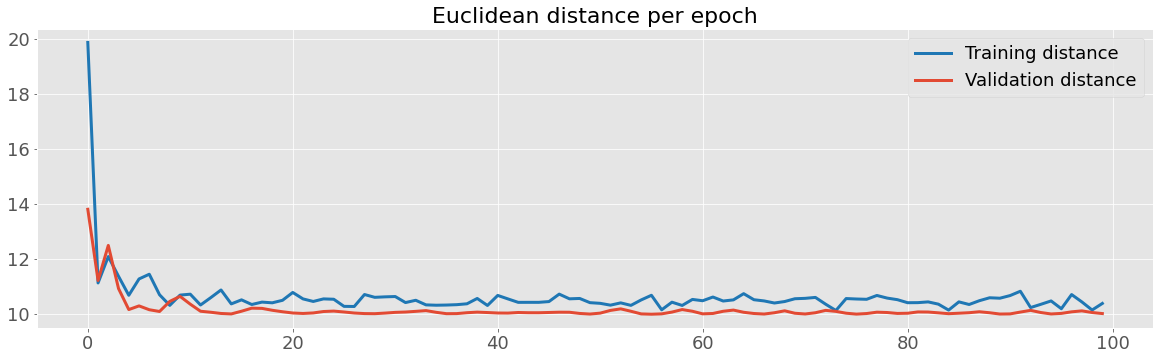

In [123]:
import torch

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 20, 5.5
    
with plt.style.context('ggplot'):
    plt.plot(train_dis_notensor[:], label = "Training distance", linewidth=3, color='tab:blue')
    plt.plot(test_dis_notensor[:], label = "Validation distance", linewidth=3)
    plt.title('Euclidean distance per epoch', fontsize=22)
    plt.legend(fontsize=18)
    plt.show()

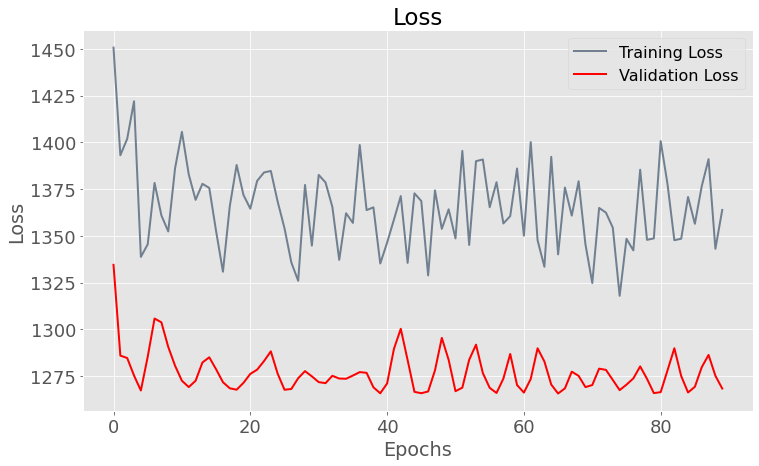

In [124]:
plot.plot_losses(train_loss[10:], test_loss[10:])

In [ ]:
# many-to-one: https://stackoverflow.com/questions/59381695/lstm-in-pytorch-how-to-add-change-sequence-length-dimension

ValueError: The 'color' keyword argument must have one color per dataset, but 12790 datasets and 1 colors were provided

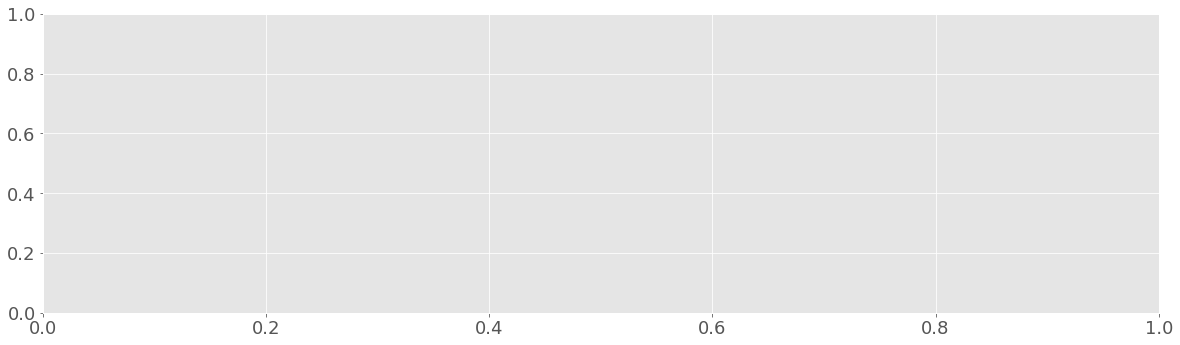

In [100]:
import statistics

plt.rcParams['figure.figsize'] = 20, 5.5
plt.rcParams.update({'font.size': 25})
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18)

with plt.style.context('ggplot'):
    max_lim = 17
    plt.hist(train_dis_item_notensor[10:], bins=50, rwidth=0.9, color='#607c8e', range=(0, max_lim), alpha=0.9)
    plt.xlabel('Distance', fontsize=20)
    plt.ylabel('Amount', fontsize=20)
    plt.title('Training set - Distances (50 bins)', fontsize=22)
    mean_val = statistics.mean(train_dis_item_notensor[10:])
    plt.text(mean_val*1.1, max_lim*0.9, 'Mean: {:.2f}'.format(mean_val), fontsize=22)
    plt.axvline(mean_val, color='k', linestyle='dashed', linewidth=2)
    plt.show()

with plt.style.context('ggplot'):
    plt.hist(test_dis_item_notensor[10:], bins=50, rwidth=0.9, color='indianred', range=(0, 17), alpha=0.9)
    plt.xlabel('Distance', fontsize=20)
    plt.ylabel('Amount', fontsize=20)
    plt.title('Validation set - Distances (50 bins)', fontsize=22)
    mean_val = statistics.mean(test_dis_item_notensor[10:])
    plt.text(mean_val*1.1, max_lim*0.9, 'Mean: {:.2f}'.format(mean_val), fontsize=22)
    plt.axvline(mean_val, color='k', linestyle='dashed', linewidth=2)
    plt.show()